In [7]:
import lxml
import pyteomics
from pyteomics import mass
from pyteomics import mzxml, auxiliary, fasta
from copy import deepcopy
import pandas as pd
import numpy as np
import copy
from collections import Counter
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
import re
from IPython.display import clear_output

In [8]:
from pyteomics import mass
import numpy as np
import copy
import re
import random


def startswith(s, pr):
    return s[:len(pr)] == pr


def removeprefix(s, pr):
    return s[len(pr):]


def read_msalign(fileName):
    msalign_specs = []
    with open(fileName) as f:
        for line in f:
            line = line.strip()
            if line == '':
                continue
            elif line == 'BEGIN IONS':
                _id = None
                scans = None
                activation = None
                precursor_mz = None
                precursor_z = None
                precursor_m = None
                peaks = []
            elif startswith(line, 'ID='):
                _id = int(removeprefix(line, 'ID='))
            elif startswith(line, 'SCANS='):
                scans = int(removeprefix(line, 'SCANS='))
            elif startswith(line, 'ACTIVATION='):
                activation = removeprefix(line, 'ACTIVATION=')
            elif startswith(line, 'PRECURSOR_MZ='):
                precursor_mz = float(removeprefix(line, 'PRECURSOR_MZ='))
            elif startswith(line, 'PRECURSOR_CHARGE='):
                precursor_z = int(removeprefix(line, 'PRECURSOR_CHARGE='))
            elif startswith(line, 'PRECURSOR_MASS='):
                precursor_m = float(removeprefix(line, 'PRECURSOR_MASS='))
            elif line == 'END IONS':
                msalign_specs.append({
                    'num': scans,
                    'activation': activation,
                    'precursor_mz': precursor_mz,
                    'precursor_z': precursor_z,
                    'precursor_m': precursor_m,
                    'm_array': [p[0] for p in peaks],
                    'i_array': [p[1] for p in peaks],
                    'z_array': [p[2] for p in peaks],
                })
            elif len(line.split()) == 3:
                items = line.split()
                peaks.append((float(items[0]), float(items[1]), int(items[2])))
            else:
                raise Exception
    return msalign_specs


proton = mass.calculate_mass(formula='', charge=1)
H2O = mass.calculate_mass(formula='H2O')
NH3 = mass.calculate_mass(formula='NH3')


def loose_molecule(ions, remove_molecule=True, add_molecule=False):
    molecules = {
        'H2O': H2O,
        'NH3': NH3,
    }
    result = []
    for ion in ions:
        result.append(ion)
        for mol_name, mol_mass in molecules.items():
            if remove_molecule:
                new_ion = copy.deepcopy(ion)
                new_ion['name'] += f'-{mol_name}'
                new_ion['mass_0'] -= mol_mass
                result.append(new_ion)
            if add_molecule:
                new_ion = copy.deepcopy(ion)
                new_ion['name'] += f'+{mol_name}'
                new_ion['mass_0'] += mol_mass
                result.append(new_ion)
    return result


amino_acids = list('GDACHIWTLQKPENSRVFMY')

def gen_random_protein(length):
    return ''.join([amino_acids[random.randint(0, len(amino_acids)-1)] for _ in range(length)])


def match_items(items1, key1, items2, key2, err=10):
    def check(x, y):
        if abs(x - y) / max(x, y) <= err/1e6:
            return 0
        elif x < y:
            return -1
        else:
            return 1
    
    if key1 is None:
        key1 = lambda x: x
    elif isinstance(key1, str):
        key1 = lambda x, k=key1: x[k]
    
    if key2 is None:
        key2 = lambda x: x
    elif isinstance(key2, str):
        key2 = lambda x, k=key2: x[k]
    
    matched = []
    sorted_items1 = sorted(items1, key=key1)
    sorted_items2 = sorted(items2, key=key2)
    p2 = 0
    for p1 in range(len(sorted_items1)):
        while p2 < len(sorted_items2) and check(key2(sorted_items2[p2]), key1(sorted_items1[p1])) == -1:
            p2 += 1
        
        p22 = p2
        while p22 < len(sorted_items2) and check(key2(sorted_items2[p22]), key1(sorted_items1[p1])) == 0:
            matched.append({
                'item1': sorted_items1[p1],
                'item2': sorted_items2[p22],
            })
            p22 += 1
    
    return matched


def add_deconv_error(ions, max_deconv_err=0):
    result = []
    for ion in ions:
        result.append(ion)
        for e in range(-max_deconv_err, max_deconv_err + 1):
            if e == 0:
                continue
            new_ion = copy.deepcopy(ion)
            new_ion['name'] += f'-err=({e})'
            new_ion['mass_0'] += e
            result.append(new_ion)
    return result


def get_ions(
    sequence: str,
    prefix=False,
    suffix=False,
    middle=False,
    min_length=None,
    include_loose_molecules=True,
    max_deconv_err=0,
    include_full=True,
    include_full_prefix=False,
    include_full_suffix=False,
    loose_molecules_params=None,
):
    if min_length is None:
        min_length = 1
    
    ions = []
    if include_full:
        ions.append({
            'name': f'full',
            'len': len(sequence),
            'sequence': sequence,
            'type': 'full',
            'mass_0': mass.calculate_mass(sequence=sequence),
        })
    if prefix:
        for i in range(1, len(sequence) + (1 if include_full_prefix else 0)):
            if i >= min_length:
                ions.append({
                    'name': f'b{i}',
                    'len': i,
                    'sequence': sequence[:i],
                    'type': 'b',
                    'mass_0': mass.calculate_mass(sequence=sequence[:i], ion_type='b', charge=0)
                })
    if suffix:
        for i in range(1, len(sequence) + (1 if include_full_suffix else 0)):
            if i >= min_length:
                ions.append({
                    'name': f'y{i}',
                    'len': i,
                    'sequence': sequence[-i:],
                    'type': 'y',
                    'mass_0': mass.calculate_mass(sequence=sequence[-i:], ion_type='y', charge=0)
                })
    if middle:
        for i in range(1, len(sequence) - 1):
            for j in range(i + 1, len(sequence)):
                if j - i >= min_length:
                    ions.append({
                        'name': f'm{i}_{j}',
                        'len': j-i,
                        'sequence': sequence[i:j],
                        'type': 'm',
                        'mass_0': mass.calculate_mass(sequence=sequence[i:j], ion_type='b', charge=0)
                    })
    if include_loose_molecules:
        ions = loose_molecule(ions, **(loose_molecules_params or {}))
    if max_deconv_err > 0:
        ions = add_deconv_error(ions, max_deconv_err=max_deconv_err)
    return ions


def get_cnt_annotated_masses(m_array, sequence: str, ions=None, err=10):
    if ions is None:
        ions = get_ions(sequence, prefix=True, suffix=True)
    if not isinstance(m_array, np.ndarray):
        m_array = np.array(m_array)
    
    ion_masses_0 = np.array([ion['mass_0'] for ion in ions])

    return (
          ((m_array * (1-err/1e6))[None:] <= ion_masses_0[:,None])
        & (ion_masses_0[:,None] <= (m_array * (1+err/1e6))[None:])
    ).any(axis=0).sum()


def get_msalign_spec(msalign_specs, num):
    for x in msalign_specs:
        if x['num'] == num:
            return x
    return None


def filter_repeating_matches(matched):
    """
        matched: list of dicts, each dict has keys 'item1' and 'item2', where 'item1' is ion, 'item2' is a mass from m_array    
    """
    result = []
    for match in matched:
        if match['item1']['type'] == 'm':
            is_bad = False
            for match1 in matched:
                if (match1['item2'] == match['item2']) and (match1['item1'] != match['item1']):
                    is_bad = True
                    break
            if not is_bad:
                result.append(match)
        else:
            result.append(match)
    return result

In [9]:
sequence = 'EHHWGYGKHNGPEHWHKDFPIANGERQSPVDIDTKAVVQDPALKPLALVYGEATSRRMVNNGHSFNVEYDDSQDKAVLKDGPLTGTYRLVQFHFHWGSSDDQGSEHTVDRKKYAAELHLVHWNTKYGDFGTAAQQPDGLAVVGVFLKVGDANPALQKVLDALDSIKTKGKSTDFPNFDPGSLLPNVLDYWTYPGSLTTPPLLESVTWIVLKEPISVSSQQMLKFRTLNFNAEGEPELLMLANWRPAQPLKNRQVRGFPK'

In [10]:
msalign_specs = read_msalign('CAH_test_02_msdeconv.msalign')
msalign_specs = [x for x in msalign_specs if len(x['m_array']) >= 10]
len(msalign_specs)

646

In [12]:
msalign_result = []

ions = get_ions(sequence, prefix=True, suffix=True)

for spec in tqdm(msalign_specs):
    m_array = np.array(spec['m_array'])
    cnt_annotated = get_cnt_annotated_masses(m_array, sequence, ions=ions, err=10)
    msalign_result.append({
        'spectrum': spec,
        'm_size': len(m_array),
        'cnt_annotated': cnt_annotated,
        'frac_annotated': cnt_annotated / len(m_array) * 100,
        'sequence': sequence,
    })

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [00:00<00:00, 3397.08it/s]


In [13]:
msalign_specs_data = pd.DataFrame(msalign_result, index=[x['num'] for x in msalign_specs])

In [14]:
interesting_nums = [821, 823, 839, 875, 879, 911, 915, 948, 995, 1066, 1074, 1076, 1078, 1103, 1220, 1275, 1288, 1293, 1294, 1319, 1327, 1344, 1357, 1443, 1633, 1663, 1667, 1668, 1670, 1687, 1688, 2058, 2086, 2129, 2254, 2255, 2274, 2302, 2309, 2310, 2311, 2313, 2314, 2316, 2318, 2322, 2323, 2324, 2326, 2327, 2329, 2331, 2332, 2340, 2345, 2385, 2408, 2417, 2419, 2431, 2437, 2439, 2450, 2458, 2462, 2464, 2466, 2467, 2468, 2475, 2479, 2482, 2490, 2502, 2505, 2508, 2515, 2527, 2535, 2544, 2575, 2577, 2603, 2608, 2614, 2651, 2682, 2693, 2848, 2849, 2851]

In [15]:
def get_pr_su_ions(sequence):
    return get_ions(
        sequence,
        prefix=True,
        suffix=True,
        middle=False,
        min_length=1,
        include_loose_molecules=True,
        max_deconv_err=0,
        loose_molecules_params={'remove_molecule': True, 'add_molecule': False}
    )

def get_middle_ions(sequence):
    return get_ions(
    sequence,
    prefix=False,
    suffix=False,
    middle=True,
    min_length=10,
    include_loose_molecules=True,
    max_deconv_err=0,
    loose_molecules_params={'remove_molecule': True, 'add_molecule': False}
)

Spectrum num=821, size=64, matched=9, frac=0.140625
Spectrum num=821, size=64, matched=8, frac=0.125


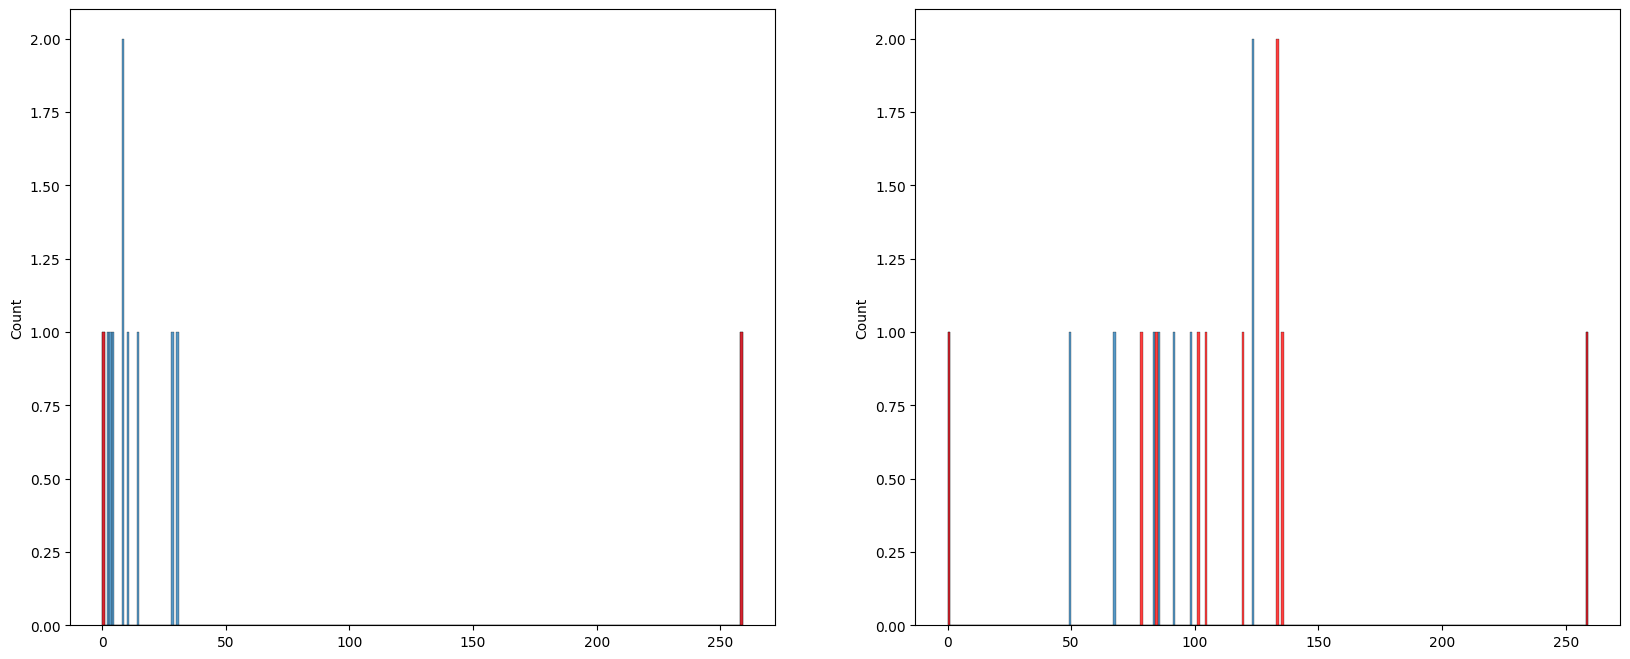

<Figure size 1200x800 with 0 Axes>

In [16]:
ions_pr_su = get_pr_su_ions(sequence)
ions_middle = get_middle_ions(sequence)

for num in interesting_nums[:1]:
    item = get_msalign_spec(msalign_specs, num)
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    
    matched = match_items(ions_pr_su, 'mass_0', item['m_array'], None, err=5)
    print(f'Spectrum num={num}, size={len(item["m_array"])}, matched={len(matched)}, frac={len(matched) / len(item["m_array"])}')

    b_pos = [x['item1']['len'] for x in matched if x['item1']['type'] == 'b']
    y_pos = [len(sequence) - x['item1']['len'] for x in matched if x['item1']['type'] == 'y']
          
    plt.figure(figsize=(12, 8))
    sns.histplot(b_pos + [0, len(sequence)], bins=len(sequence), ax=axs[0])
    sns.histplot(y_pos + [0, len(sequence)], bins=len(sequence), color='r', ax=axs[0])

    matched = match_items(ions_middle, 'mass_0', item['m_array'], None, err=5)
    matched = filter_repeating_matches(matched)
    print(f'Spectrum num={num}, size={len(item["m_array"])}, matched={len(matched)}, frac={len(matched) / len(item["m_array"])}')

    l_pos = []
    r_pos = []
    for match in matched:
        if match['item1']['type'] == 'm':
            gr = re.match(r'''^m(\d+)_(\d+)\D*''', match['item1']['name'], re.DOTALL)
            l = int(gr.group(1)); r = int(gr.group(2))
            l_pos.append(l)
            r_pos.append(r)
              
    sns.histplot(l_pos + [0, len(sequence)], bins=len(sequence), ax=axs[1])
    sns.histplot(r_pos + [0, len(sequence)], bins=len(sequence), color='r', ax=axs[1])
    plt.show()

### Statistical analysis of b- and y- ions or interior ions

In [82]:
nums_to_check = [839, 1074, 1288, 2309, 2314, 2408, 2479]

show_histograms = False

# ions_to_check = 'prefix_suffix'
ions_to_check = 'middle'

many_stats = []
for num in nums_to_check:
    dec_spec = get_msalign_spec(msalign_specs, num)
    print()
    print(f'Spectrum num = {num}')
    m_array = np.array(dec_spec['m_array'])
    
    if ions_to_check == 'prefix_suffix':
        ions = get_pr_su_ions(sequence)
    elif ions_to_check == 'middle':
        ions = get_middle_ions(sequence)
    our_cnt_matched = get_cnt_annotated_masses(m_array, sequence, ions=ions)
    
    print(f'Number of matched = {our_cnt_matched}')
    print(f'Size of m_array = {len(m_array)}')
          
    T = 100
    sample = []
    for _ in tqdm(range(T)):
        random_sequence = gen_random_protein(len(sequence))
        if ions_to_check == 'prefix_suffix':
            ions = get_pr_su_ions(random_sequence)
        elif ions_to_check == 'middle':
            ions = get_middle_ions(random_sequence)
        sample.append(get_cnt_annotated_masses(m_array, random_sequence, ions=ions))
    sample = np.array(sample)
          
    print(f'p-value = {(sample >= our_cnt_matched).mean()}')
    print('95% quantile =', np.quantile(sample, 0.95))

    if show_histograms:
        sns.histplot(sample)
        plt.show()
    
    many_stats.append({
        'matched_item': dec_spec,
        'out_cnt_matched': our_cnt_matched,
        'sample': sample,
        'ca_value': np.quantile(sample, 0.95),
        'p-value': (sample >= our_cnt_matched).mean(),
    })


Spectrum num = 839
Number of matched = 23
Size of m_array = 69


100%|██████████| 100/100 [05:23<00:00,  3.24s/it]


p-value = 0.93
95% quantile = 39.05

Spectrum num = 1074
Number of matched = 31
Size of m_array = 75


100%|██████████| 100/100 [05:20<00:00,  3.21s/it]


p-value = 0.85
95% quantile = 43.05

Spectrum num = 1288
Number of matched = 83
Size of m_array = 150


100%|██████████| 100/100 [05:21<00:00,  3.22s/it]


p-value = 0.23
95% quantile = 89.0

Spectrum num = 2309
Number of matched = 74
Size of m_array = 150


100%|██████████| 100/100 [05:25<00:00,  3.25s/it]


p-value = 0.0
95% quantile = 49.05

Spectrum num = 2314
Number of matched = 226
Size of m_array = 467


100%|██████████| 100/100 [05:31<00:00,  3.31s/it]


p-value = 0.0
95% quantile = 209.1

Spectrum num = 2408
Number of matched = 34
Size of m_array = 98


100%|██████████| 100/100 [05:31<00:00,  3.31s/it]


p-value = 0.0
95% quantile = 25.049999999999997

Spectrum num = 2479
Number of matched = 105
Size of m_array = 241


100%|██████████| 100/100 [05:37<00:00,  3.37s/it]

p-value = 0.01
95% quantile = 92.05


In [84]:
for item in many_stats:
    num = item['matched_item']['num']
    dec_spec = get_msalign_spec(msalign_specs, num)
    print(num, end = ' ')
    print(len(dec_spec['m_array']), end = ' ')
    print(item['out_cnt_matched'], end = ' ')
    print(item['ca_value'])

839 69 23 39.05
1074 75 31 43.05
1288 150 83 89.0
2309 150 74 49.05
2314 467 226 209.1
2408 98 34 25.049999999999997
2479 241 105 92.05


In [74]:
nums_to_check = [839, 1074, 1288, 2309, 2314, 2408, 2479]

show_histograms = False

ions_to_check = 'prefix_suffix'
# ions_to_check = 'middle'

many_stats = []
for num in nums_to_check:
    dec_spec = get_msalign_spec(msalign_specs, num)
    print()
    print(f'Spectrum num = {num}')
    m_array = np.array(dec_spec['m_array'])
    
    our_cnt_matched = get_cnt_annotated_masses(m_array, sequence)
    print(f'Number of matched = {our_cnt_matched}')
    print(f'Size of m_array = {len(m_array)}')
          
    T = 100
    sample = []
    for _ in tqdm(range(T)):
        random_sequence = gen_random_protein(len(sequence))
        if ions_to_check == 'prefix_suffix':
            ions = get_pr_su_ions(random_sequence)
        elif ions_to_check == 'middle':
            ions = get_middle_ions(random_sequence)
        sample.append(get_cnt_annotated_masses(m_array, random_sequence))
    sample = np.array(sample)
          
    print(f'p-value = {(sample >= our_cnt_matched).mean()}')
    print('95% quantile =', np.quantile(sample, 0.95))

    if show_histograms:
        sns.histplot(sample)
        plt.show()
    
    many_stats.append({
        'matched_item': dec_spec,
        'out_cnt_matched': our_cnt_matched,
        'sample': sample,
        'ca_value': np.quantile(sample, 0.95),
        'p-value': (sample >= our_cnt_matched).mean(),
    })


Spectrum num = 839
Number of matched = 30
Size of m_array = 69


100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


p-value = 0.0
95% quantile = 3.0

Spectrum num = 1074
Number of matched = 31
Size of m_array = 75


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


p-value = 0.0
95% quantile = 3.0

Spectrum num = 1288
Number of matched = 34
Size of m_array = 150


100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


p-value = 0.0
95% quantile = 4.0

Spectrum num = 2309
Number of matched = 54
Size of m_array = 150


100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


p-value = 0.0
95% quantile = 3.0

Spectrum num = 2314
Number of matched = 100
Size of m_array = 467


100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


p-value = 0.0
95% quantile = 10.0

Spectrum num = 2408
Number of matched = 17
Size of m_array = 98


100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


p-value = 0.0
95% quantile = 2.0

Spectrum num = 2479
Number of matched = 30
Size of m_array = 241


100%|██████████| 100/100 [00:16<00:00,  6.23it/s]

p-value = 0.0
95% quantile = 3.0


In [9]:
ions = get_ions(
    sequence,
#     gen_random_protein(len(sequence)),
    prefix=True,
    suffix=True,
    middle=False,
    min_length=None,
    include_loose_molecules=False,
    max_deconv_err=0,
    include_full=False,
    include_full_prefix=True,
    include_full_suffix=True,
)

In [85]:
def add_ids_to_masses(m_array):
    result = []
    for _id, m in enumerate(m_array):
        if isinstance(m, float) or isinstance(m, int):
            result.append({
                'id': _id,
                'm': m,
            })
        else:
            m = copy.deepcopy(m)
            m['id'] = _id
            result.append(m)
    return result

In [86]:
def create_potential_pairs(m_array, ions, use_modifications=True):
    if use_modifications:
        modifications = {
            0: 0,
            +H2O: 0.1,
            -H2O: 0.1,
            +NH3: 0.1,
            -NH3: 0.1,
            +1  : 0.2,
            -1  : 0.2
        }
    else:
        modifications = {
            0: 0,
        }
    
    result = []
    for m in m_array:
        for ion in ions:
            for mod in modifications:
                start_pos = ion['mass_0'] - m['m'] + mod
                if start_pos >= -0.01:
                    result.append({
                        'potential_start': start_pos,
                        'score': 1 - modifications[mod],
                        'mod': mod,
                        'ion': ion,
                        'mass': m,
                    })
    return result

In [87]:
def group_by_ion_name(real_list):
    result = {}
    for item in real_list:
        first_char = item['ion']['name'][0]
        assert first_char in ('b', 'y')
        if first_char == 'f':
            first_char = 'b'
        if first_char not in result:
            result[first_char] = []
        result[first_char].append(item)
    return [result[k] for k in result][::]

def group_segments(real_list, tol, k='potential_start'):
    if not real_list:
        return []

    segments = []
    
    real_lists = group_by_ion_name(real_list)
    for real_list in real_lists:
        sorted_list = sorted(real_list, key=lambda x: x[k])
        segments.append([sorted_list[0]])

        for i in range(1, len(sorted_list)):
            if sorted_list[i][k] - sorted_list[i-1][k] <= tol:
                segments[-1].append(sorted_list[i])
            else:
                segments.append([sorted_list[i]])
    
    return segments

In [88]:
def get_cnt_diff_ions(matches):
    return len(set(item['ion']['name'] for item in matches))

def get_mean_score(matches):
    return sum(item['score'] for item in matches) / len(matches)

In [89]:
def generate_all_ladders(m_array, ions, debug=False):
    m_array = deepcopy(m_array)

    all_segments = []

    while True:
        poss_pairs = create_potential_pairs(m_array, ions)
        poss_pairs.sort(key=lambda x: x['potential_start'])
        segments = group_segments(poss_pairs, 4e-3)
        segments = sorted(segments, key=lambda x: (get_cnt_diff_ions(x), get_mean_score(x)), reverse=True)

        segment = segments[0]
        if get_cnt_diff_ions(segment) < 5:
            break

        all_segments.append(segment)
        used_mass_ids = set(item['mass']['id'] for item in segment)
        if debug:
            print(used_mass_ids)

        m_array = [item for item in m_array if item['id'] not in used_mass_ids]
    
    return all_segments

In [90]:
def gen_distribution_of_biggest_ladder(m_array, T=100) -> np.array:
    sample = []
    for _ in tqdm(range(T)):
        ions = get_ions(
            sequence=gen_random_protein(len(sequence)),
            prefix=True,
            suffix=True,
            middle=False,
            min_length=None,
            include_loose_molecules=False,
            max_deconv_err=0,
            include_full=False,
            include_full_prefix=True,
            include_full_suffix=True,
        )
        
        all_segments = generate_all_ladders(m_array, ions, debug=False)
        
        if len(all_segments) > 0:
            sample.append(get_cnt_diff_ions(all_segments[0]))
        else:
            sample.append(0)
    
    return np.array(sample)

In [91]:
def generate_breakpoints_for_b_ions(sequence):
    result = [0.0]
    for i in range(1, len(sequence)):
        result.append(mass.calculate_mass(sequence=sequence[:i], ion_type='b', charge=0))
    return result


def generate_breakpoints_for_y_ions(sequence):
    result = [0.0]
    for i in range(1, len(sequence)):
        result.append(mass.calculate_mass(sequence=sequence[-i:], ion_type='y', charge=0))
    return result


def locate_element_in_array(elem, array, return_error=False):
    j = 0
    for i, x in enumerate(array):
        if abs(elem - x) < abs(elem - array[j]):
            j = i
    if return_error:
        return j, abs(elem - array[j])
    else:
        return j

In [215]:
b_breakpoints = generate_breakpoints_for_b_ions(sequence)
y_breakpoints = generate_breakpoints_for_y_ions(sequence)

def locate_ladder(ladder, precursor_left=None, precursor_right=None):
    center_of_ladder = np.mean([item['potential_start'] for item in ladder])
    type_of_ions = {'b': 'b', 'y': 'y'}[ladder[0]['ion']['type']]
    if type_of_ions == 'b':
        start_pos, error = locate_element_in_array(center_of_ladder, b_breakpoints, return_error=True)
        
        result_pairs = []
        result_ends = []
        for item in ladder:
            result_pairs.append((start_pos, item['ion']['len']))
            result_ends.append(item['ion']['len'])
        
        if precursor_left is None:
            ladder_type = 'unknown'
        elif precursor_left == start_pos:
            ladder_type = 'terminal'
        elif precursor_left < start_pos:
            ladder_type = 'interior'
        else:
            raise ValueError('precursor_left is greater than start_pos')
        
        return {
            'pairs': result_pairs,
            'fixed_end': start_pos,
            'ends': result_ends,
            'type': 'left',
            'ladder_type': ladder_type,
            'error': error,
        }
    
    elif type_of_ions == 'y':
        end_pos, error = locate_element_in_array(center_of_ladder, y_breakpoints, return_error=True)
        
        result_pairs = []
        result_ends = []
        for item in ladder:
            result_pairs.append((len(sequence) - item['ion']['len'], len(sequence) - end_pos))
            result_ends.append(len(sequence) - item['ion']['len'])
        
        if precursor_right is None:
            ladder_type = 'unknown'
        elif precursor_right == len(sequence) - end_pos:
            ladder_type = 'terminal'
        elif precursor_right > len(sequence) - end_pos:
            ladder_type = 'internal'
        else:
            raise ValueError('precursor_right is less than (len(sequence) - end_pos)')

        return {
            'pairs': result_pairs,
            'fixed_end': len(sequence) - end_pos,
            'ends': result_ends,
            'type': 'right',
            'ladder_type': ladder_type,
            'error': error,
        }

In [93]:
import itertools

def draw_all_ladders(ladders):
    
    colors = itertools.cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow'])
            
    for ladder, color in zip(ladders, colors):
#         plt.figure(figsize=(12, 8))
        plt.vlines([0, len(sequence)], 0, [0, 0], colors='black', linewidth=1, alpha=1)
    
        located_ladder = locate_ladder(ladder)

        plt.vlines([located_ladder['fixed_end']], 0, [2], colors=color, linewidth=2, alpha=1)
        plt.vlines(located_ladder['ends'], 0, 1, colors=color, linewidth=1, alpha=1)

        plt.show()
        # elif locate_ladder['type'] == 'right':
        #     plt.vlines([list(right_ends)[0]], 0, [2], colors=color, linewidth=2, alpha=1)
        #     plt.vlines(list(left_ends), 0, 1, colors=color, linewidth=1, alpha=1)
        
        # left_ends = set(x[0] for x in segments)
        # right_ends = set(x[1] for x in segments)
        
        # if len(left_ends) == 1:
        #     plt.vlines([list(left_ends)[0]], 0, [2], colors=color, linewidth=2, alpha=1)
        #     plt.vlines(list(right_ends), 0, 1, colors=color, linewidth=1, alpha=1)
        # elif len(right_ends) == 1:
        #     plt.vlines([list(right_ends)[0]], 0, [2], colors=color, linewidth=2, alpha=1)
        #     plt.vlines(list(left_ends), 0, 1, colors=color, linewidth=1, alpha=1)
        # else:
        #     raise Exception    
        # plt.show()

In [94]:
all_nums = [item['num'] for item in msalign_specs]

In [20]:
# import pickle

# filter_small_ladders = True

# ions_pr_su = get_ions(
#     sequence,
#     prefix=True,
#     suffix=True,
#     middle=False,
#     min_length=1,
#     include_loose_molecules=True,
#     max_deconv_err=2,
#     loose_molecules_params={'remove_molecule': True, 'add_molecule': False}
# )

# ions_middle = get_ions(
#     sequence,
#     prefix=False,
#     suffix=False,
#     middle=True,
#     min_length=10,
#     include_loose_molecules=True,
#     max_deconv_err=0,
#     loose_molecules_params={'remove_molecule': True, 'add_molecule': False}
# )

# archive = []

# for num in all_nums[len(all_nums)//2:len(all_nums)*2//2]:
#     if num in interesting_nums:
#         continue

#     print('Num:', num)
#     archive_item = {'num': num}

#     item = get_msalign_spec(msalign_specs=msalign_specs, num=num)
#     fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    
#     matched = match_items(ions_pr_su, 'mass_0', item['m_array'], None, err=5)
#     archive_item['matched_pr_su'] = copy.deepcopy(matched)
#     print(f'Spectrum num={num}, size={len(item["m_array"])}, matched={len(matched)}, frac={len(matched) / len(item["m_array"])}')

#     b_pos = [x['item1']['len'] for x in matched if x['item1']['type'] == 'b']
#     y_pos = [len(sequence) - x['item1']['len'] for x in matched if x['item1']['type'] == 'y']
          
#     plt.figure(figsize=(12, 8))
#     sns.histplot(b_pos + [0, len(sequence)], bins=len(sequence), ax=axs[0])
#     sns.histplot(y_pos + [0, len(sequence)], bins=len(sequence), color='r', ax=axs[0])

#     matched = match_items(ions_middle, 'mass_0', item['m_array'], None, err=5)
#     archive_item['matched_middle_unfiltered'] = copy.deepcopy(matched)
#     matched = filter_repeating_matches(matched)
#     archive_item['matched_middle'] = copy.deepcopy(matched)
#     print(f'Spectrum num={num}, size={len(item["m_array"])}, matched={len(matched)}, frac={len(matched) / len(item["m_array"])}')

#     l_pos = []
#     r_pos = []
#     for match in matched:
#         if match['item1']['type'] == 'm':
#             gr = re.match(r'''^m(\d+)_(\d+)\D*''', match['item1']['name'], re.DOTALL)
#             l = int(gr.group(1)); r = int(gr.group(2))
#             l_pos.append(l)
#             r_pos.append(r)
              
#     sns.histplot(l_pos + [0, len(sequence)], bins=len(sequence), ax=axs[1])
#     sns.histplot(r_pos + [0, len(sequence)], bins=len(sequence), color='r', ax=axs[1])
#     plt.show()


#     print('Ladders')
#     m_array = add_ids_to_masses(item['m_array'])
#     all_segments = generate_all_ladders(m_array, ions, debug=True)
#     archive_item['all_segments_unfiltered'] = copy.deepcopy(all_segments)

#     if filter_small_ladders:
#         print('Filtering small ladders')
#         biggest_ladder_dist = gen_distribution_of_biggest_ladder(m_array, T=20)
#         archive_item['biggest_ladder_dist'] = copy.deepcopy(biggest_ladder_dist)
#         ladder_size_threshold = np.percentile(biggest_ladder_dist, 90)
#         archive_item['ladder_size_threshold'] = ladder_size_threshold
#         print('Threshold:', ladder_size_threshold)

#         all_segments = [item for item in all_segments if get_cnt_diff_ions(item) >= ladder_size_threshold]
    
#     archive_item['all_segments'] = copy.deepcopy(all_segments)

#     draw_all_ladders(all_segments)

#     archive.append(archive_item)

#     with open('archive_3.pickle', 'wb') as f:
#         pickle.dump(archive, f)

### Version 2 with errors close to [0, 1, 17, 18]

In [95]:
[0, proton, H2O, NH3]

[0, 1.00727646677, 18.0105646837, 17.02654910101]

In [96]:
def select_ladders_with_specific_error(ladders):
    errors = [0, proton, H2O, NH3]
    error_eps = 0.04

    filtered_ladders = []
    for ladder in ladders:
        located_ladder = locate_ladder(ladder)
        is_good = False
        for error in errors:
            if abs(located_ladder['error'] - error) < error_eps:
                is_good = True
                break
        if is_good:
            filtered_ladders.append(ladder)
    return filtered_ladders

In [97]:
def gen_distribution_of_select_ladders_with_specific_error(m_array, T=100) -> np.array:
    sample_cnt = []
    sample_len = []
    for _ in tqdm(range(T)):
        ions = get_ions(
            sequence=gen_random_protein(len(sequence)),
            prefix=True,
            suffix=True,
            middle=False,
            min_length=None,
            include_loose_molecules=False,
            max_deconv_err=0,
            include_full=False,
            include_full_prefix=True,
            include_full_suffix=True,
        )
        
        all_segments = generate_all_ladders(m_array, ions, debug=False)
        all_segments = select_ladders_with_specific_error(all_segments)
        
        sample_cnt.append(len(all_segments))

        if len(all_segments) > 0:
            sample_len.append(get_cnt_diff_ions(all_segments[0]))
        else:
            sample_len.append(0)
    
    return np.array(sample_cnt), np.array(sample_len)

Num: 821
Spectrum num=821, size=64, matched=12, frac=0.1875
Spectrum num=821, size=64, matched=8, frac=0.125


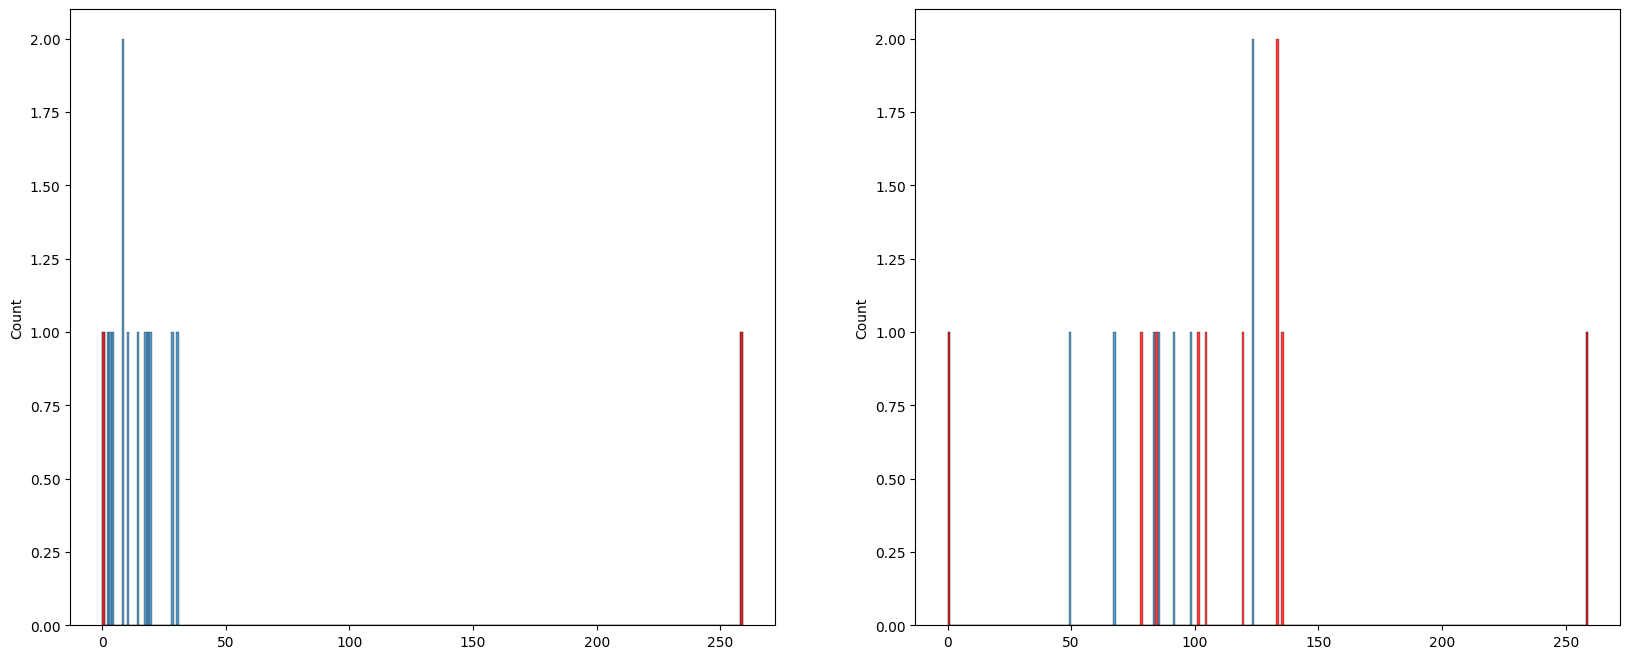

<Figure size 1200x800 with 0 Axes>

Ladders
{33, 34, 4, 38, 40, 8, 49, 50, 20, 24, 26, 31}
Filtering ladders by error


100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

Actual number of ladders: 1 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [10] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


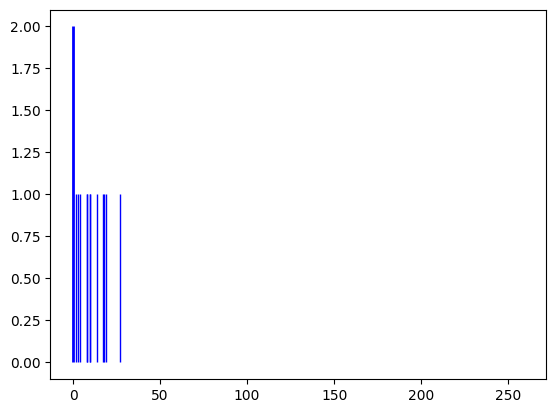

Num: 839
Spectrum num=839, size=69, matched=37, frac=0.5362318840579711
Spectrum num=839, size=69, matched=11, frac=0.15942028985507245


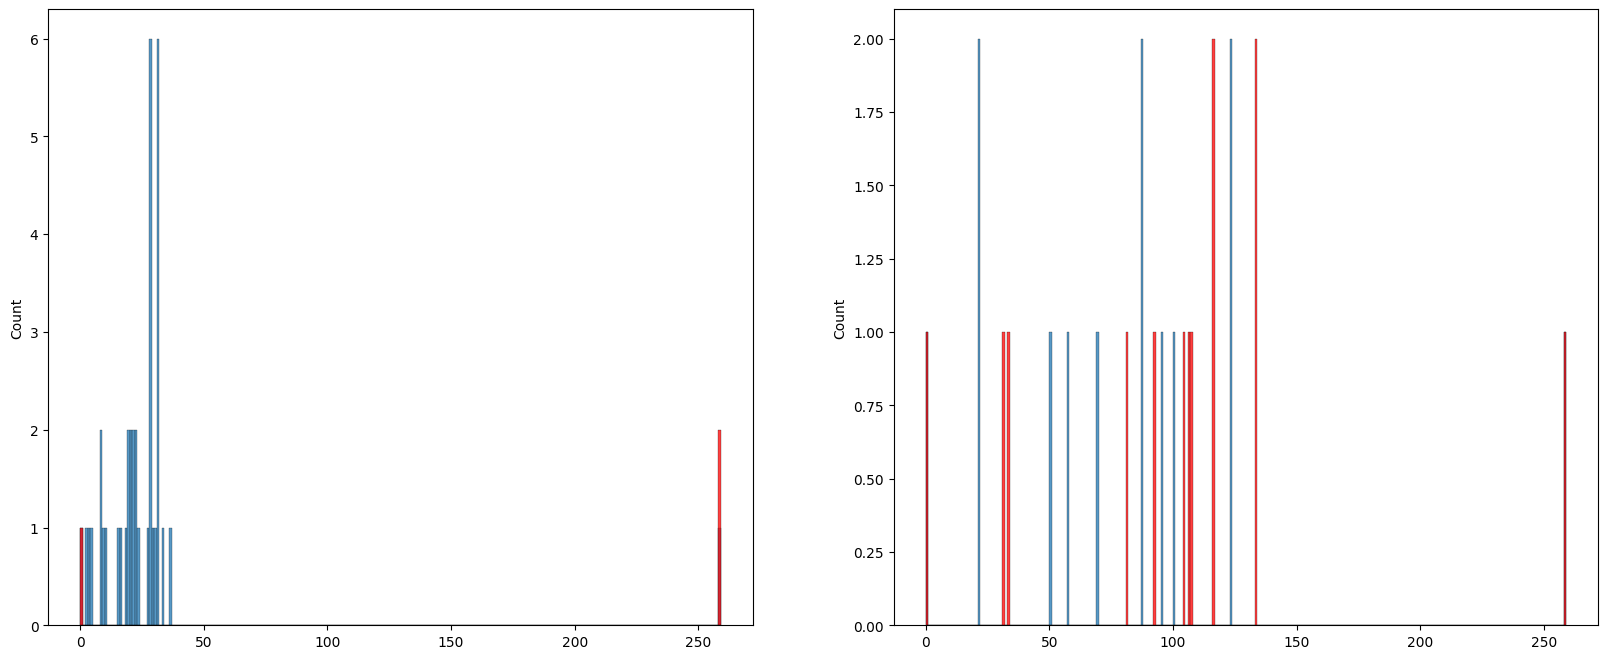

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 1, 2, 3, 5, 6, 7, 8, 9, 13, 15, 16, 18, 23, 24, 26, 27, 31, 33, 36, 41, 43, 45, 46, 50, 51, 52, 53, 58, 59, 63}
{64, 38, 10, 14, 17, 19, 54, 22, 25}
{4, 37, 40, 42, 11, 30}
{32, 34, 47, 60, 61, 62}
Filtering ladders by error


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]

Actual number of ladders: 3 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [20, 8, 5] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


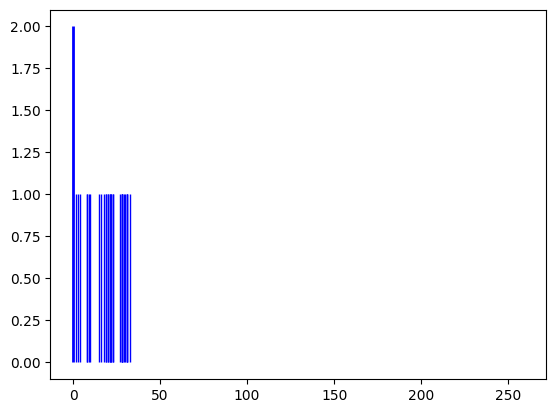

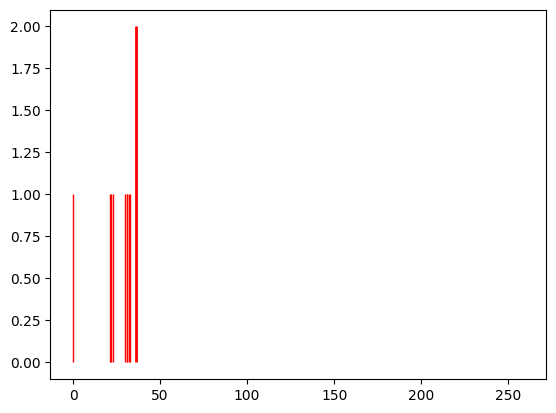

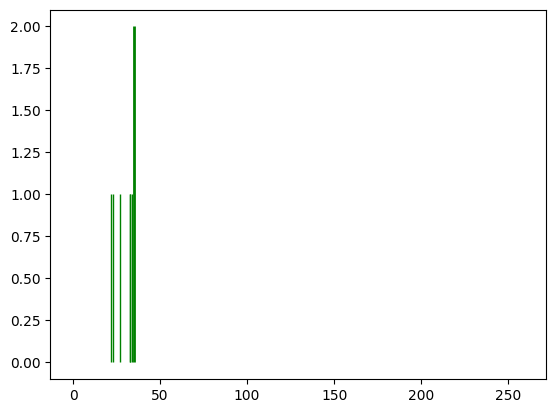

Num: 879
Spectrum num=879, size=77, matched=22, frac=0.2857142857142857
Spectrum num=879, size=77, matched=9, frac=0.11688311688311688


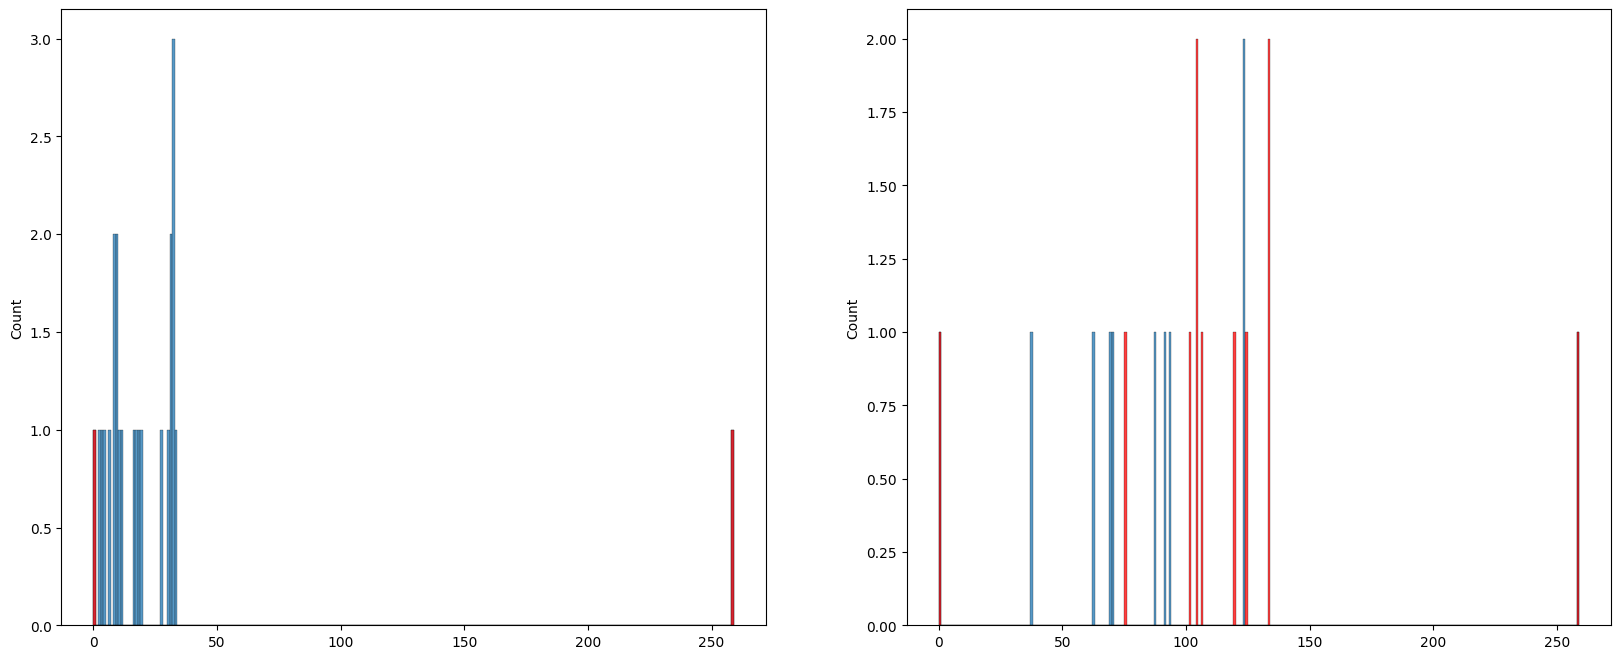

<Figure size 1200x800 with 0 Axes>

Ladders
{16, 17, 20, 25, 27, 31, 32, 33, 34, 42, 46, 48, 53, 58, 59, 60, 63, 64, 71, 74}
{68, 69, 19, 57, 61, 62}
{0, 8, 40, 76, 13, 15, 49}
Filtering ladders by error


100%|██████████| 20/20 [01:09<00:00,  3.47s/it]

Actual number of ladders: 2 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [17, 5] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


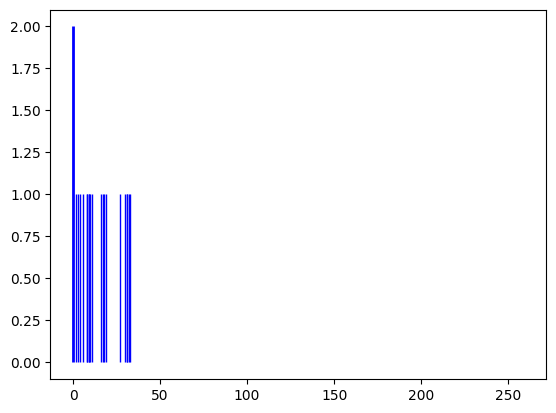

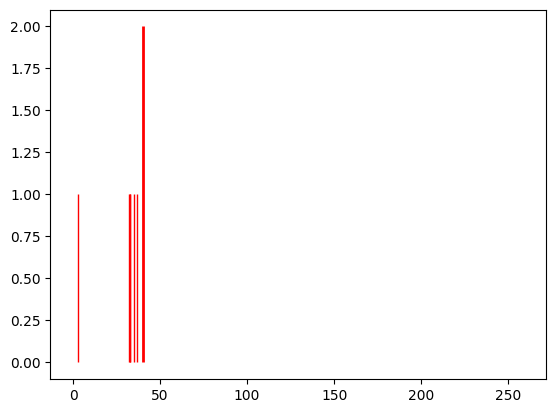

Num: 915
Spectrum num=915, size=63, matched=1, frac=0.015873015873015872
Spectrum num=915, size=63, matched=24, frac=0.38095238095238093


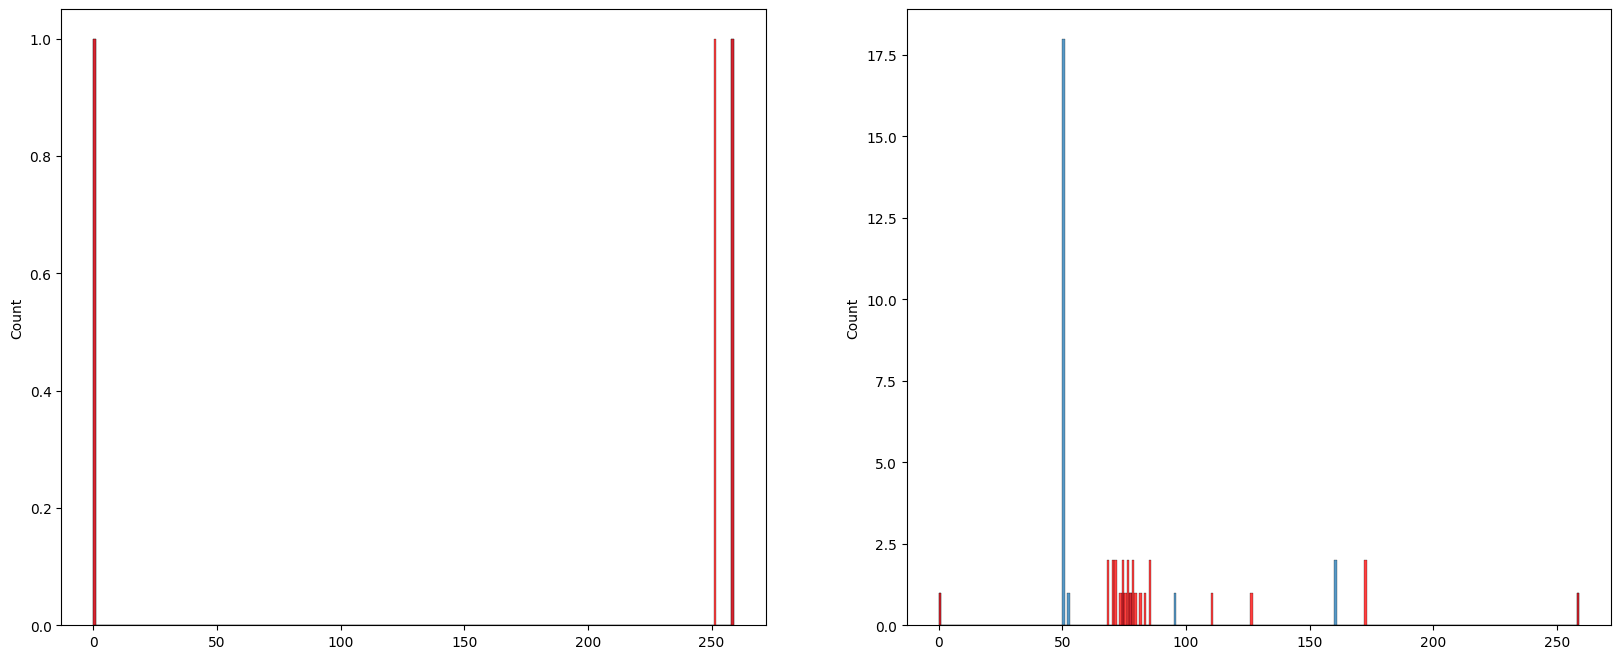

<Figure size 1200x800 with 0 Axes>

Ladders
{2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 24, 27, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 45, 47, 49}
{33, 37, 6, 41, 44, 12, 46, 48, 50, 19, 20, 21, 22, 55, 25, 26, 28, 57}
Filtering ladders by error


100%|██████████| 20/20 [00:35<00:00,  1.80s/it]

Actual number of ladders: 2 Distribution: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [17, 14] Distribution: [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]


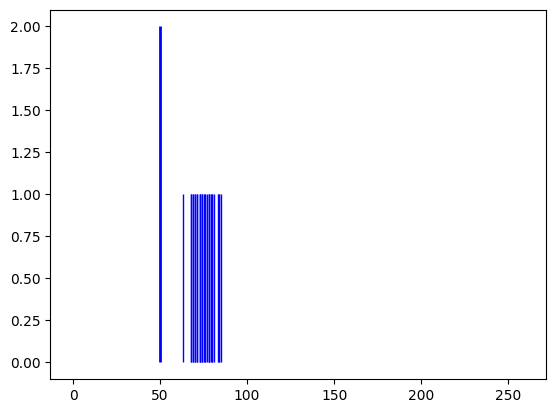

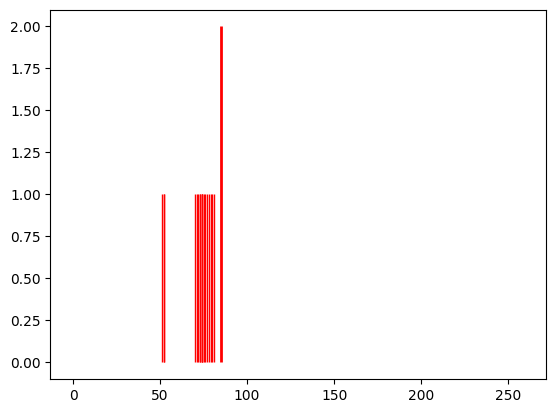

Num: 995
Spectrum num=995, size=50, matched=1, frac=0.02
Spectrum num=995, size=50, matched=12, frac=0.24


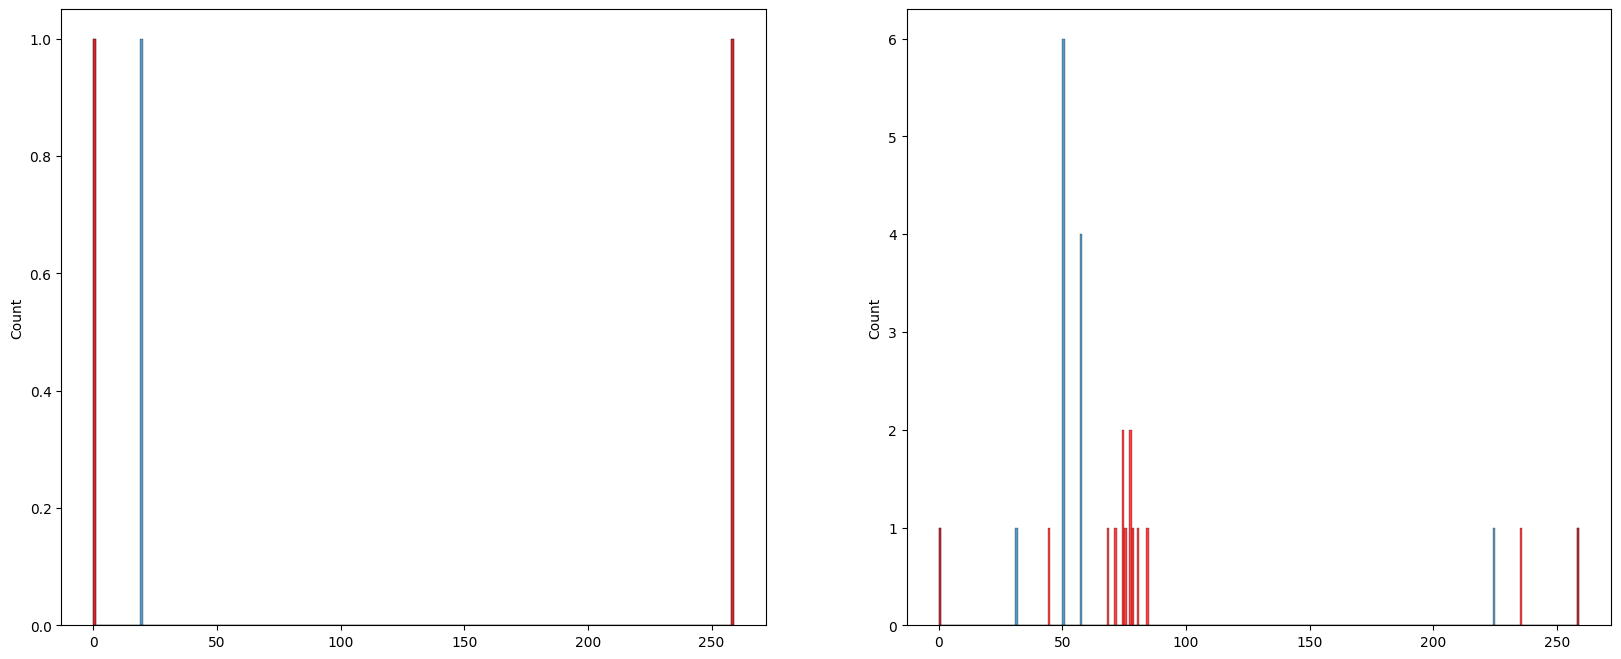

<Figure size 1200x800 with 0 Axes>

Ladders
{1, 35, 38, 6, 40, 42, 43, 13, 19, 27, 31}
{34, 8, 41, 17, 18, 20, 21, 23}
{2, 36, 5, 4, 7, 10, 22, 29}
{32, 3, 11, 44, 12, 24, 30}
Filtering ladders by error


100%|██████████| 20/20 [00:28<00:00,  1.42s/it]

Actual number of ladders: 3 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Actual length of ladders: [8, 7, 7] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]


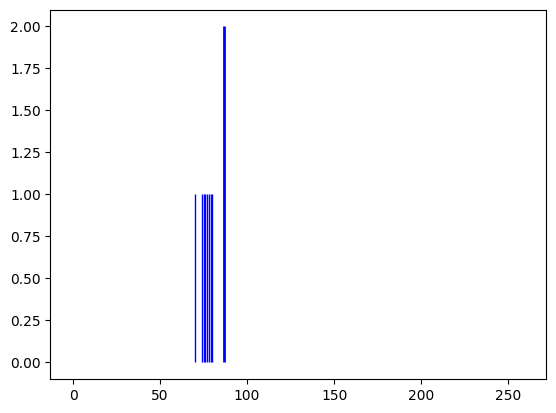

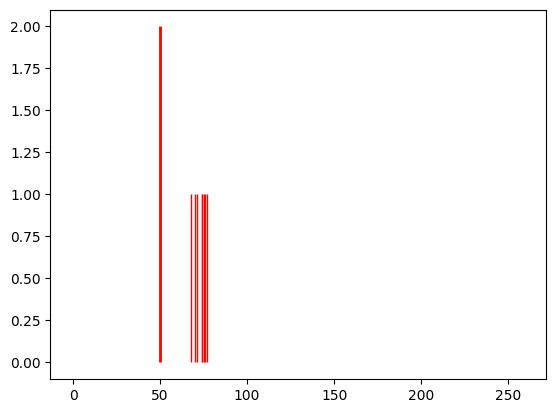

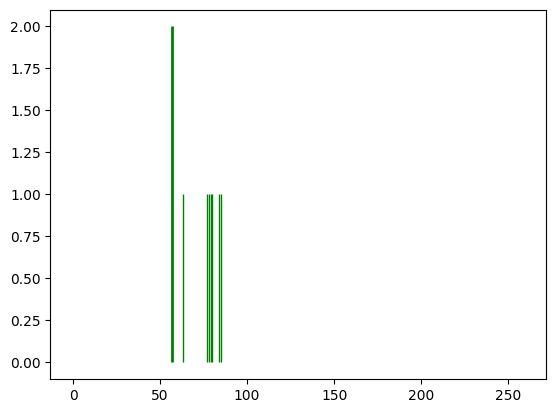

Num: 1074
Spectrum num=1074, size=75, matched=44, frac=0.5866666666666667
Spectrum num=1074, size=75, matched=18, frac=0.24


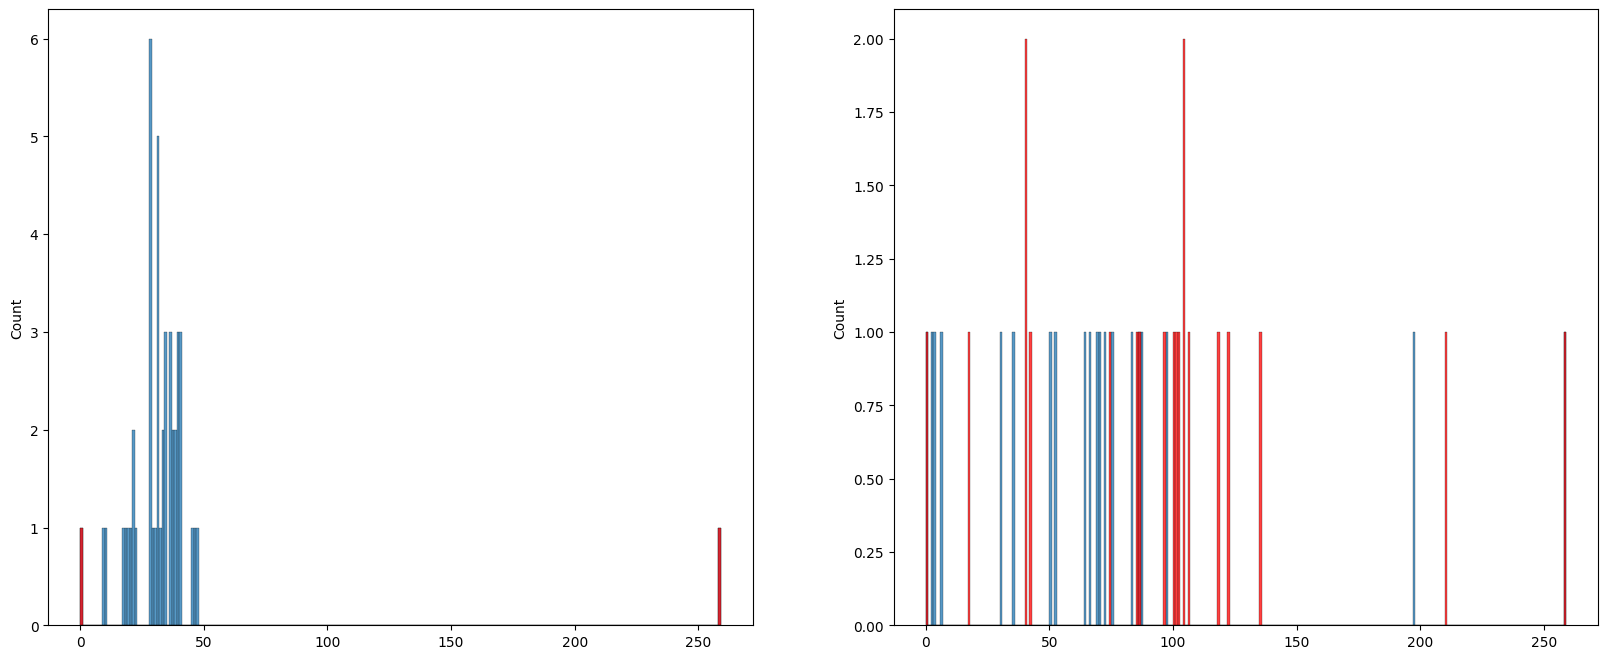

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 28, 29, 30, 31, 33, 34, 35, 37, 42, 43, 44, 45, 49, 54, 55, 60, 67, 72}
{64, 2, 36, 5, 39, 40, 41, 14, 16, 48, 51, 23, 25}
{47, 56, 24, 26, 62}
{32, 38, 15, 58, 59}
Filtering ladders by error


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]

Actual number of ladders: 3 Distribution: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [23, 9, 5] Distribution: [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]


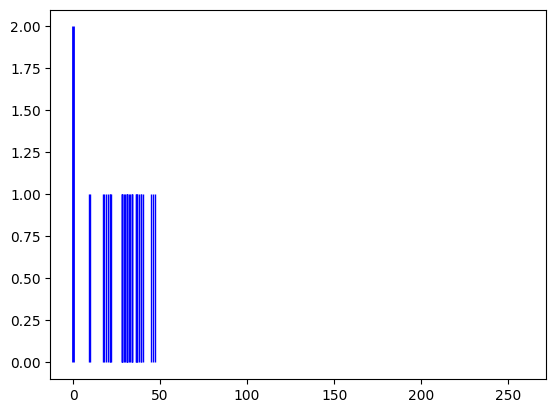

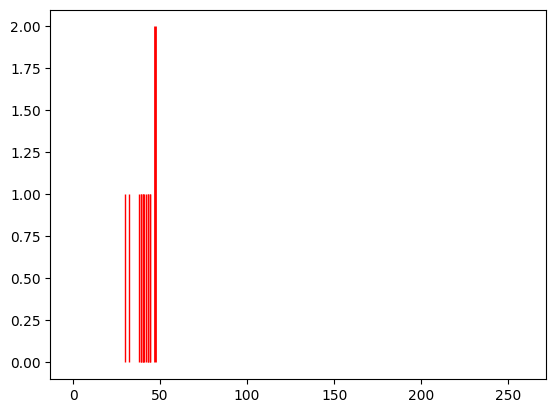

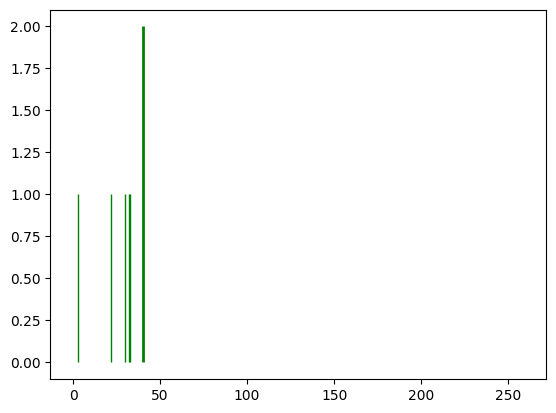

Num: 1078
Spectrum num=1078, size=55, matched=3, frac=0.05454545454545454
Spectrum num=1078, size=55, matched=21, frac=0.38181818181818183


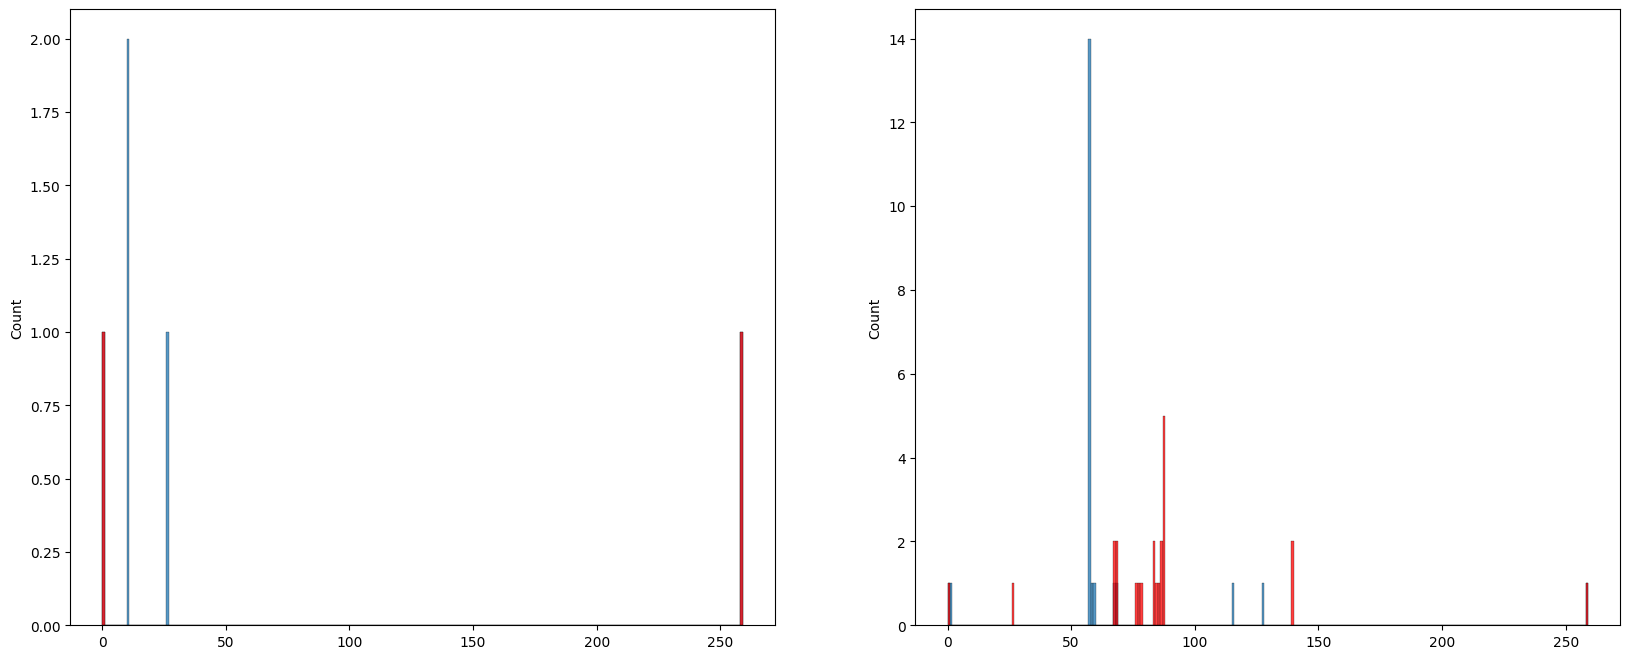

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 1, 2, 3, 4, 6, 8, 10, 15, 17, 21, 23, 26, 27, 30, 33, 34, 38, 40, 41, 42, 43, 44, 47, 51, 52}
{32, 5, 7, 11, 12, 13, 14, 16, 18, 19, 20, 22, 24, 25, 28, 29}
{36, 9, 49, 53, 31}
Filtering ladders by error


100%|██████████| 20/20 [00:42<00:00,  2.15s/it]

Actual number of ladders: 2 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [19, 11] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


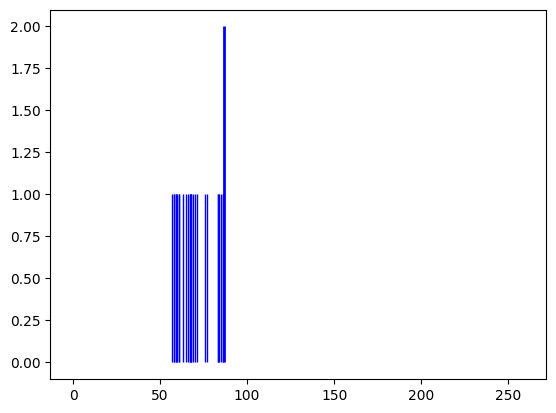

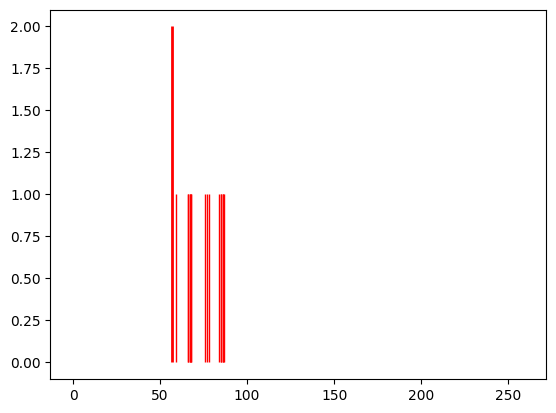

Num: 1220
Spectrum num=1220, size=69, matched=0, frac=0.0
Spectrum num=1220, size=69, matched=14, frac=0.2028985507246377


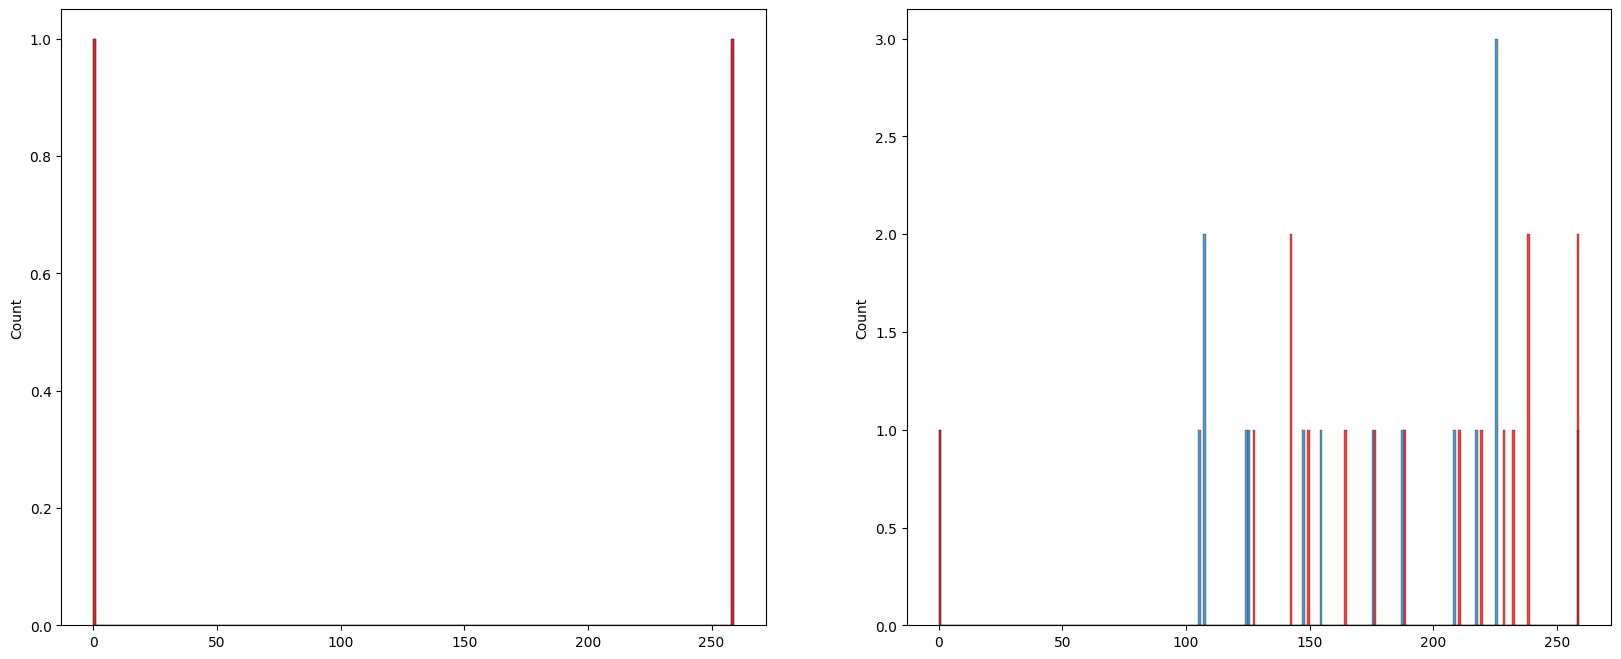

<Figure size 1200x800 with 0 Axes>

Ladders
{32, 5, 38, 7, 8, 12, 46, 19, 52, 53, 21, 57}
{37, 9, 42, 17, 22, 55}
{66, 68, 16, 24, 30}
{34, 67, 43, 49, 18}
Filtering ladders by error


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


Actual number of ladders: 0 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Num: 1288
Spectrum num=1288, size=150, matched=64, frac=0.4266666666666667
Spectrum num=1288, size=150, matched=40, frac=0.26666666666666666


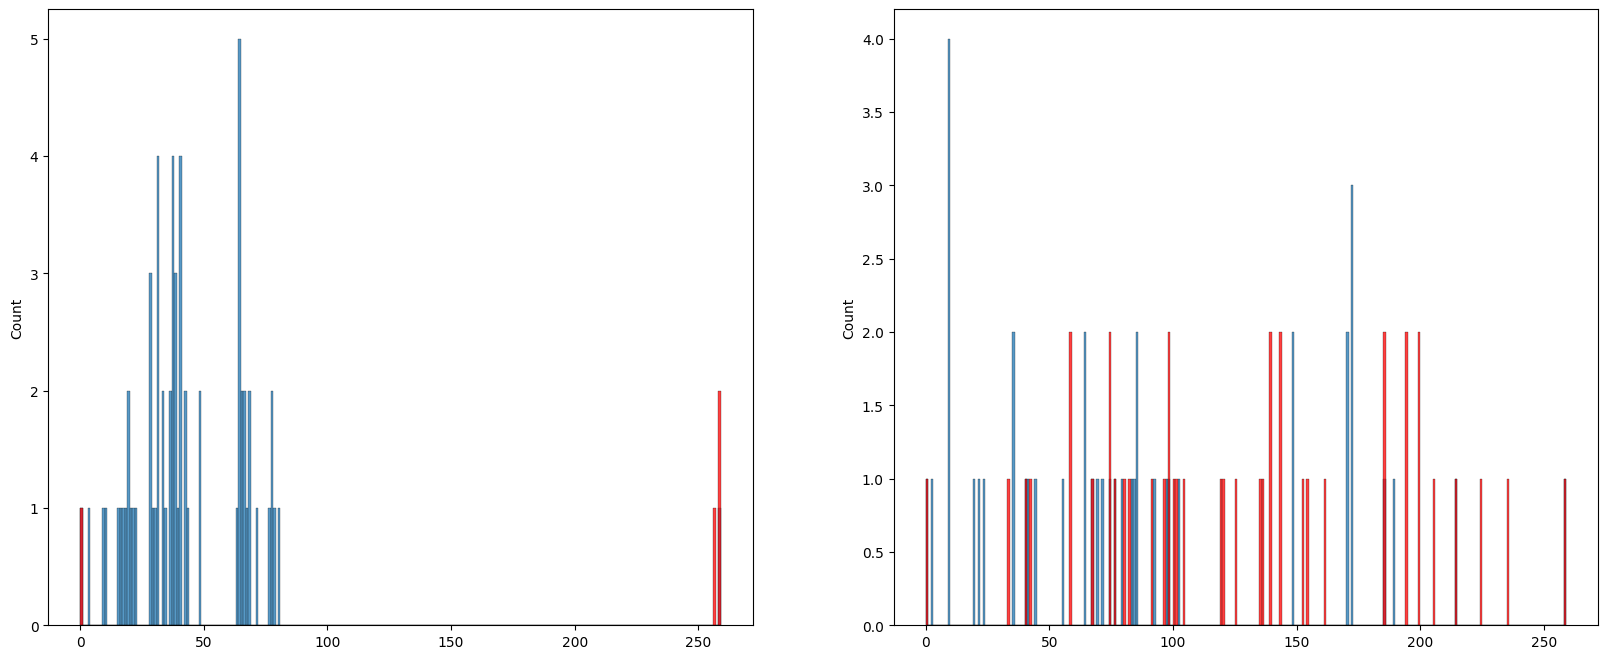

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 132, 5, 6, 9, 138, 10, 145, 17, 18, 21, 29, 30, 33, 34, 37, 39, 41, 43, 44, 49, 51, 52, 53, 57, 59, 60, 63, 71, 80, 81, 82, 85, 89, 92, 95, 97, 101, 108, 114}
{1, 2, 3, 4, 135, 11, 140, 13, 16, 146, 23, 26, 27, 32, 35, 36, 38, 40, 45, 46, 48, 58, 61, 62, 66, 69, 72, 73, 75, 88, 90, 91, 93, 99, 104, 123}
{65, 100, 8, 76, 19, 22, 56, 31}
{68, 142, 50, 149, 118, 54}
Filtering ladders by error


100%|██████████| 20/20 [03:42<00:00, 11.14s/it]

Actual number of ladders: 4 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [31, 25, 8, 6] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


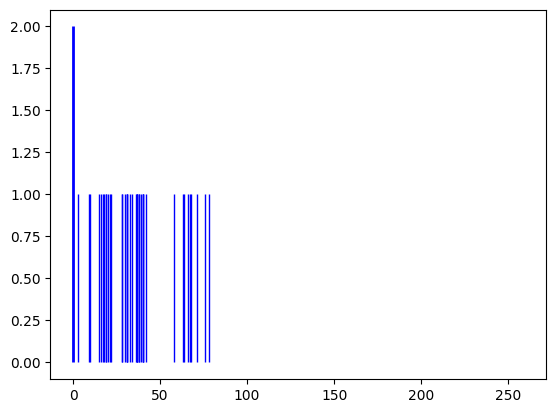

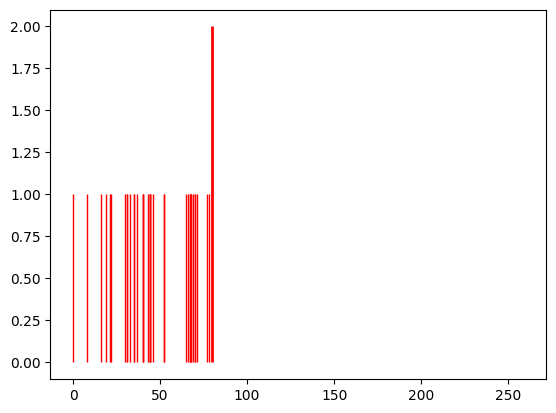

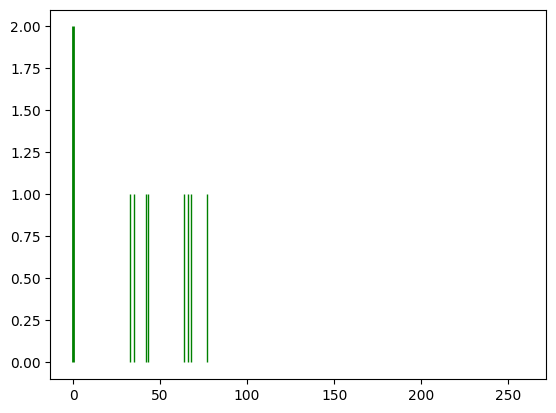

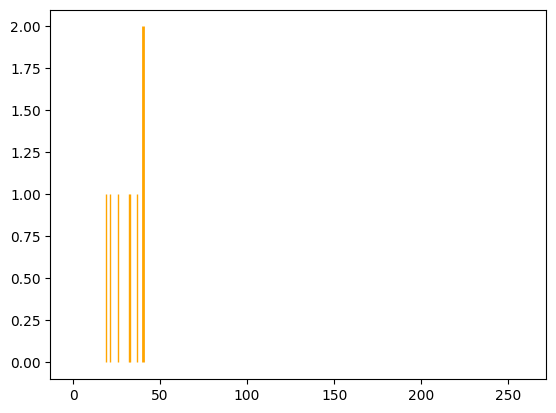

Num: 1294
Spectrum num=1294, size=126, matched=43, frac=0.3412698412698413
Spectrum num=1294, size=126, matched=32, frac=0.25396825396825395


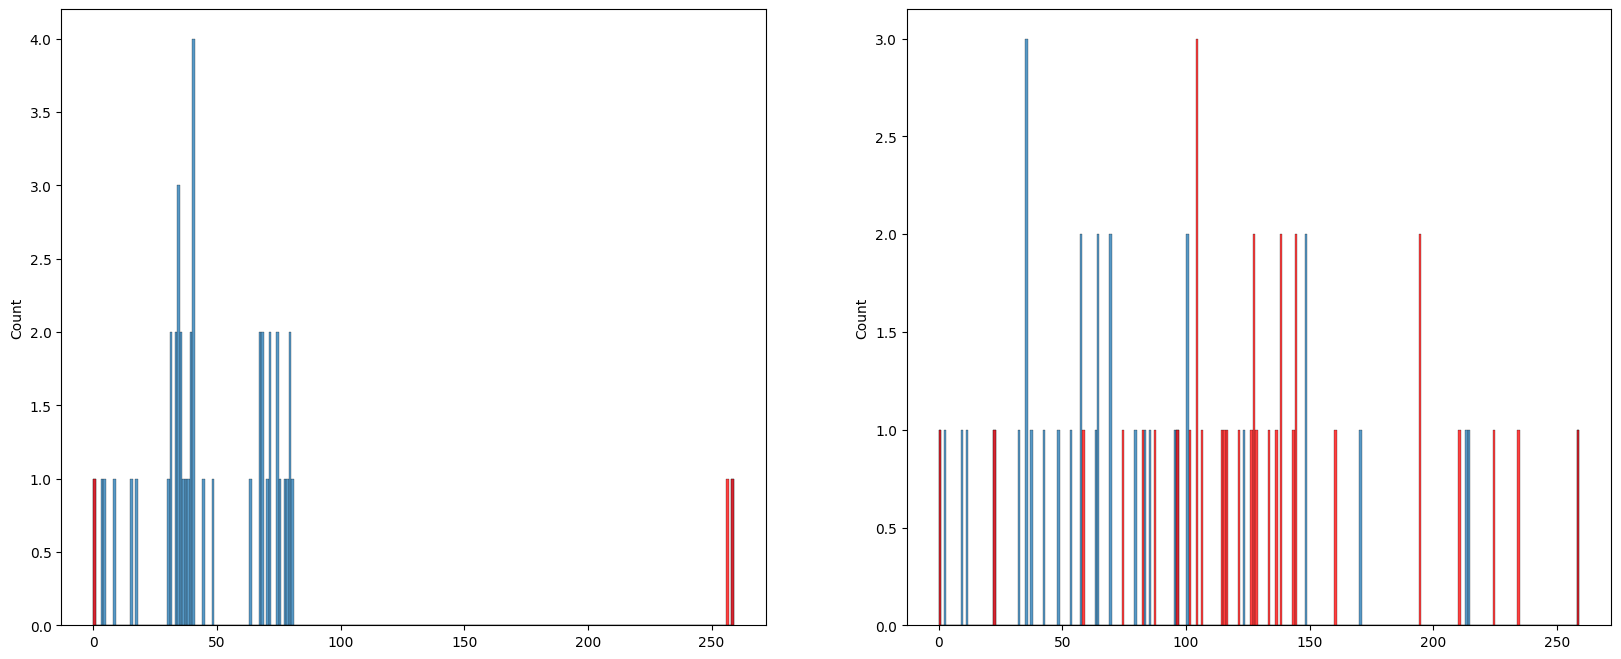

<Figure size 1200x800 with 0 Axes>

Ladders
{1, 5, 11, 14, 15, 18, 19, 20, 21, 26, 27, 36, 43, 44, 45, 46, 47, 60, 72, 87, 88, 93, 111, 117}
{3, 4, 10, 13, 16, 17, 23, 29, 30, 31, 32, 33, 35, 38, 40, 41, 50, 53, 55, 59, 66, 69, 70, 86, 98, 110, 115}
Filtering ladders by error


100%|██████████| 20/20 [02:34<00:00,  7.73s/it]

Actual number of ladders: 2 Distribution: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [22, 22] Distribution: [0 0 0 0 0 0 5 0 0 0 6 0 0 0 0 0 0 0 0 0]


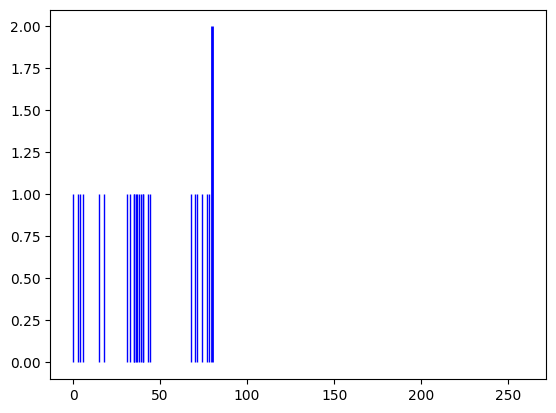

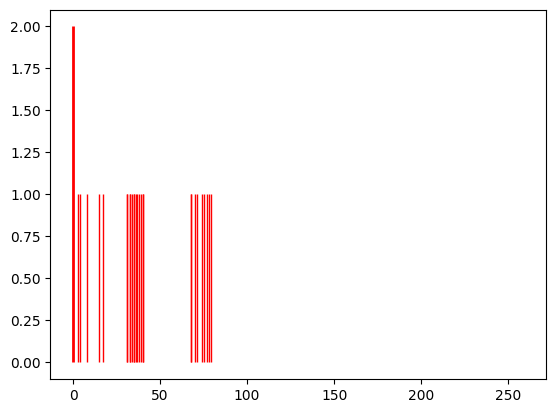

Num: 1327
Spectrum num=1327, size=94, matched=55, frac=0.5851063829787234
Spectrum num=1327, size=94, matched=16, frac=0.1702127659574468


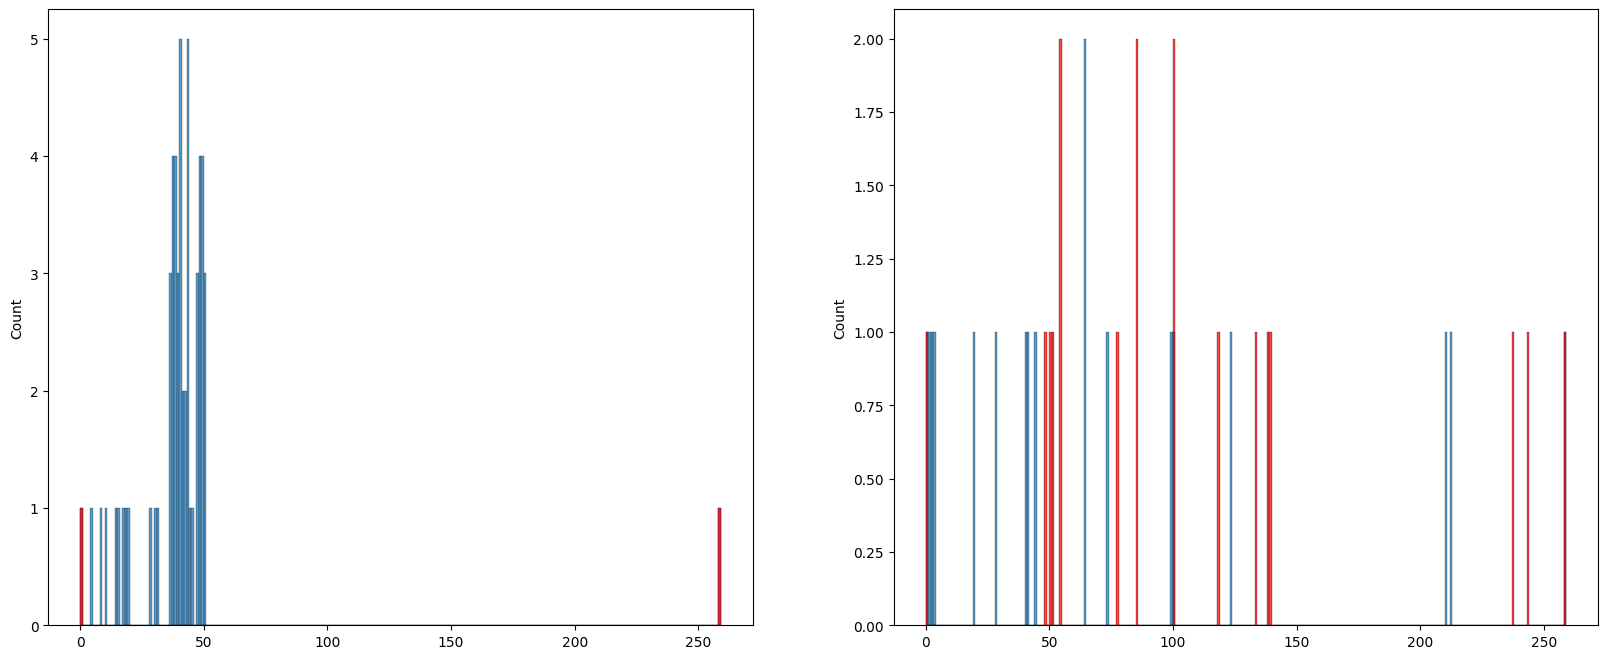

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 1, 3, 4, 6, 7, 8, 10, 12, 13, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 39, 49, 62, 63, 67, 71, 74, 76, 83}
{32, 36, 41, 50, 51, 18, 27, 92, 61}
{68, 45, 79, 57, 58}
Filtering ladders by error


100%|██████████| 20/20 [01:09<00:00,  3.48s/it]

Actual number of ladders: 2 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [23, 8] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


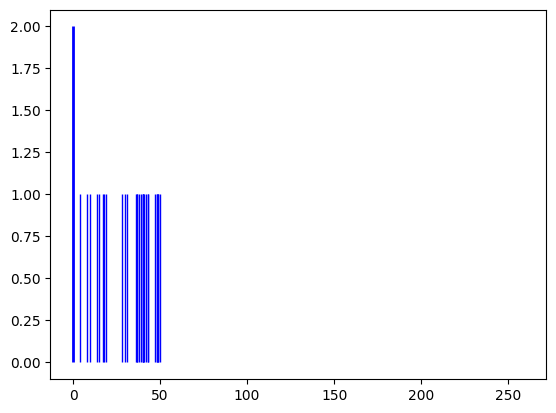

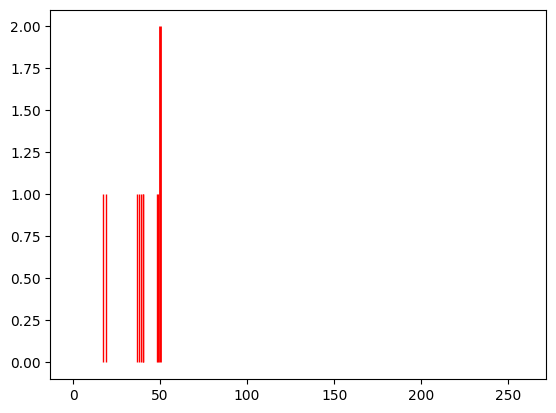

Num: 1357
Spectrum num=1357, size=162, matched=52, frac=0.32098765432098764
Spectrum num=1357, size=162, matched=28, frac=0.1728395061728395


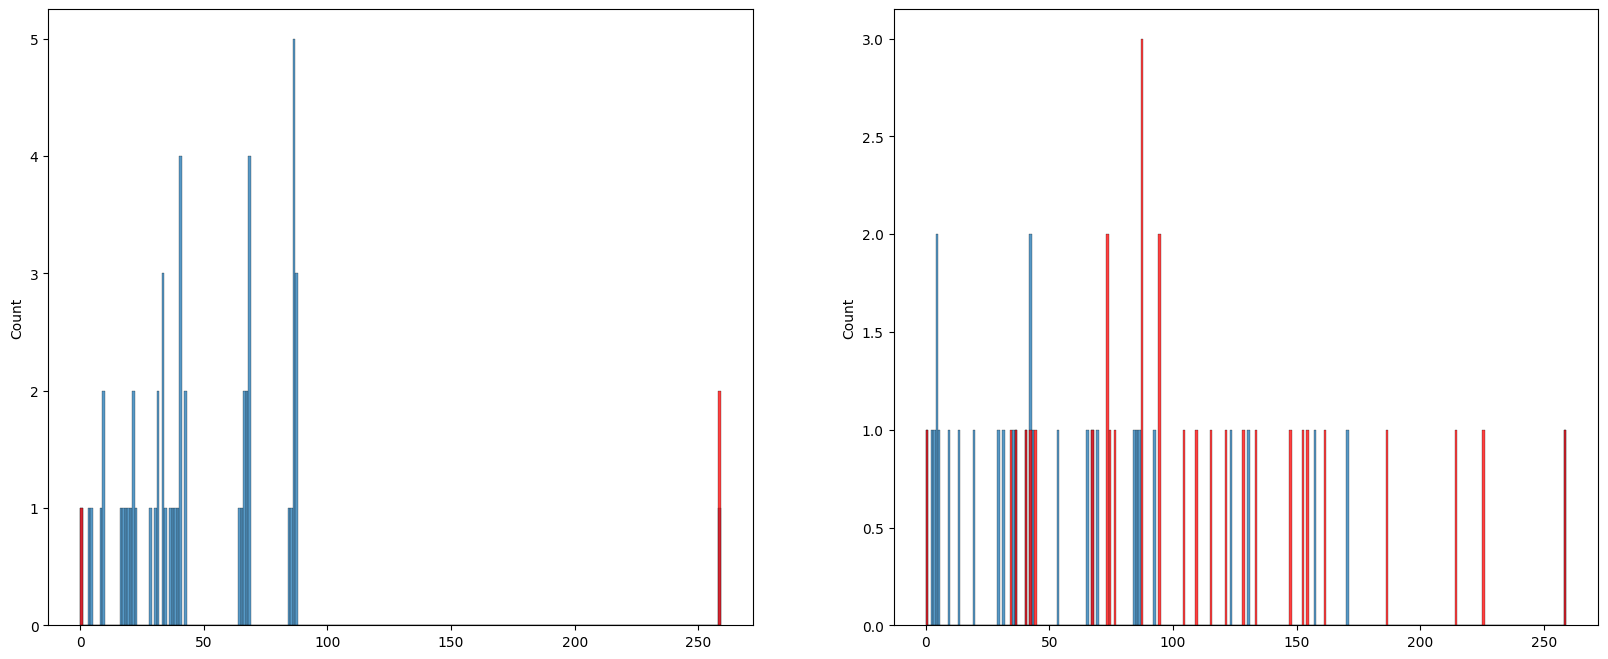

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 129, 2, 4, 5, 10, 14, 17, 146, 19, 151, 24, 25, 28, 35, 36, 42, 44, 53, 54, 55, 59, 62, 64, 69, 74, 77, 85, 88, 92, 97, 109}
{1, 6, 8, 11, 12, 15, 145, 18, 152, 26, 29, 32, 34, 41, 46, 52, 67, 75, 83, 87, 91, 115, 125}
{160, 110, 48, 56, 30}
{7, 140, 13, 79, 16}
{3, 102, 82, 20, 149}
Filtering ladders by error


100%|██████████| 20/20 [05:03<00:00, 15.19s/it]

Actual number of ladders: 3 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [26, 18, 5] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


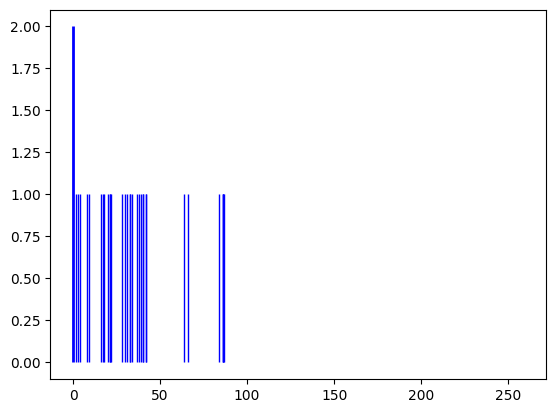

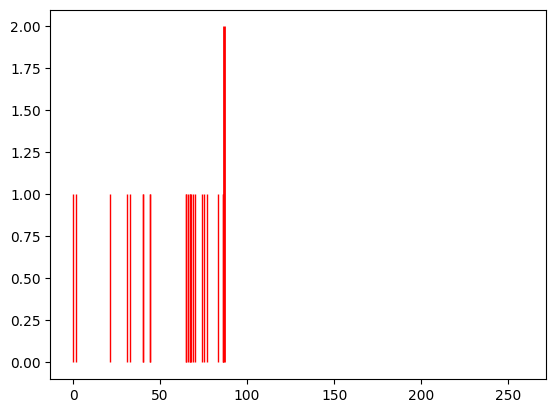

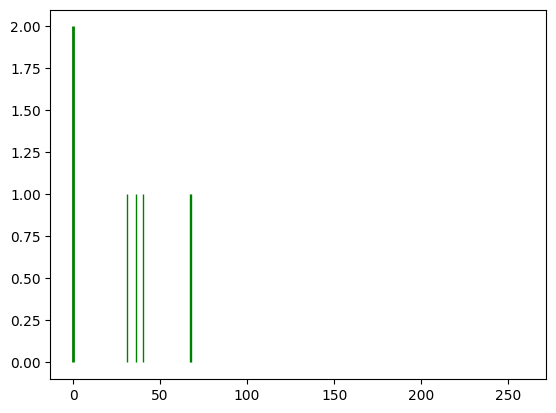

Num: 1633
Spectrum num=1633, size=347, matched=5, frac=0.01440922190201729
Spectrum num=1633, size=347, matched=90, frac=0.25936599423631124


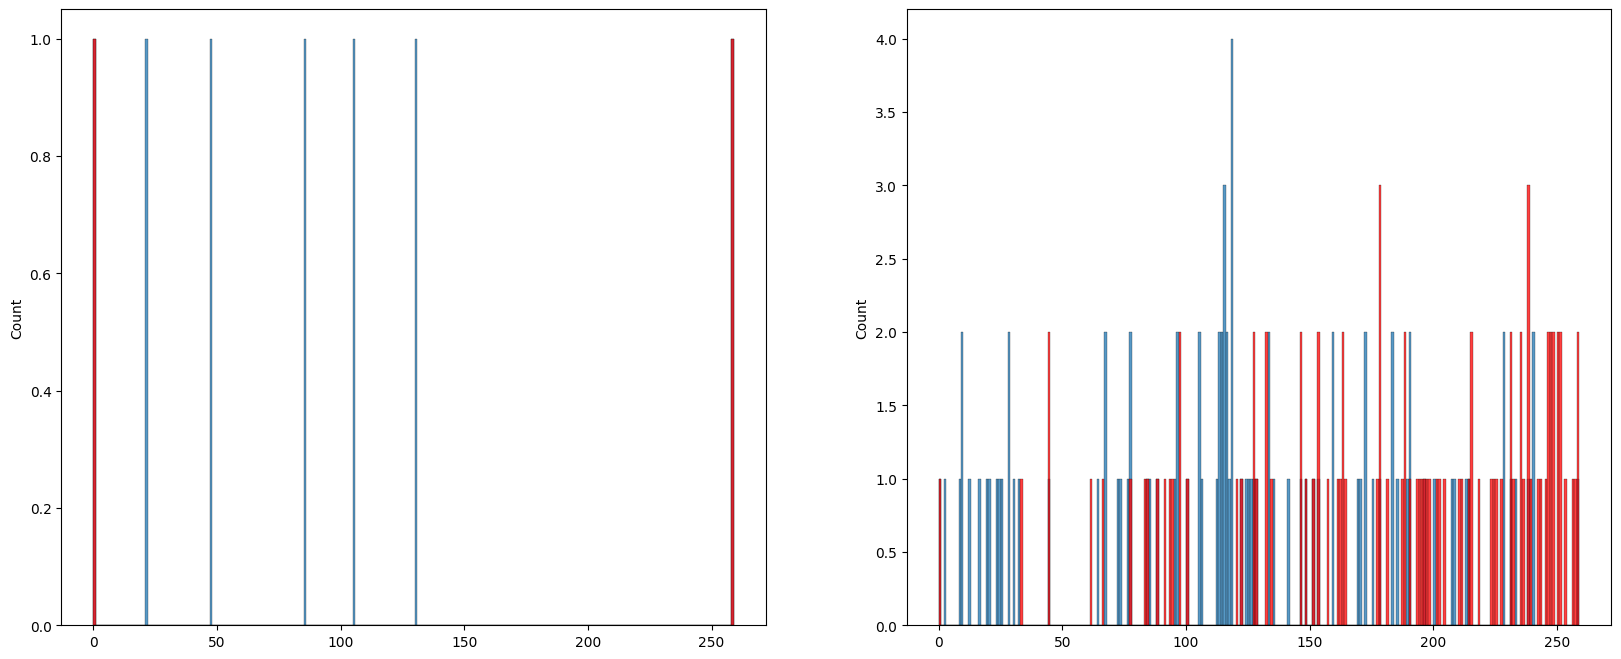

<Figure size 1200x800 with 0 Axes>

Ladders
{257, 292, 6, 102, 9, 16, 81, 148, 214, 249, 58}
{0, 2, 67, 262, 168, 137, 106, 205, 274, 250, 155, 188}
{98, 195, 197, 230, 39, 103, 108, 179, 283, 157}
{162, 42, 203, 29, 245, 279, 154, 317, 189}
{294, 107, 47, 272, 20, 23, 314}
{128, 65, 76, 110, 79, 186, 187}
{129, 231, 105, 116, 308, 54, 215, 24}
{131, 219, 143, 113, 216, 27, 28}
{73, 170, 206, 305, 146, 84, 285}
{167, 7, 301, 271, 336, 153, 31}
{32, 226, 35, 69, 13, 19, 151, 56, 61}
{326, 202, 43, 275, 344, 94}
{75, 235, 114, 278, 247, 312}
{163, 68, 261, 15, 21, 93}
{71, 201, 172, 117, 286}
{248, 236, 53, 119, 280}
{288, 258, 164, 5, 12, 86}
{37, 41, 10, 239, 83, 60}
{259, 204, 78, 25, 252}
{225, 136, 139, 237, 223}
{3, 295, 8, 91, 63}
{161, 122, 174, 89, 282}
{160, 192, 309, 85, 124}
{224, 64, 227, 80, 57}
{36, 101, 177, 49, 218}
Filtering ladders by error


100%|██████████| 20/20 [25:04<00:00, 75.22s/it]


Actual number of ladders: 0 Distribution: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [] Distribution: [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Num: 1667
Spectrum num=1667, size=57, matched=1, frac=0.017543859649122806
Spectrum num=1667, size=57, matched=13, frac=0.22807017543859648


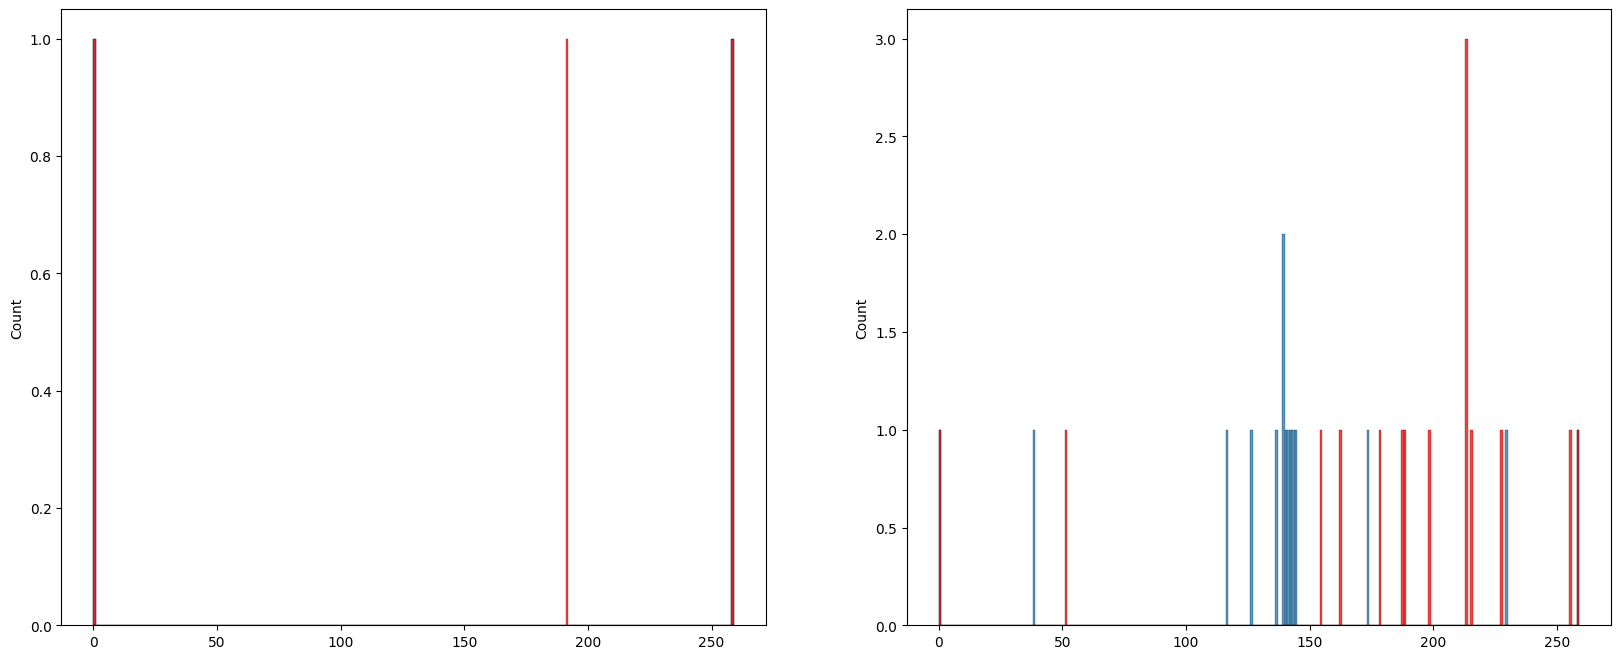

<Figure size 1200x800 with 0 Axes>

Ladders
{2, 42, 43, 18, 19, 30}
Filtering ladders by error


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Actual number of ladders: 0 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Num: 1670
Spectrum num=1670, size=140, matched=16, frac=0.11428571428571428
Spectrum num=1670, size=140, matched=25, frac=0.17857142857142858


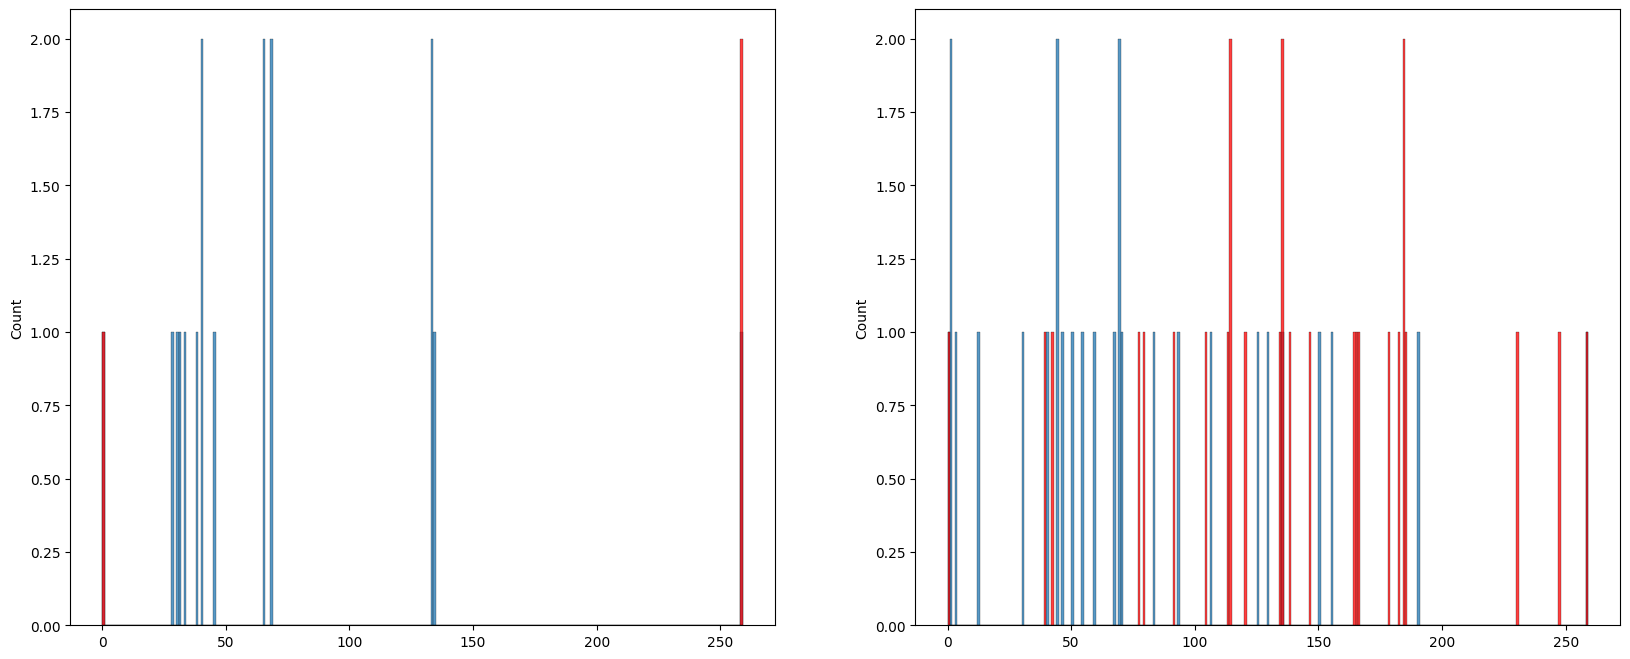

<Figure size 1200x800 with 0 Axes>

Ladders
{9, 109, 14, 81, 21}
Filtering ladders by error


100%|██████████| 20/20 [01:00<00:00,  3.03s/it]

Actual number of ladders: 1 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [5] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


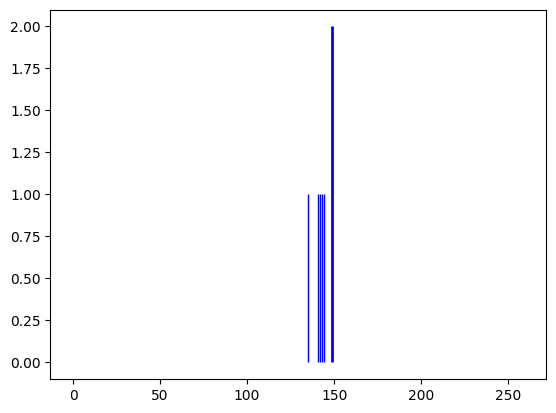

Num: 1688
Spectrum num=1688, size=133, matched=7, frac=0.05263157894736842
Spectrum num=1688, size=133, matched=28, frac=0.21052631578947367


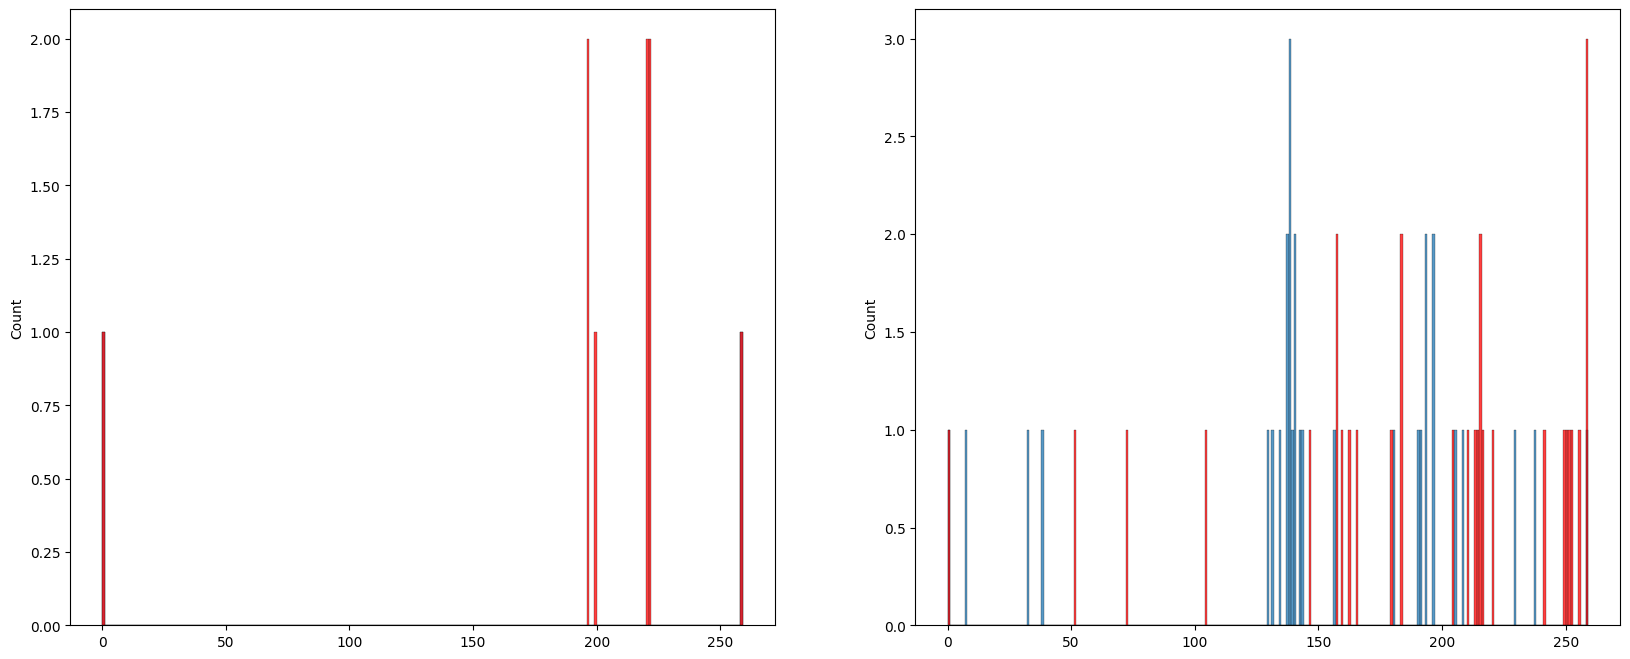

<Figure size 1200x800 with 0 Axes>

Ladders
{33, 70, 8, 74, 16, 51, 116, 120, 25, 26, 88}
{1, 34, 67, 5, 104, 50, 117}
{0, 66, 68, 20, 62, 28, 94}
{32, 4, 72, 9, 41, 52, 22, 55}
{64, 131, 42, 115, 57, 58, 92}
{77, 110, 18, 86, 56, 30}
{43, 75, 44, 24, 27}
{102, 59, 113, 82, 49, 91}
Filtering ladders by error


100%|██████████| 20/20 [02:44<00:00,  8.24s/it]


Actual number of ladders: 0 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Actual length of ladders: [] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
Num: 2086
Spectrum num=2086, size=176, matched=10, frac=0.056818181818181816
Spectrum num=2086, size=176, matched=32, frac=0.18181818181818182


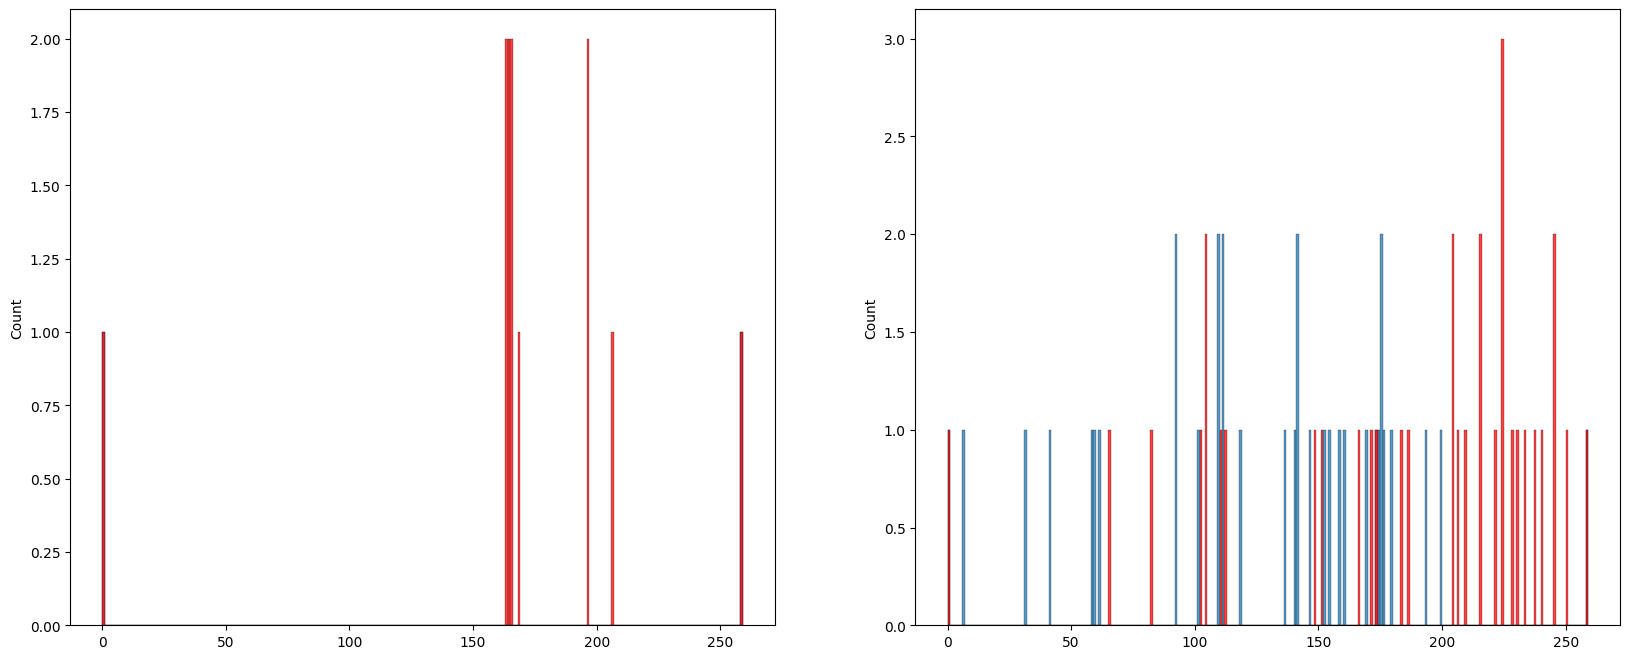

<Figure size 1200x800 with 0 Axes>

Ladders
{67, 5, 133, 175, 51, 24, 25}
{65, 72, 27, 45, 20, 91}
{110, 48, 115, 85, 56}
{4, 40, 148, 149, 62}
{32, 2, 71, 146, 22}
{66, 106, 173, 86, 58}
{165, 10, 171, 52, 121}
{38, 7, 8, 11, 76}
Filtering ladders by error


100%|██████████| 20/20 [03:10<00:00,  9.50s/it]

Actual number of ladders: 1 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [5] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


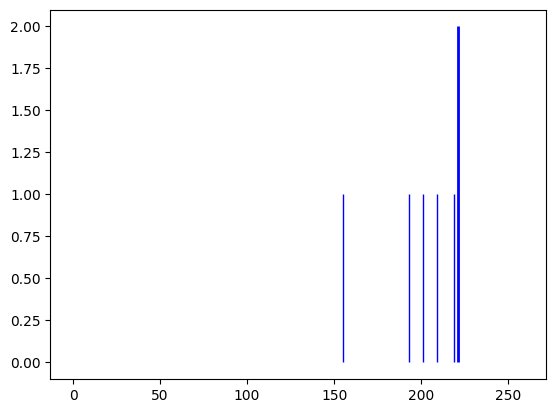

Num: 2254
Spectrum num=2254, size=162, matched=4, frac=0.024691358024691357
Spectrum num=2254, size=162, matched=18, frac=0.1111111111111111


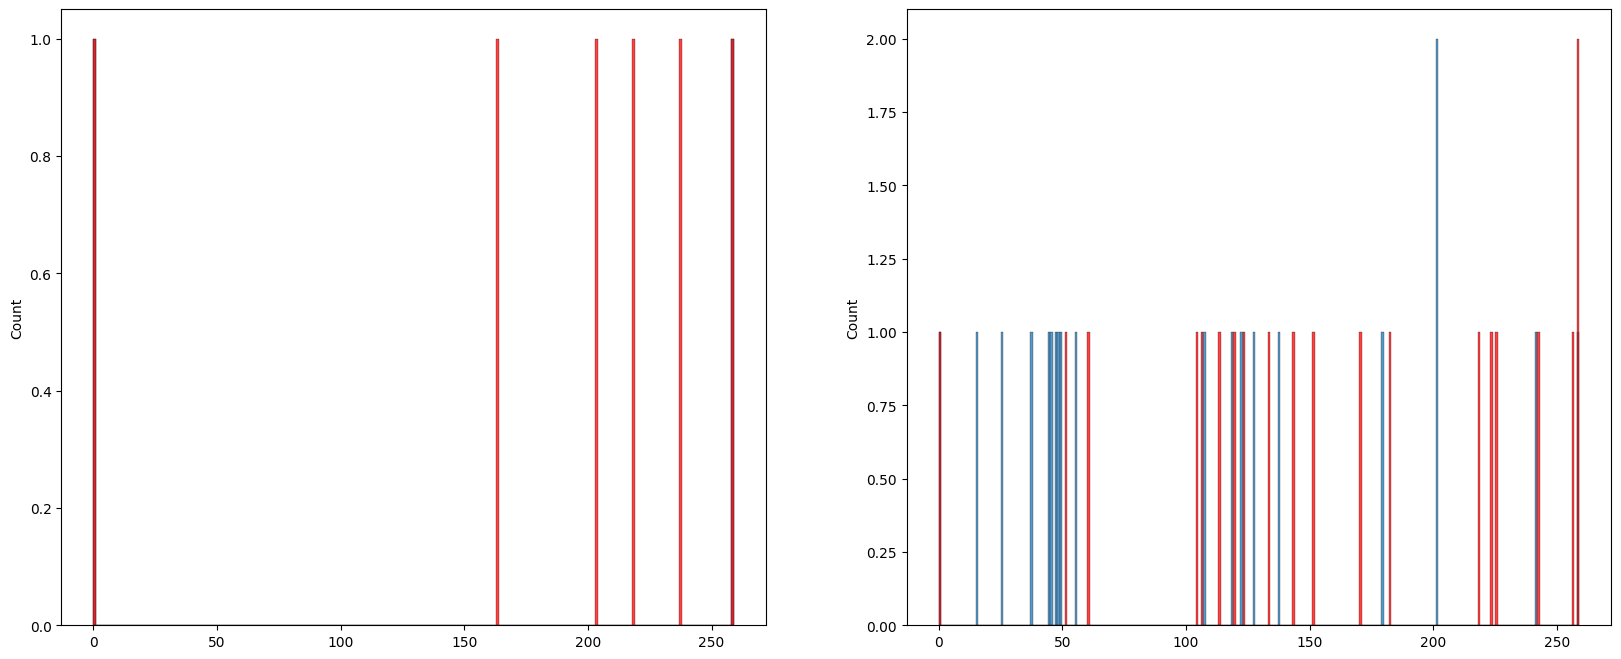

<Figure size 1200x800 with 0 Axes>

Ladders
{34, 37, 136, 41, 51}
Filtering ladders by error


100%|██████████| 20/20 [00:46<00:00,  2.35s/it]


Actual number of ladders: 0 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Num: 2274
Spectrum num=2274, size=185, matched=15, frac=0.08108108108108109
Spectrum num=2274, size=185, matched=34, frac=0.1837837837837838


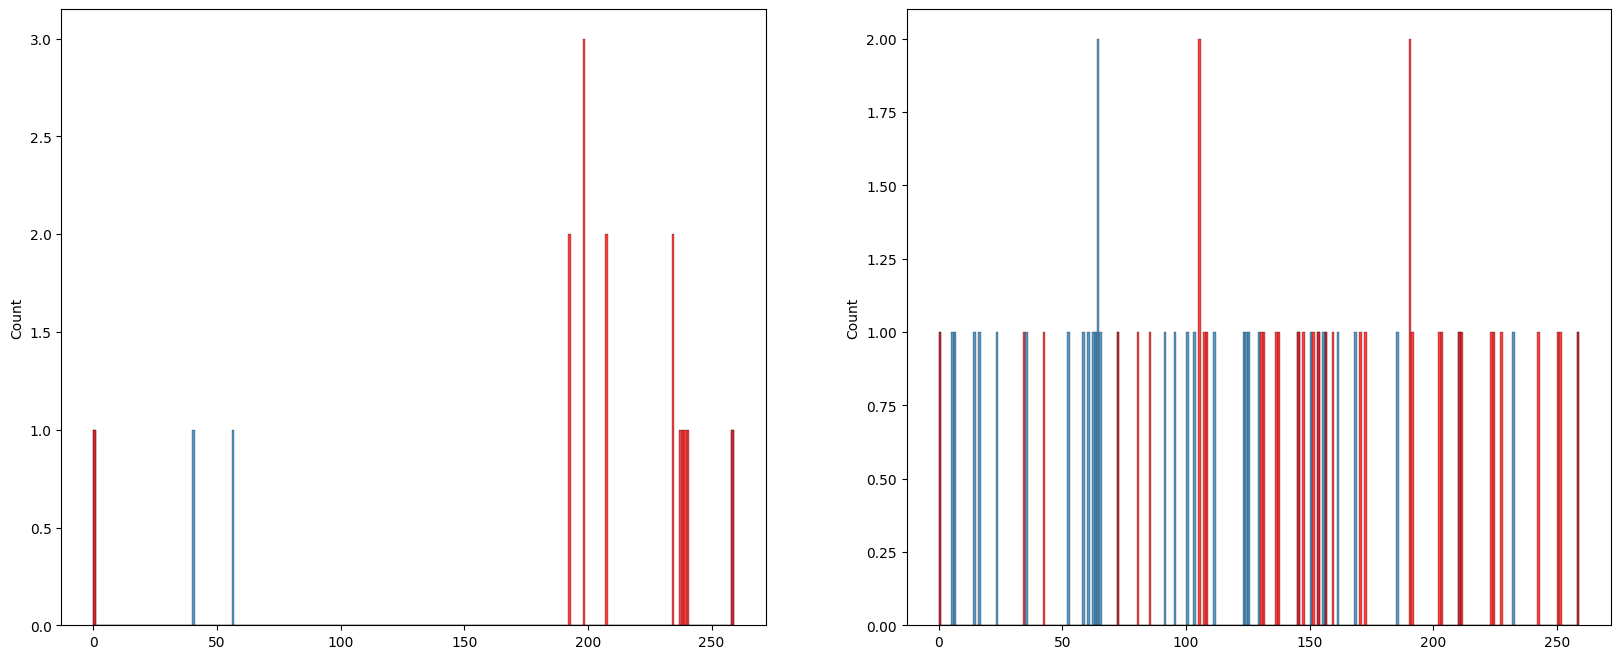

<Figure size 1200x800 with 0 Axes>

Ladders
{163, 5, 46, 146, 23, 30}
{1, 3, 167, 9, 18}
{4, 71, 51, 84, 183}
Filtering ladders by error


100%|██████████| 20/20 [02:10<00:00,  6.54s/it]


Actual number of ladders: 0 Distribution: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Actual length of ladders: [] Distribution: [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
Num: 2309
Spectrum num=2309, size=150, matched=74, frac=0.49333333333333335
Spectrum num=2309, size=150, matched=33, frac=0.22


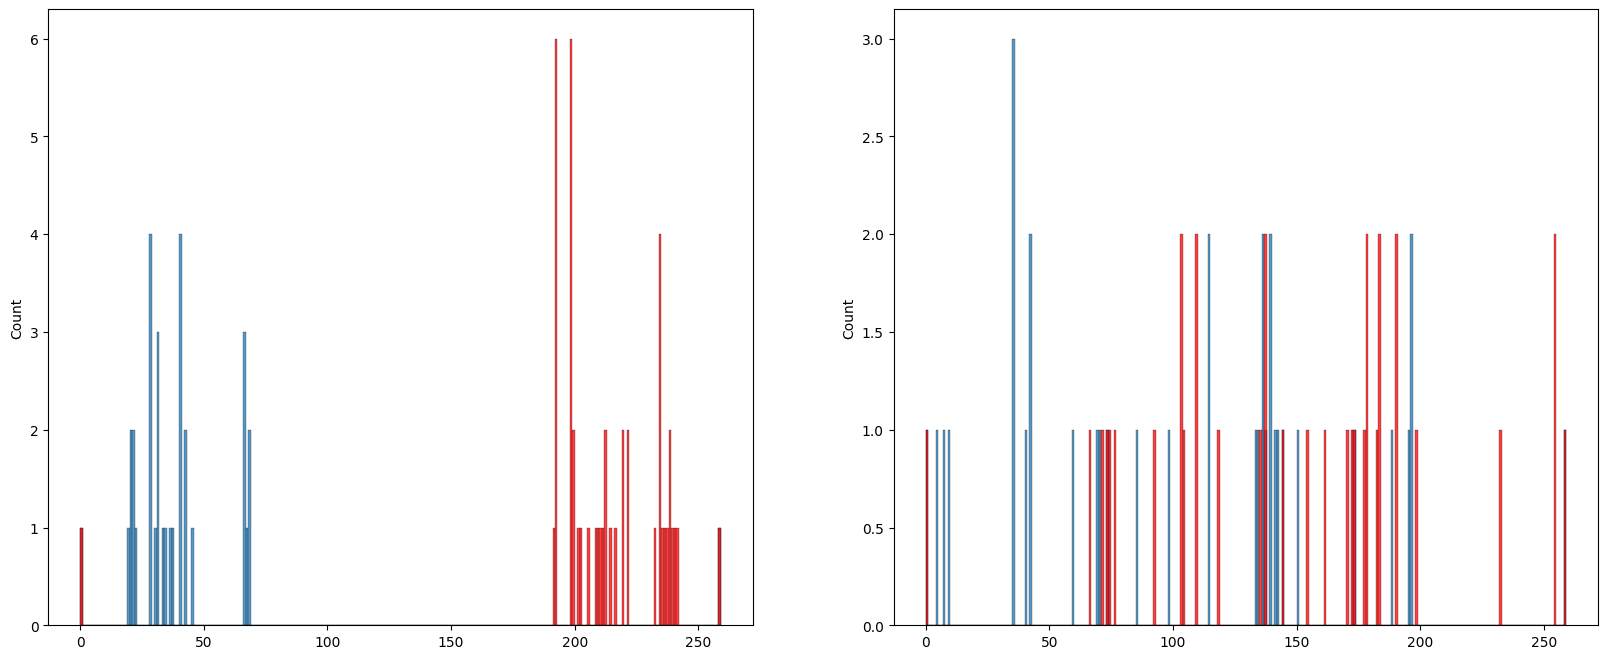

<Figure size 1200x800 with 0 Axes>

Ladders
{128, 1, 2, 131, 3, 5, 6, 7, 8, 10, 11, 12, 13, 142, 14, 18, 20, 25, 28, 32, 34, 39, 47, 53, 74, 80, 107, 108, 110, 119}
{0, 4, 135, 136, 9, 141, 16, 24, 27, 29, 37, 40, 41, 42, 49, 55, 56, 61, 63, 66, 69, 92, 100, 117, 126}
{64, 129, 65, 26, 134, 137, 48, 51, 115, 118, 122, 59, 94, 127}
{98, 36, 105, 76, 146, 84}
Filtering ladders by error


100%|██████████| 20/20 [02:59<00:00,  8.96s/it]

Actual number of ladders: 4 Distribution: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [20, 15, 9, 6] Distribution: [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


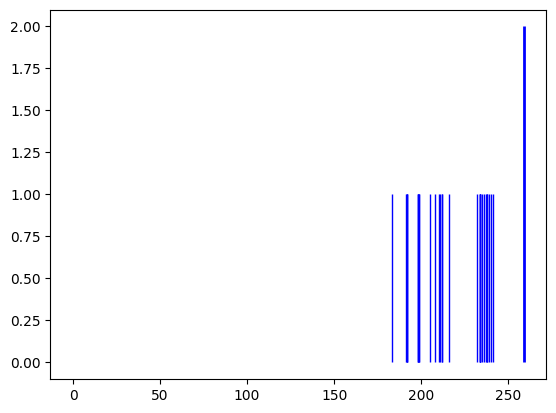

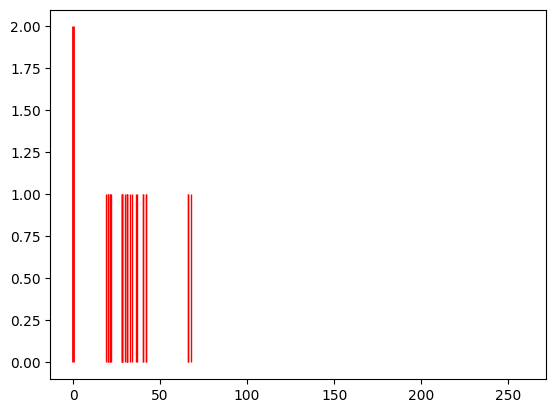

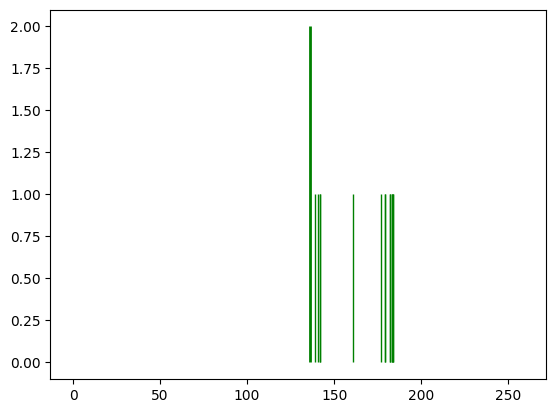

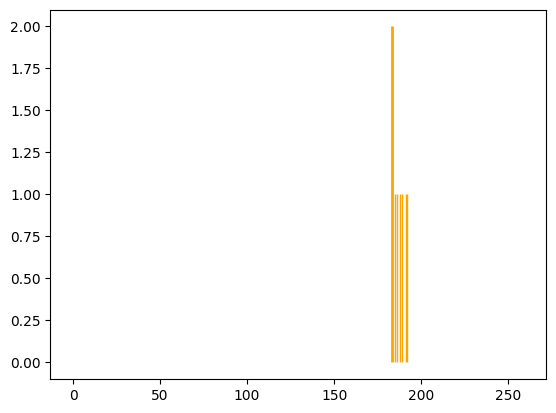

Num: 2311
Spectrum num=2311, size=380, matched=111, frac=0.29210526315789476
Spectrum num=2311, size=380, matched=69, frac=0.18157894736842106


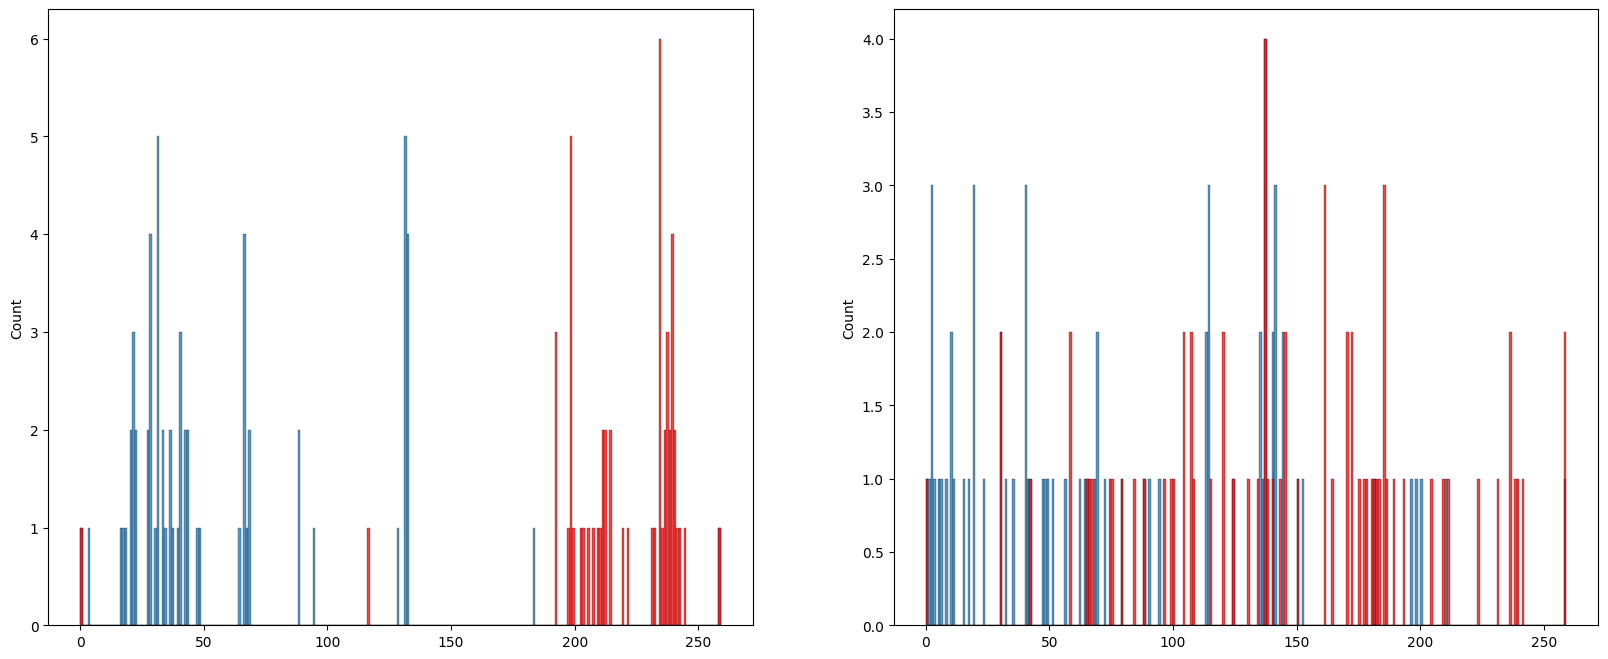

<Figure size 1200x800 with 0 Axes>

Ladders
{1, 258, 2, 3, 5, 4, 7, 8, 137, 9, 139, 12, 13, 10, 18, 20, 149, 277, 24, 281, 30, 31, 35, 36, 164, 167, 168, 41, 298, 171, 51, 318, 63, 64, 193, 192, 325, 214, 89, 218, 94, 98, 100, 108, 238, 253}
{256, 0, 262, 6, 134, 11, 141, 15, 19, 25, 27, 158, 288, 32, 33, 37, 40, 46, 175, 48, 49, 50, 54, 182, 186, 187, 60, 321, 66, 70, 72, 74, 332, 79, 210, 83, 84, 85, 217, 232, 241}
{230, 135, 105, 143, 145, 309, 57, 62}
{65, 68, 28, 14, 78, 16, 245, 348, 155, 124}
{131, 228, 200, 43, 81, 308, 117, 90}
{161, 169, 45, 206, 112, 247}
{165, 326, 359, 293, 142, 152}
{34, 204, 275, 372, 279}
{294, 329, 274, 53, 121, 29}
{352, 330, 176, 150, 87, 378}
{136, 266, 80, 311, 316}
{322, 22, 249, 58, 379}
{183, 216, 153, 283, 61}
{132, 260, 336, 23, 122, 123}
{239, 113, 211, 116, 184}
{229, 234, 138, 109, 314}
{231, 361, 88, 346, 220}
Filtering ladders by error


100%|██████████| 20/20 [23:29<00:00, 70.49s/it]

Actual number of ladders: 5 Distribution: [0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
Actual length of ladders: [28, 25, 7, 7, 5] Distribution: [0 0 0 5 0 0 6 0 0 0 0 5 0 0 0 0 0 0 0 0]


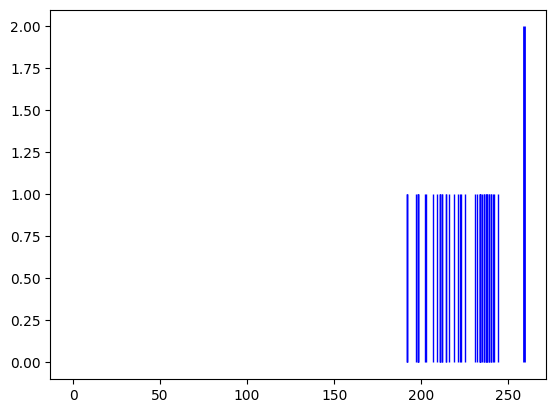

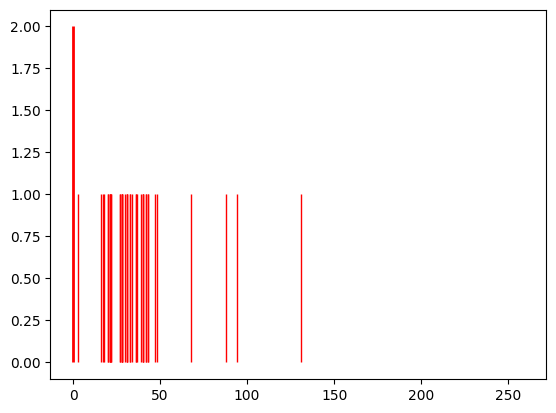

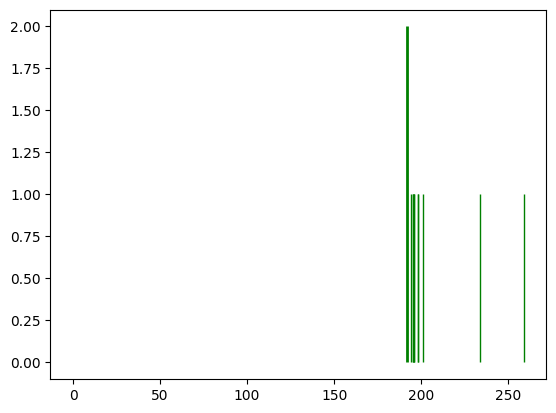

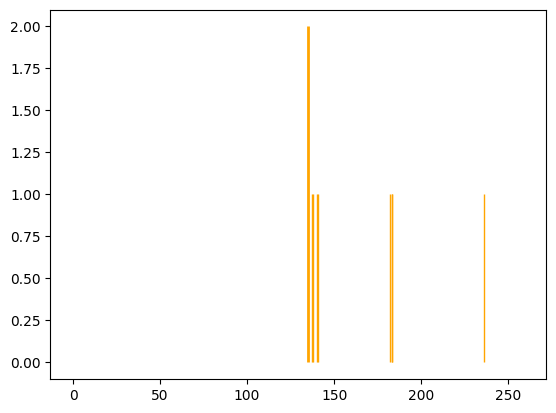

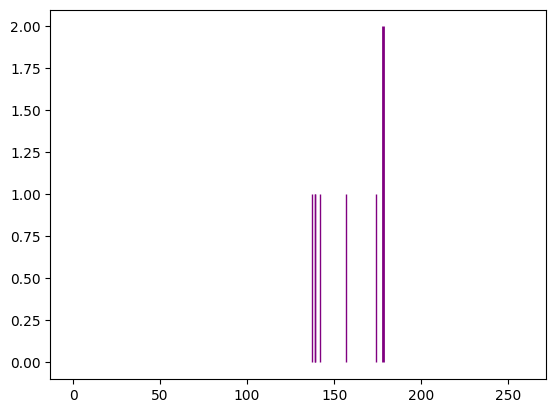

Num: 2314
Spectrum num=2314, size=467, matched=145, frac=0.31049250535331907
Spectrum num=2314, size=467, matched=93, frac=0.19914346895074947


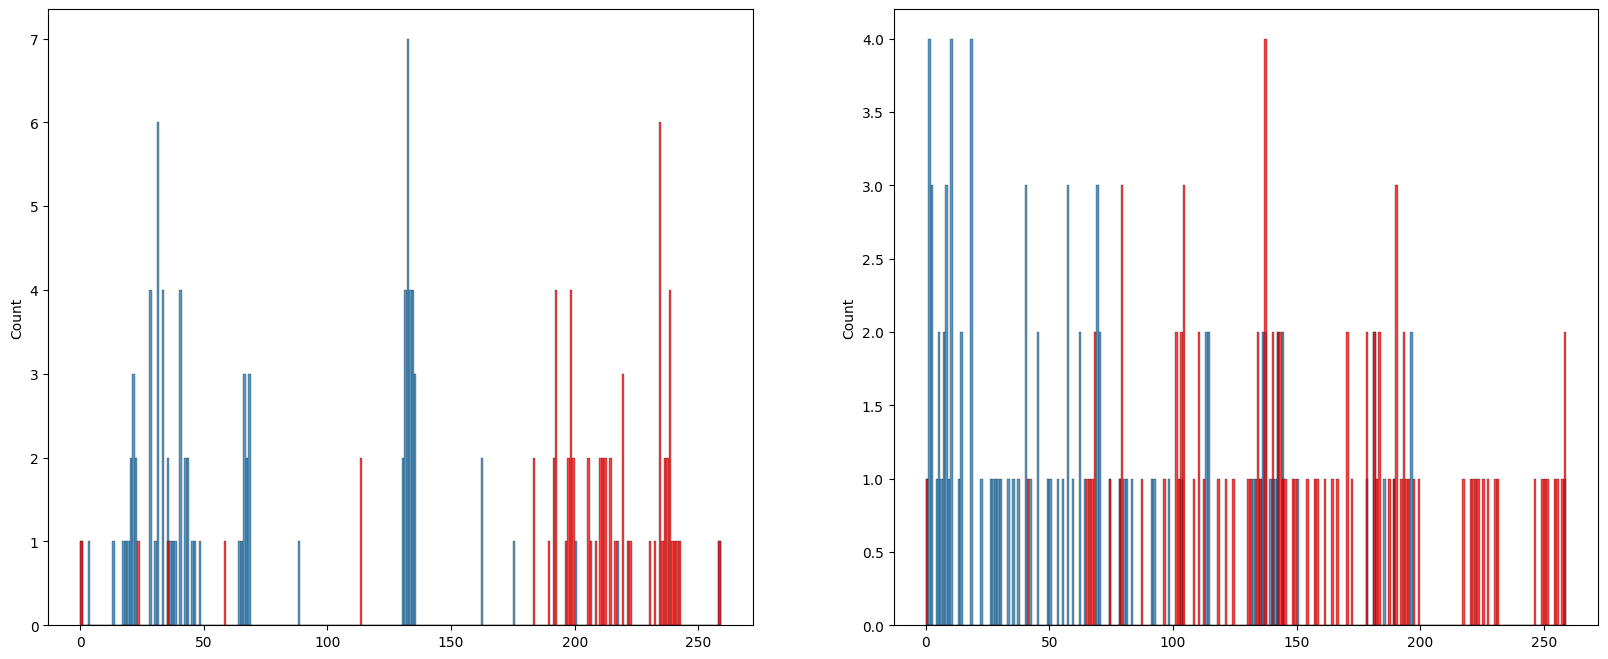

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 388, 7, 8, 139, 20, 25, 410, 28, 30, 287, 34, 37, 168, 40, 298, 46, 176, 434, 52, 55, 183, 57, 59, 63, 320, 450, 68, 198, 77, 83, 86, 91, 223, 96, 365, 109, 239, 251, 114, 254, 250, 379, 253, 126}
{128, 1, 258, 3, 2, 5, 6, 4, 9, 137, 11, 12, 13, 10, 15, 272, 14, 19, 405, 21, 153, 32, 33, 289, 291, 36, 171, 48, 304, 54, 56, 60, 190, 65, 196, 206, 90, 348, 104, 108, 238, 367, 112, 374, 119, 120, 127}
{166, 169, 42, 75, 43, 111, 208, 347, 92, 222}
{225, 102, 360, 41, 16, 53, 87}
{67, 103, 136, 173, 45, 79, 244}
{97, 261, 73, 74, 44, 80, 50, 408, 26, 27, 124, 62}
{164, 297, 268, 207, 144, 191}
{161, 227, 390, 233, 170, 398}
{433, 403, 182, 58, 156, 31}
{64, 226, 465, 51, 314}
{38, 424, 18, 23, 121}
{66, 70, 331, 270, 280}
{353, 420, 155, 316, 29}
{318, 453, 229, 425, 382}
{98, 296, 363, 459, 78, 189}
{200, 47, 432, 61, 319}
{323, 332, 142, 334, 188}
{163, 452, 373, 22, 215, 184}
{448, 359, 106, 146, 186, 125}
Filtering ladders by error


100%|██████████| 20/20 [33:42<00:00, 101.12s/it]

Actual number of ladders: 6 Distribution: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
Actual length of ladders: [28, 28, 7, 6, 6, 6] Distribution: [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 5 0 0]


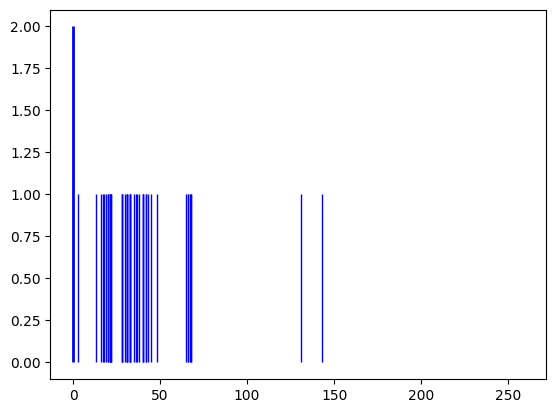

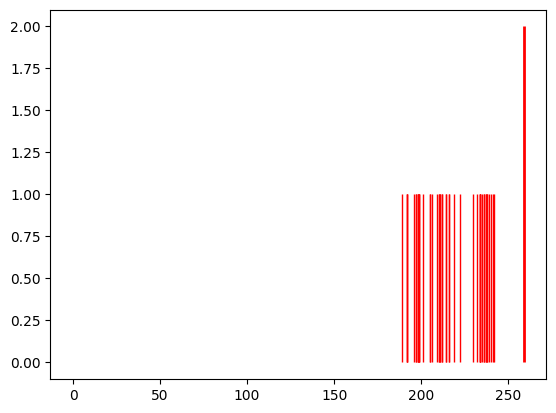

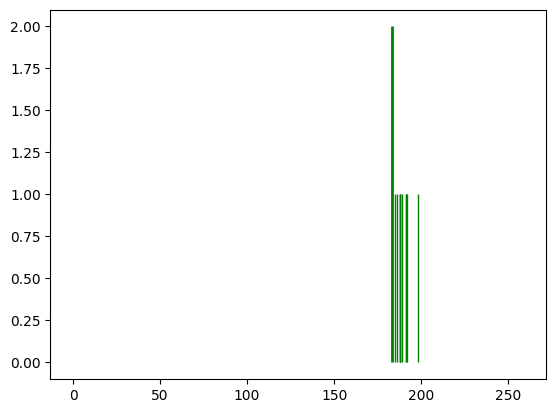

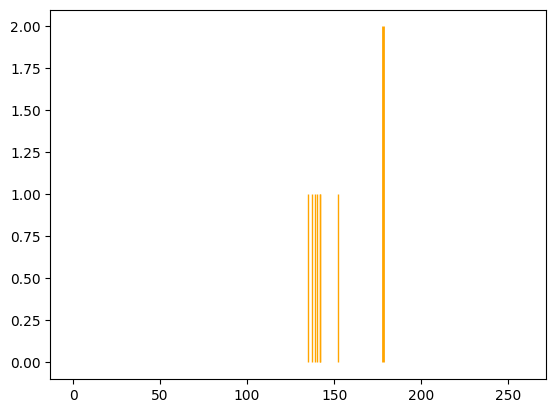

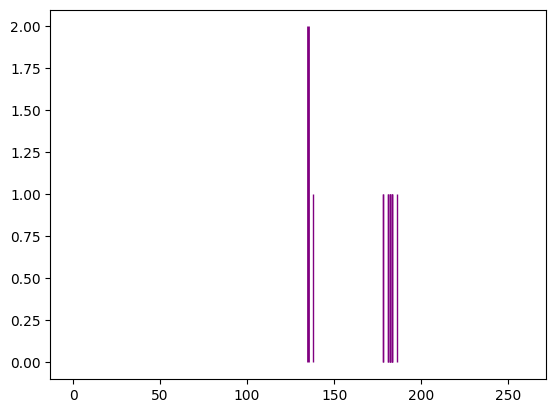

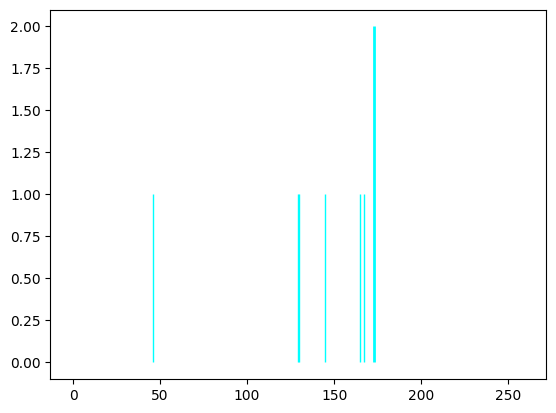

Num: 2318
Spectrum num=2318, size=764, matched=147, frac=0.19240837696335078
Spectrum num=2318, size=764, matched=145, frac=0.18979057591623036


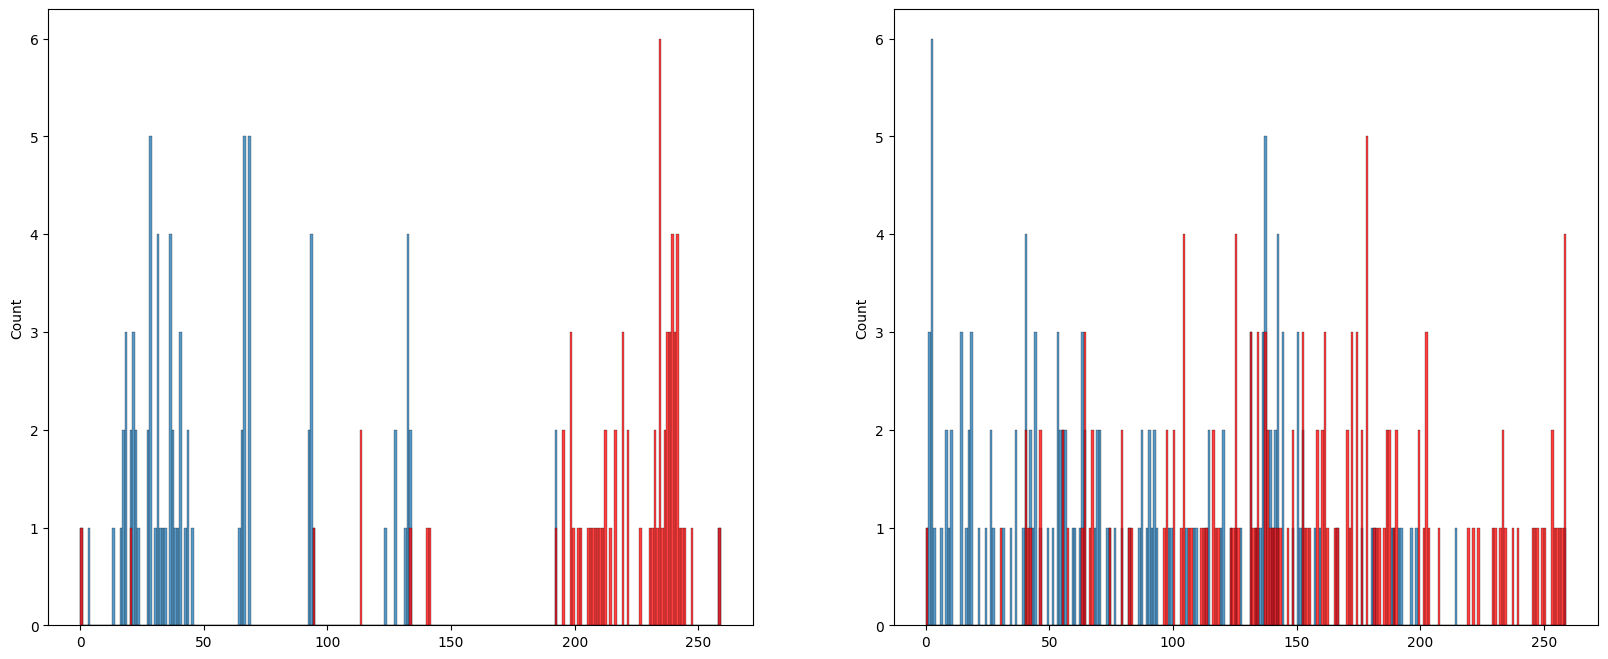

<Figure size 1200x800 with 0 Axes>

Ladders
{128, 1, 2, 131, 255, 4, 6, 263, 264, 8, 7, 11, 5, 134, 15, 3, 147, 21, 23, 24, 25, 31, 40, 169, 47, 50, 307, 62, 63, 453, 78, 79, 210, 86, 347, 100, 103, 361, 233, 110, 381, 125, 127}
{0, 136, 9, 650, 10, 269, 17, 19, 20, 149, 22, 278, 28, 29, 670, 32, 34, 292, 38, 167, 681, 42, 43, 46, 174, 48, 51, 311, 439, 57, 56, 440, 188, 66, 69, 200, 202, 333, 209, 82, 83, 469, 598, 343, 90, 93, 107, 620, 623, 368, 250, 635}
{64, 577, 483, 35, 70, 199, 489, 59, 187, 13, 184, 254, 760, 27, 605, 30, 543}
{288, 65, 322, 516, 599, 519, 142, 80, 18, 178, 54, 151, 313, 346, 219, 574}
{385, 33, 450, 68, 706, 391, 392, 203, 532, 731}
{130, 195, 36, 112, 305, 181, 316, 285}
{99, 356, 41, 81, 597, 246, 341, 156}
{420, 229, 552, 746, 77, 14, 143, 159}
{257, 12, 109, 334, 282, 124, 383}
{737, 741, 619, 652, 590, 691, 600}
{163, 515, 135, 714, 538, 118, 186}
{609, 67, 74, 331, 75, 115, 437, 53, 60}
{295, 424, 686, 111, 497, 274, 639}
{227, 325, 550, 433, 695, 126, 375}
{491, 685, 500, 310, 150, 669, 

100%|██████████| 20/20 [2:03:07<00:00, 369.40s/it]  

Actual number of ladders: 6 Distribution: [0 2 2 1 0 0 0 0 0 0 0 1 0 0 0 0 2 1 0 1]
Actual length of ladders: [31, 28, 14, 9, 8, 8] Distribution: [0 6 7 9 0 0 0 0 0 0 0 6 0 0 0 0 5 5 0 9]


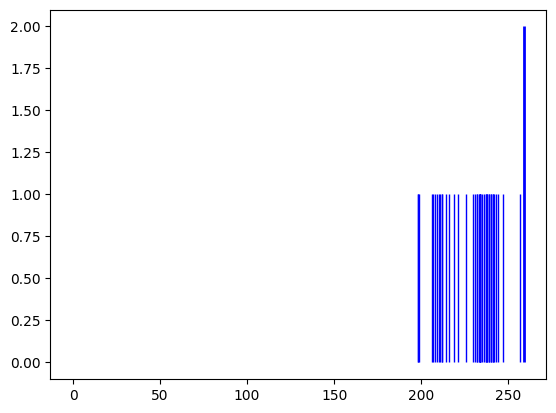

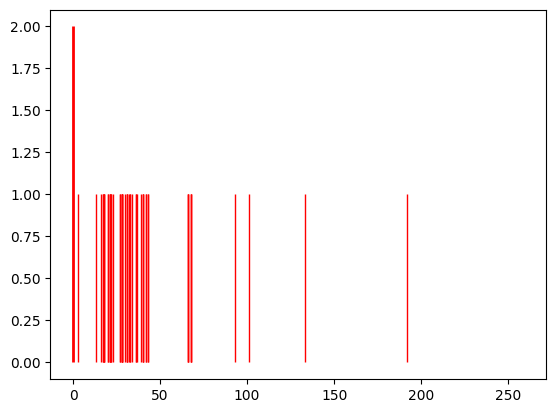

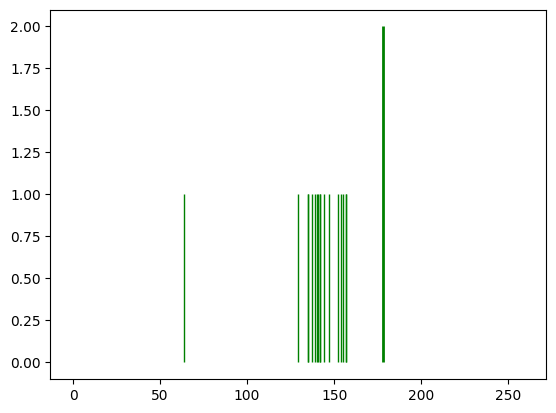

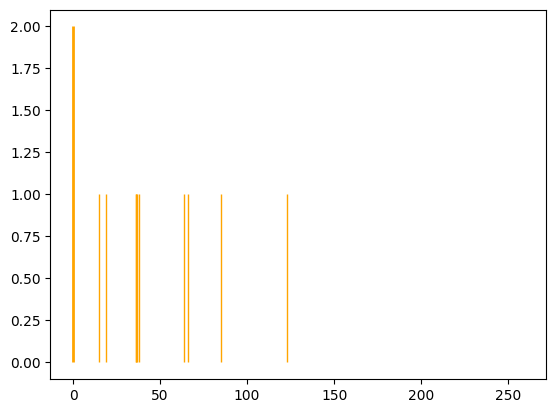

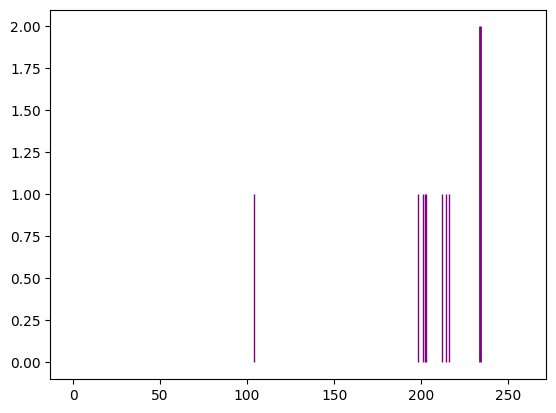

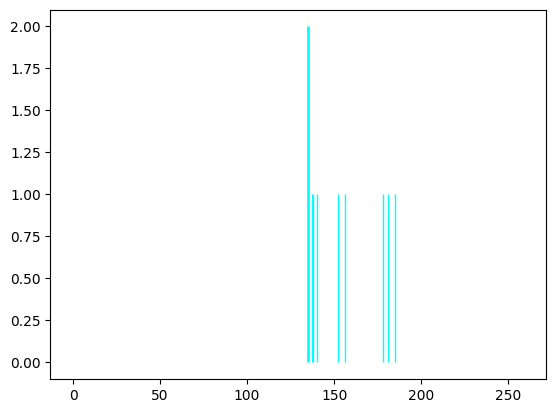

Num: 2323
Spectrum num=2323, size=450, matched=144, frac=0.32
Spectrum num=2323, size=450, matched=90, frac=0.2


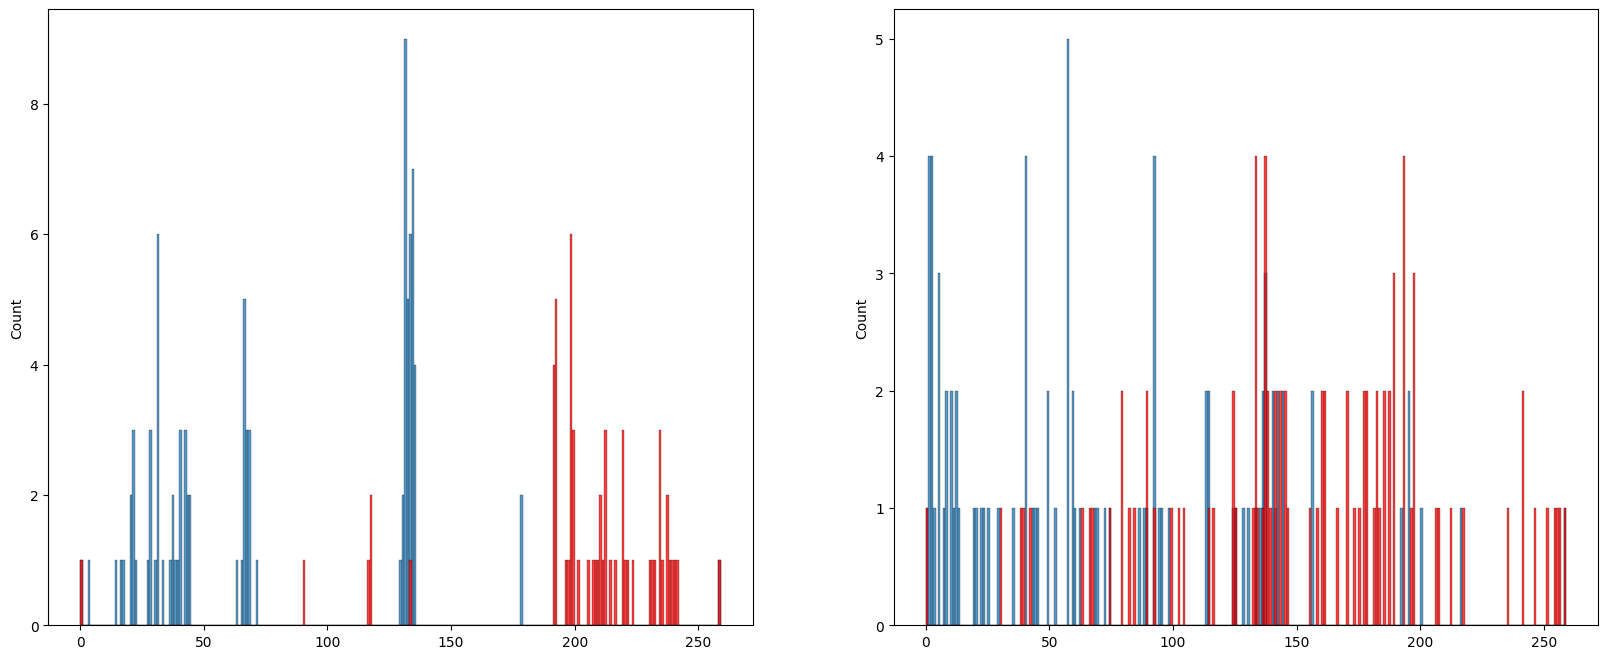

<Figure size 1200x800 with 0 Axes>

Ladders
{1, 130, 131, 129, 261, 8, 138, 140, 19, 151, 25, 153, 27, 29, 157, 33, 162, 39, 168, 425, 298, 43, 175, 304, 49, 48, 53, 438, 183, 55, 57, 309, 189, 195, 68, 74, 205, 78, 341, 86, 88, 89, 120, 350, 95, 99, 230, 104, 109, 239, 113, 117, 376, 378, 255}
{0, 2, 259, 4, 5, 3, 7, 6, 9, 10, 11, 267, 16, 18, 274, 21, 22, 23, 281, 31, 160, 161, 35, 167, 45, 178, 50, 184, 56, 59, 66, 203, 77, 79, 82, 212, 347, 91, 220, 96, 101, 359, 235, 245, 252, 381, 383}
{36, 38, 105, 362, 204, 173, 141, 237, 80}
{128, 134, 295, 103, 166, 200, 75, 214, 249}
{258, 356, 262, 363, 369, 20, 380}
{32, 388, 13, 111, 209, 115, 87, 316, 63}
{64, 73, 335, 306, 84, 61}
{98, 100, 229, 231, 44, 12, 305, 52, 85}
{65, 421, 81, 152, 90, 92}
{408, 360, 439, 24, 127}
{417, 70, 364, 429, 26}
{324, 329, 170, 277, 282}
{67, 37, 135, 240, 222}
{41, 395, 366, 15, 119, 344}
{353, 69, 47, 279, 122}
{227, 390, 307, 284, 351}
{194, 302, 432, 123, 188}
{354, 322, 102, 42, 269, 17}
{28, 348, 187, 124, 318}
Filtering ladders by 

100%|██████████| 20/20 [38:58<00:00, 116.93s/it]

Actual number of ladders: 6 Distribution: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [34, 29, 9, 7, 6, 5] Distribution: [0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


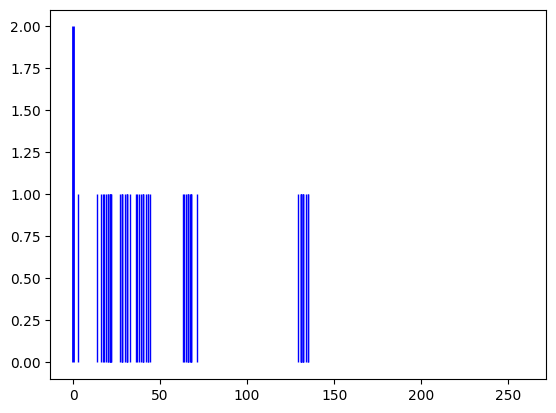

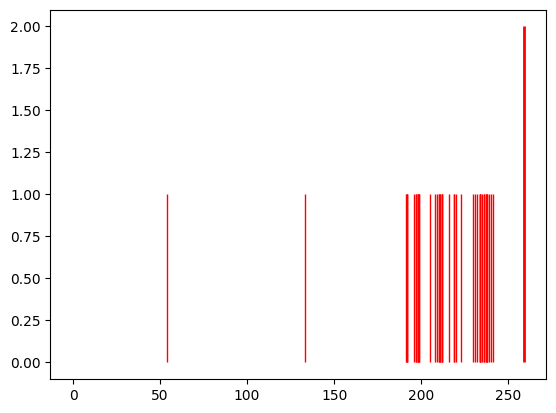

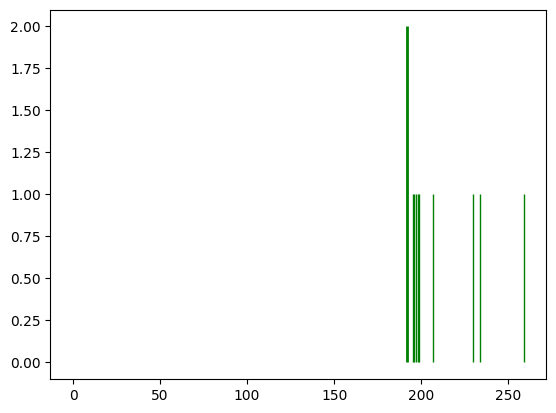

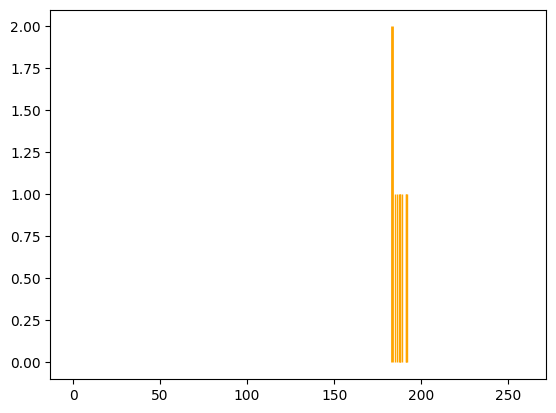

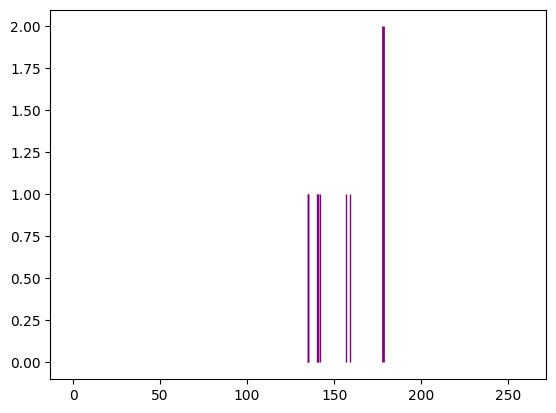

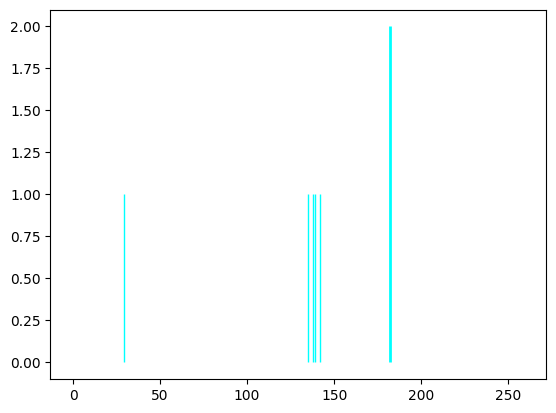

Num: 2326
Spectrum num=2326, size=483, matched=154, frac=0.3188405797101449
Spectrum num=2326, size=483, matched=86, frac=0.17805383022774326


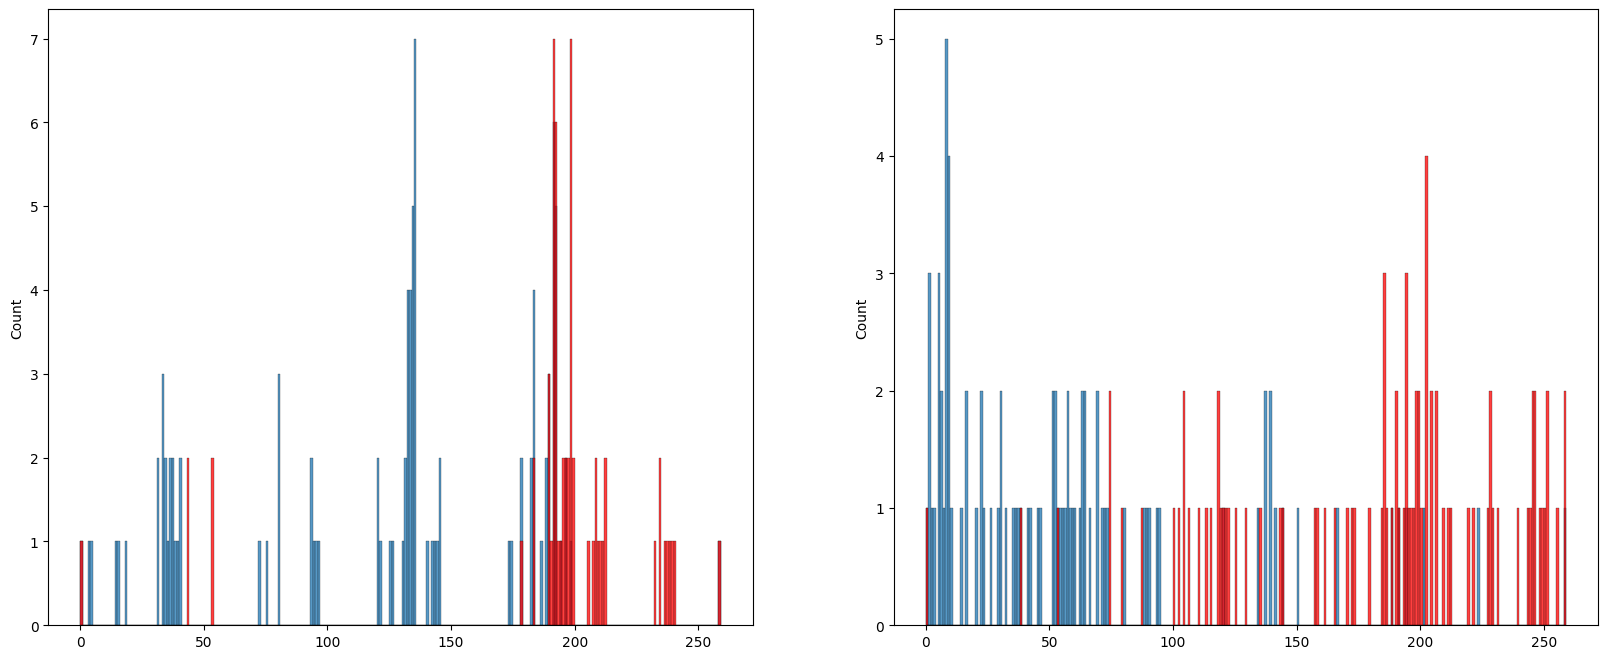

<Figure size 1200x800 with 0 Axes>

Ladders
{1, 2, 3, 130, 5, 257, 255, 8, 10, 140, 14, 15, 271, 19, 407, 26, 156, 286, 158, 287, 36, 40, 44, 45, 47, 48, 178, 52, 53, 311, 192, 194, 67, 71, 213, 91, 357, 101, 111, 240, 115, 245, 376, 125, 127}
{260, 17, 23, 413, 288, 289, 419, 37, 38, 39, 51, 436, 180, 439, 440, 61, 62, 63, 193, 197, 326, 331, 218, 93, 350, 98, 230, 232, 117}
{0, 4, 6, 7, 134, 9, 265, 11, 12, 13, 18, 148, 21, 25, 27, 28, 29, 30, 31, 32, 33, 161, 35, 42, 43, 301, 46, 50, 64, 65, 66, 68, 78, 335, 80, 465, 82, 83, 89, 482, 360, 112, 370, 118, 123}
{132, 293, 136, 236, 114, 210, 284, 415}
{225, 234, 155, 77, 151, 281, 154, 219, 159}
{290, 291, 263, 73, 458, 373, 253}
{323, 424, 243, 280, 346, 60}
{163, 327, 425, 427, 237, 143}
{34, 16, 24, 57, 283, 380}
{297, 299, 462, 309, 183, 409}
{320, 328, 300, 460, 209, 190}
{463, 244, 119, 250, 187}
{481, 70, 142, 211, 150}
{385, 106, 267, 276, 55, 222}
{166, 139, 396, 367, 239}
{235, 272, 435, 343, 414}
{321, 198, 423, 59, 315}
{428, 270, 302, 56, 383}
Filtering ladd

100%|██████████| 20/20 [35:16<00:00, 105.83s/it]

Actual number of ladders: 4 Distribution: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [25, 23, 8, 6] Distribution: [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


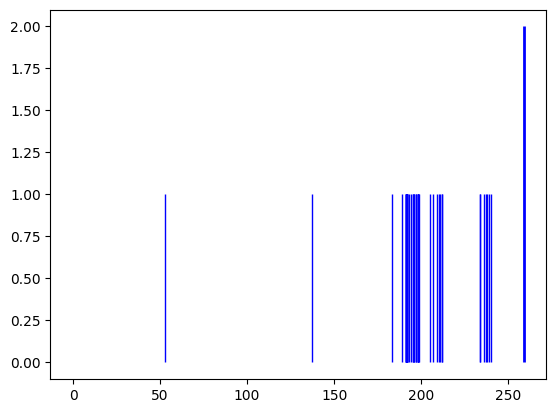

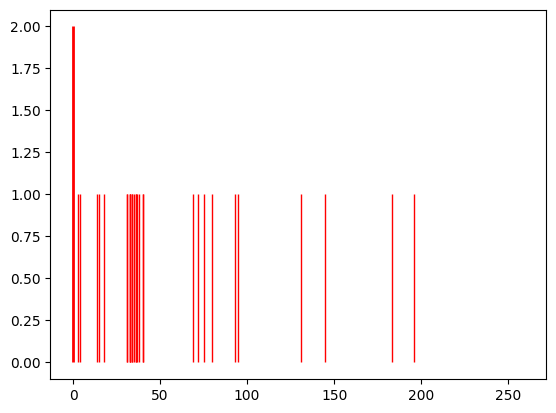

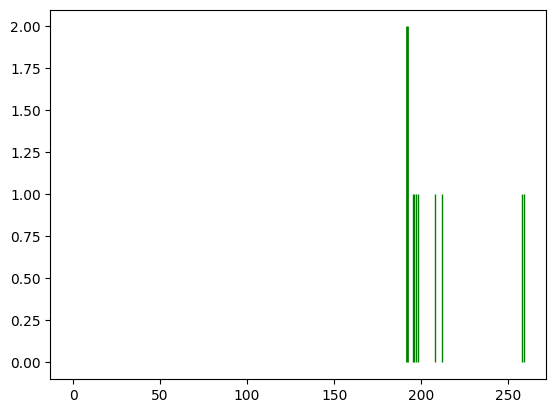

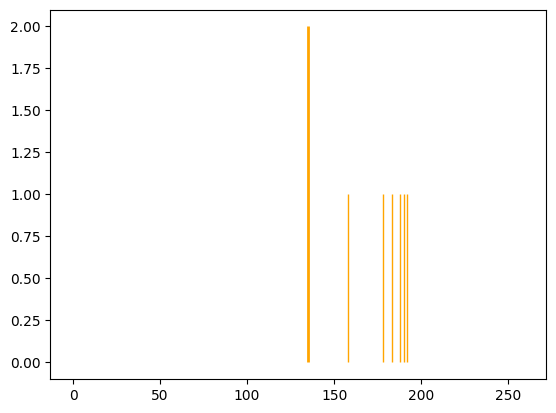

Num: 2329
Spectrum num=2329, size=483, matched=122, frac=0.2525879917184265
Spectrum num=2329, size=483, matched=83, frac=0.17184265010351968


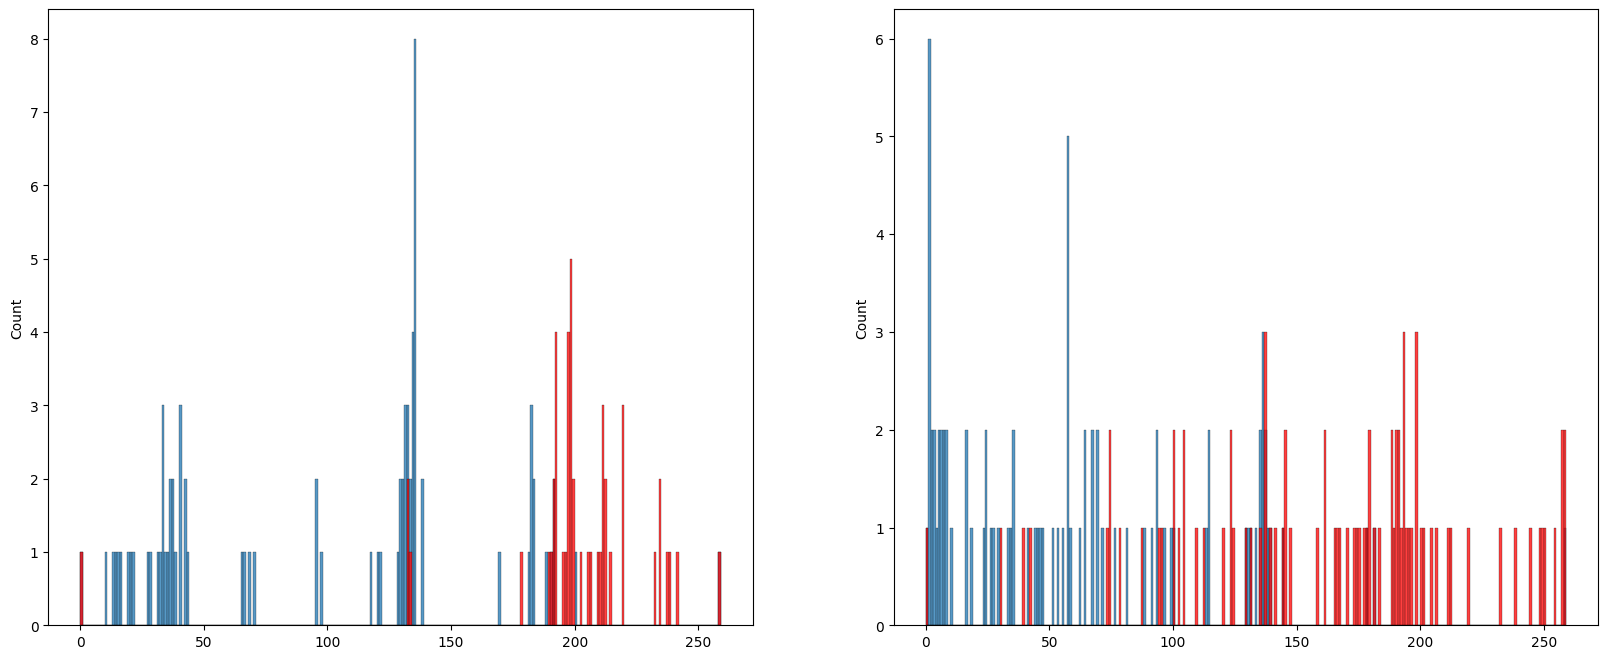

<Figure size 1200x800 with 0 Axes>

Ladders
{257, 4, 139, 142, 143, 17, 18, 19, 279, 282, 411, 155, 285, 158, 287, 419, 421, 169, 180, 53, 182, 436, 318, 65, 66, 72, 200, 202, 77, 464, 340, 344, 477, 351, 480, 358, 106, 107, 108, 236, 373, 374, 120, 249}
{0, 1, 130, 5, 6, 10, 396, 141, 13, 271, 20, 404, 22, 407, 151, 25, 281, 410, 30, 31, 32, 33, 35, 36, 166, 39, 40, 42, 44, 45, 301, 47, 50, 310, 64, 449, 320, 195, 452, 75, 205, 82, 83, 215, 472, 345, 88, 87, 92, 96, 100, 233, 240, 241, 122}
{97, 196, 101, 7, 8, 267, 123, 187, 15, 16, 51, 89, 27, 127}
{99, 41, 43, 12, 429, 14, 219, 80, 465, 210, 284, 150, 184, 58, 379, 316, 152, 94}
{2, 422, 73, 11, 177, 178, 21, 28, 191}
{225, 227, 165, 331, 332, 237, 335, 208, 186, 60}
{261, 391, 138, 299, 176, 372, 23, 24}
{153, 9, 367, 112, 113, 185, 62}
{292, 231, 364, 430, 437, 214}
{234, 175, 179, 308, 90, 61}
{224, 70, 298, 309, 85, 255}
{161, 81, 473, 157, 415}
{98, 67, 423, 398, 239}
{264, 86, 183, 29, 63}
{353, 393, 425, 79, 278}
{129, 163, 103, 463, 126}
{333, 338, 52, 54, 43

100%|██████████| 20/20 [35:15<00:00, 105.76s/it]

Actual number of ladders: 4 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
Actual length of ladders: [30, 28, 10, 8] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 6]


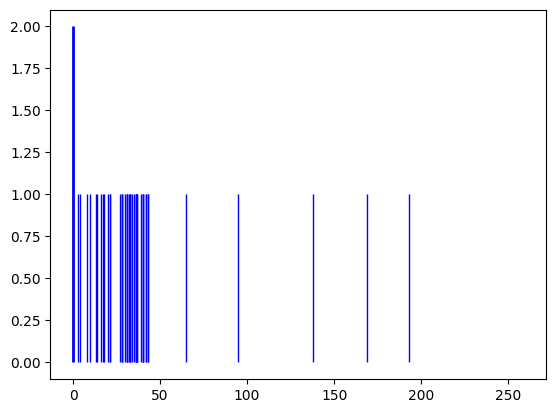

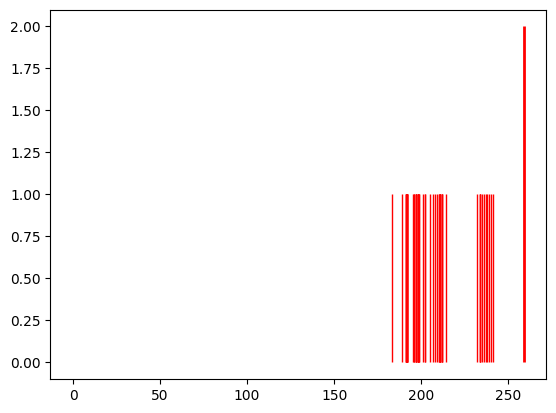

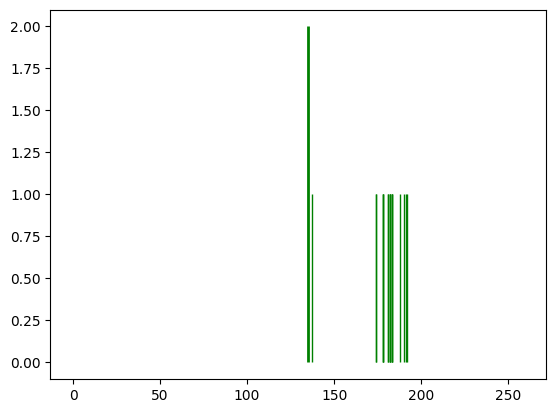

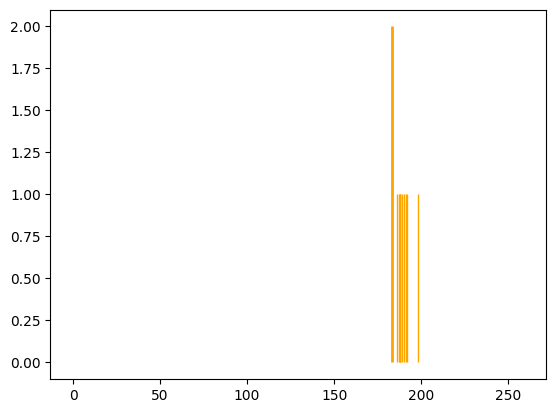

Num: 2332
Spectrum num=2332, size=483, matched=146, frac=0.3022774327122153
Spectrum num=2332, size=483, matched=79, frac=0.16356107660455488


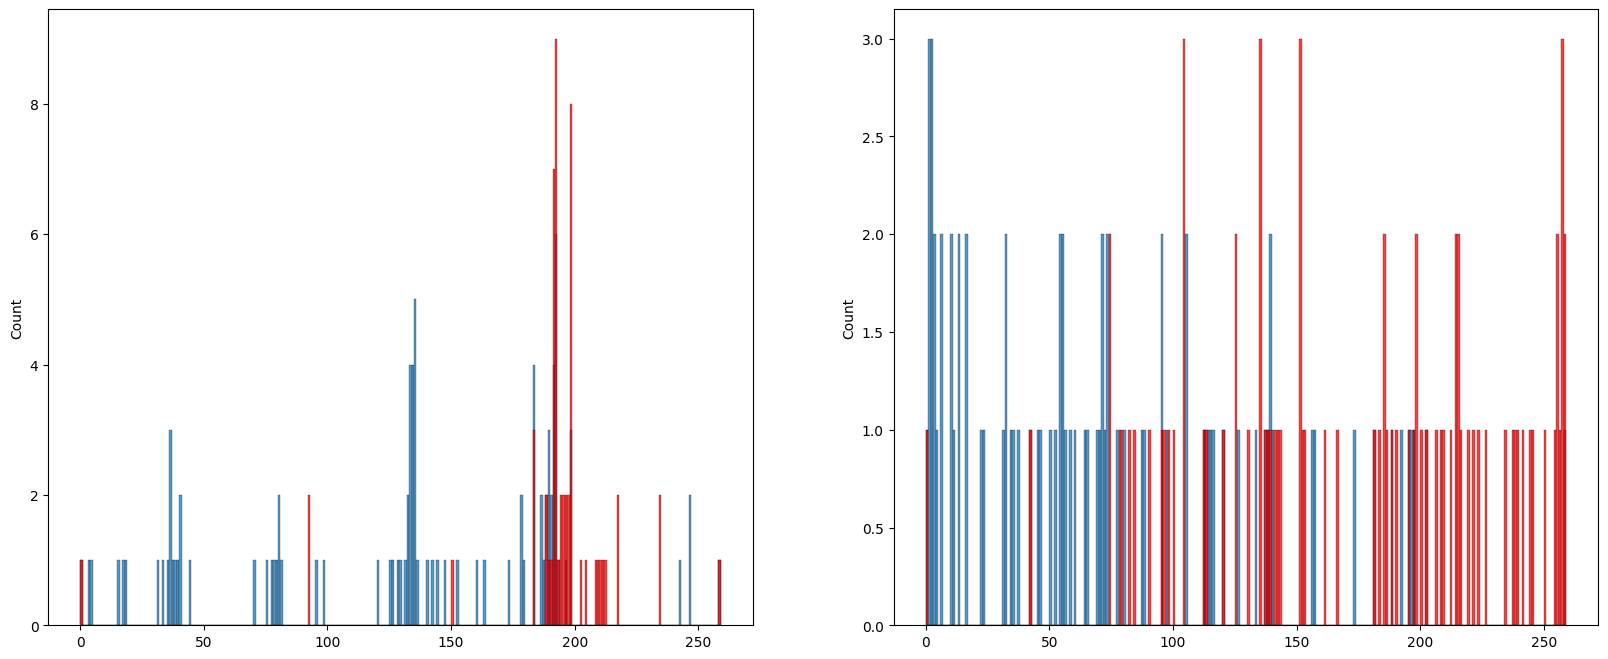

<Figure size 1200x800 with 0 Axes>

Ladders
{2, 3, 130, 5, 388, 8, 139, 15, 271, 17, 143, 19, 21, 26, 282, 28, 29, 31, 35, 294, 167, 43, 300, 308, 54, 55, 65, 67, 68, 69, 70, 71, 200, 73, 76, 86, 87, 88, 89, 93, 94, 357, 358, 111, 112, 381}
{0, 1, 4, 134, 11, 12, 18, 22, 286, 161, 34, 38, 45, 48, 178, 56, 58, 66, 202, 78, 83, 84, 217, 92, 228, 113, 123}
{36, 292, 455, 104, 74, 10, 14, 366, 20, 62}
{320, 359, 107, 434, 402, 406, 376, 156}
{193, 105, 241, 242, 274, 280, 284}
{256, 133, 201, 438, 214, 223}
{257, 227, 230, 393, 114, 243}
{135, 41, 203, 49, 118, 222}
{192, 163, 199, 171, 302, 218}
{423, 360, 330, 336, 211}
{225, 293, 404, 380, 414}
{389, 390, 103, 267, 339}
{428, 247, 216, 220, 415}
{232, 458, 42, 110, 303, 115, 23}
{384, 229, 13, 144, 306}
{168, 169, 369, 116, 473}
{426, 364, 268, 180, 316}
{452, 391, 234, 399, 85}
{265, 427, 213, 437, 126}
{149, 439, 59, 63, 447}
{99, 39, 170, 344, 157}
{37, 237, 335, 122, 27}
{7, 44, 80, 25, 475}
{194, 395, 183, 379, 412}
Filtering ladders by error


100%|██████████| 20/20 [37:03<00:00, 111.20s/it]

Actual number of ladders: 4 Distribution: [0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1]
Actual length of ladders: [35, 17, 7, 6] Distribution: [0 0 0 0 6 0 0 0 0 7 0 0 0 0 0 0 0 5 0 5]


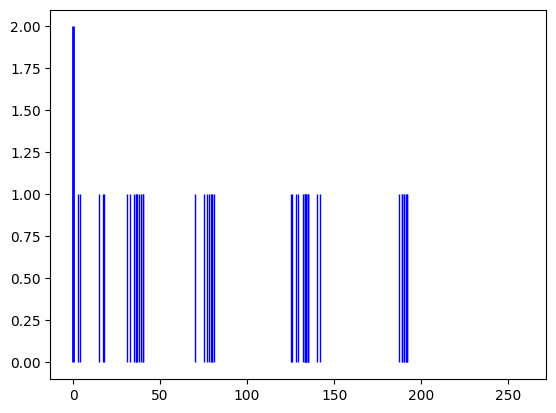

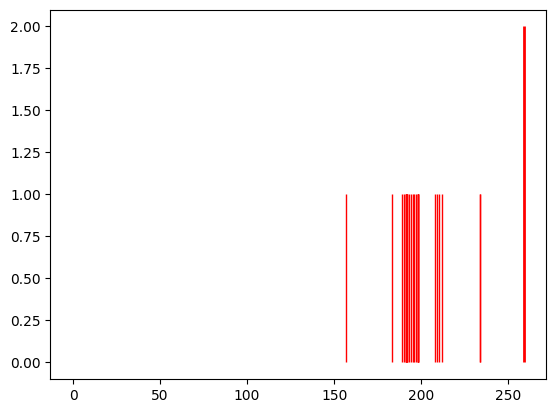

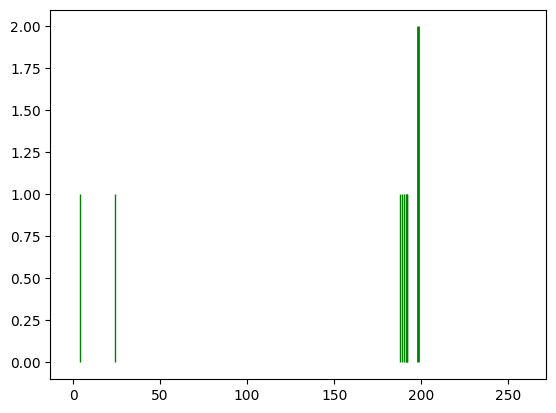

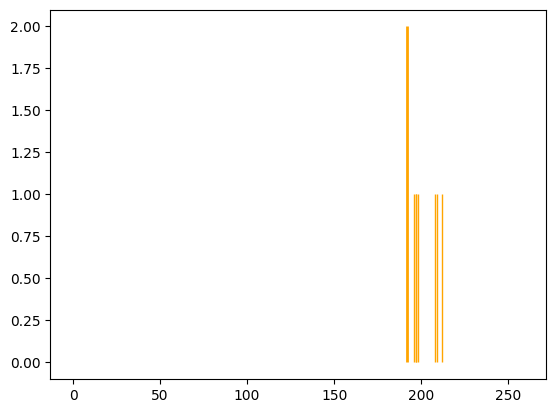

Num: 2345
Spectrum num=2345, size=483, matched=174, frac=0.36024844720496896
Spectrum num=2345, size=483, matched=81, frac=0.16770186335403728


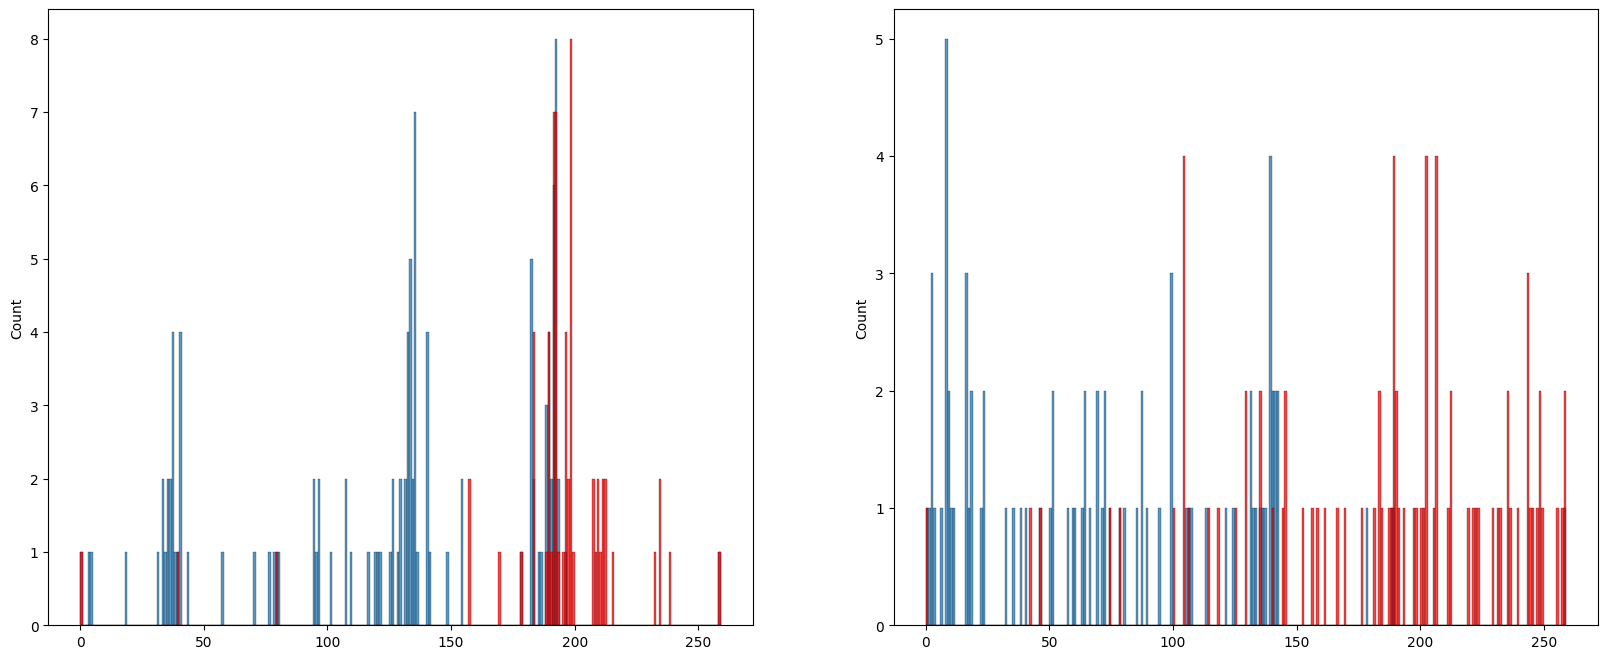

<Figure size 1200x800 with 0 Axes>

Ladders
{258, 267, 15, 16, 405, 278, 154, 39, 41, 44, 46, 47, 304, 306, 184, 59, 67, 73, 74, 87, 91, 221, 226, 358, 107, 111, 243, 118, 382}
{1, 2, 259, 4, 8, 12, 14, 143, 18, 19, 277, 21, 153, 29, 30, 31, 159, 292, 300, 45, 52, 55, 322, 66, 199, 72, 201, 75, 80, 85, 92, 95, 109, 374}
{32, 65, 34, 36, 5, 6, 38, 146, 20, 62, 90, 28, 126}
{224, 71, 10, 79, 51, 183, 26, 223}
{193, 355, 104, 363, 463, 433, 122, 286}
{162, 227, 102, 40, 202, 434, 84, 349, 94, 63}
{325, 77, 175, 272, 115, 182, 152, 318}
{288, 260, 69, 105, 244, 61}
{388, 473, 270, 83, 249, 284, 445}
{7, 205, 23, 117, 22, 215, 24}
{384, 11, 112, 468, 248, 123}
{33, 449, 137, 208, 381, 446}
{450, 386, 145, 113, 212}
{452, 454, 329, 457, 238, 279, 414}
{482, 387, 298, 17, 120}
{232, 299, 427, 241, 442}
{134, 359, 432, 82, 27}
{290, 271, 144, 156, 413}
{210, 213, 406, 121, 60}
{103, 136, 464, 176, 371}
{207, 50, 341, 25, 447}
Filtering ladders by error


100%|██████████| 20/20 [36:17<00:00, 108.87s/it]

Actual number of ladders: 6 Distribution: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [25, 16, 7, 7, 7, 6] Distribution: [0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


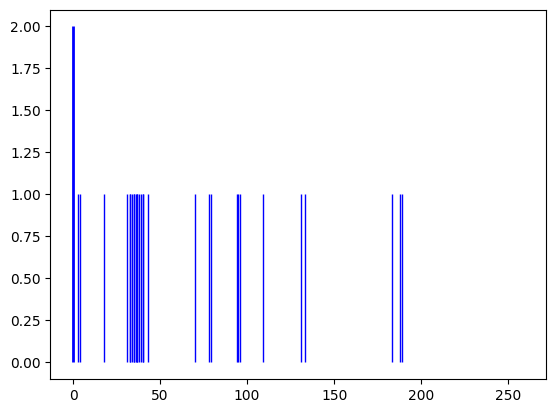

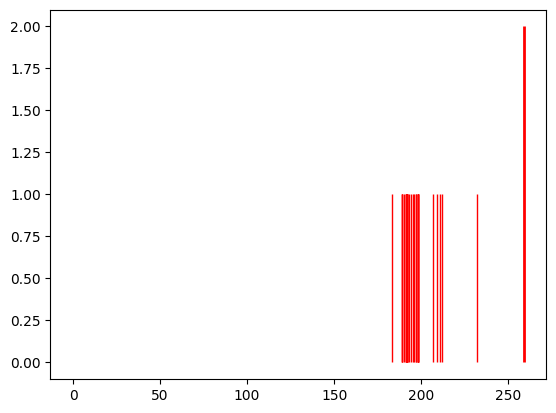

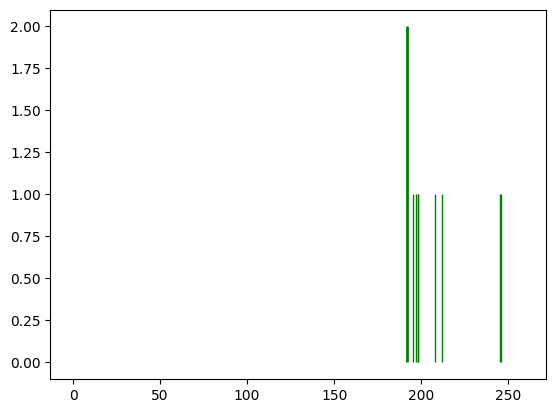

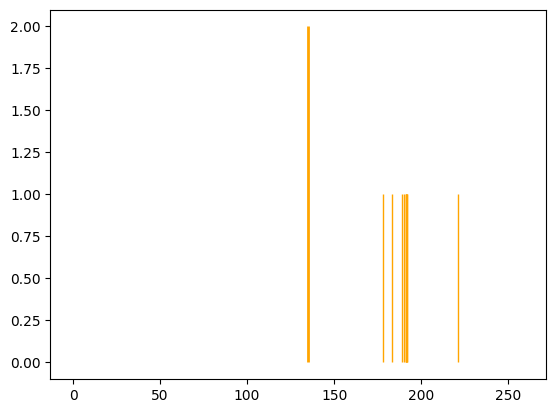

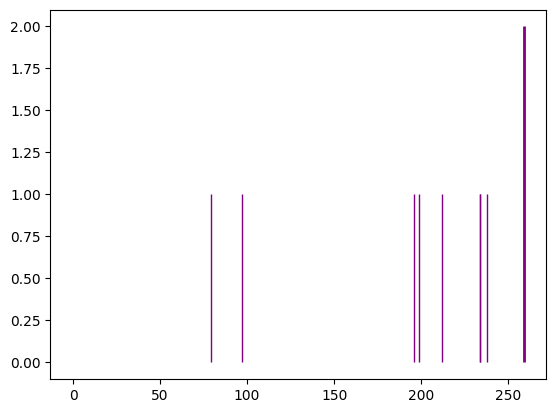

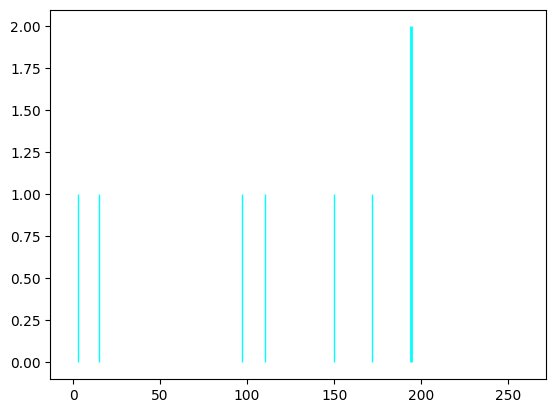

Num: 2408
Spectrum num=2408, size=98, matched=20, frac=0.20408163265306123
Spectrum num=2408, size=98, matched=17, frac=0.17346938775510204


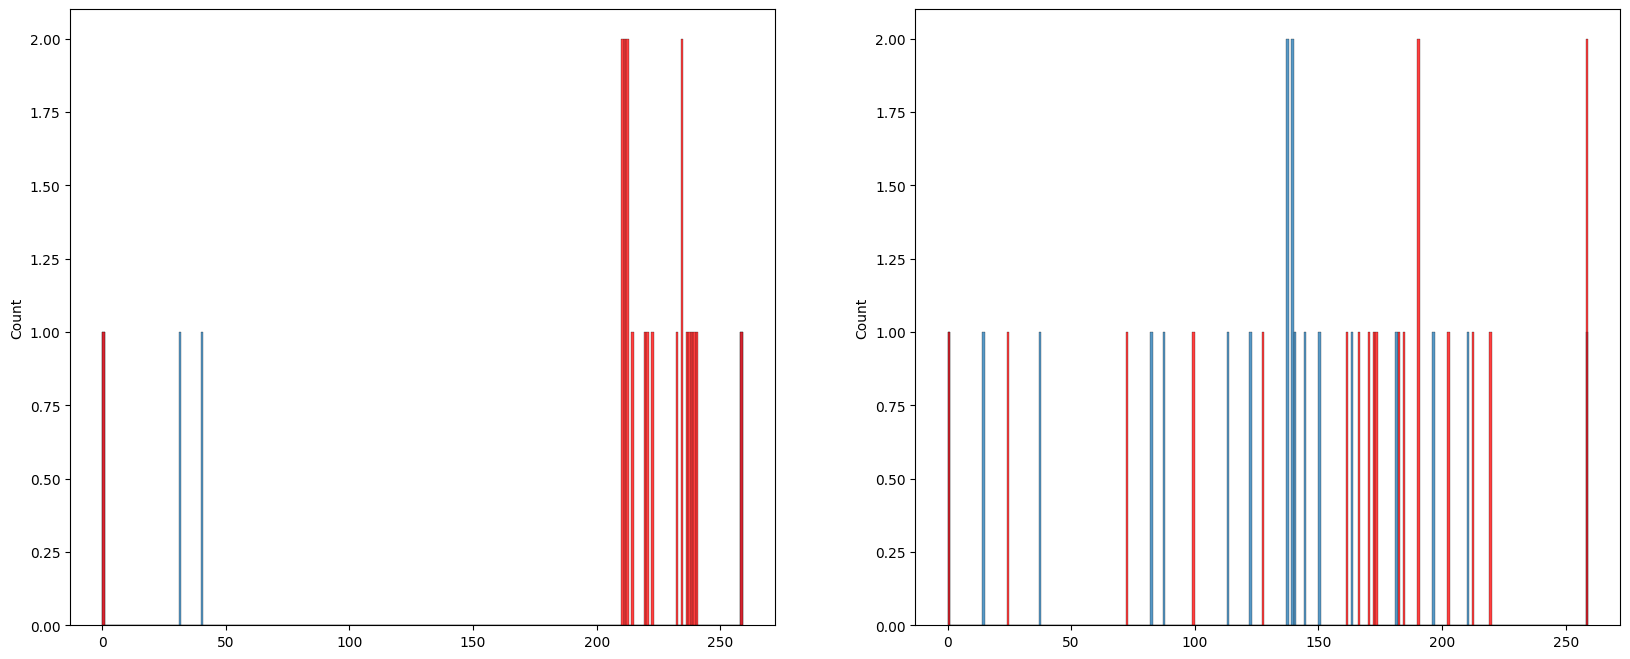

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 33, 5, 6, 7, 8, 11, 12, 14, 16, 17, 22, 23, 28}
Filtering ladders by error


100%|██████████| 20/20 [00:38<00:00,  1.93s/it]

Actual number of ladders: 1 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [11] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


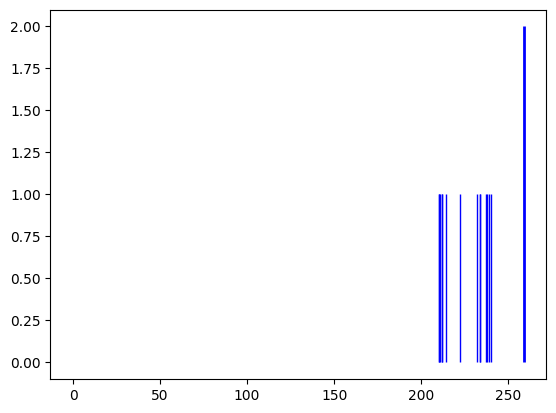

Num: 2419
Spectrum num=2419, size=153, matched=42, frac=0.27450980392156865
Spectrum num=2419, size=153, matched=34, frac=0.2222222222222222


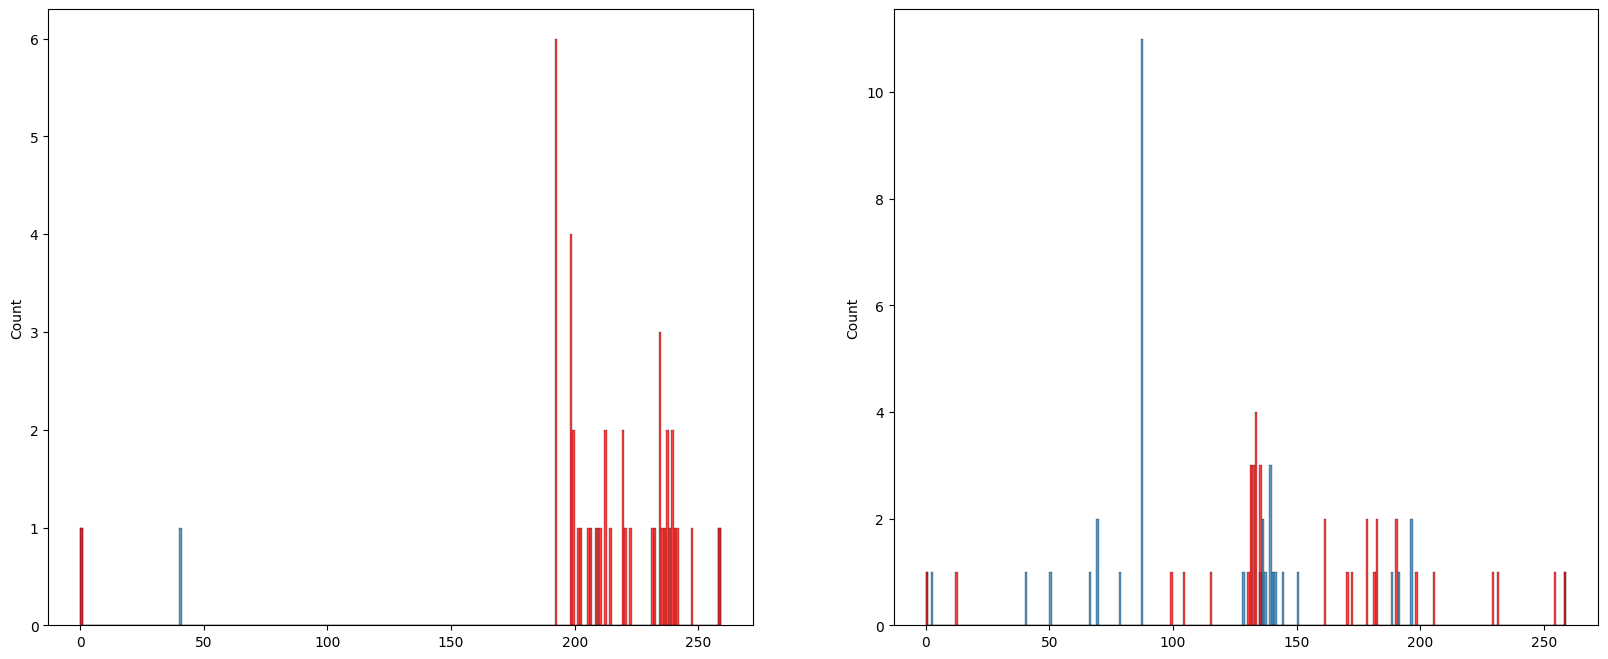

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 1, 2, 3, 4, 5, 6, 9, 10, 16, 146, 20, 22, 23, 36, 37, 47, 53, 60, 61, 63, 67, 78, 107, 108, 109, 113, 118, 125}
{65, 71, 72, 41, 75, 44, 141, 46, 144, 49, 147, 117, 149, 62, 57, 28, 152, 94}
{38, 135, 8, 105, 138, 11, 12, 13, 18, 86, 24, 89, 58, 27}
{121, 48, 114, 116, 150, 25}
{99, 136, 142, 145, 82, 52, 148, 126}
{32, 43, 112, 50, 119, 59}
Filtering ladders by error


100%|██████████| 20/20 [02:39<00:00,  7.95s/it]

Actual number of ladders: 6 Distribution: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
Actual length of ladders: [22, 9, 7, 6, 5, 5] Distribution: [0 0 0 0 0 0 0 5 0 0 0 0 0 0 5 0 0 0 0 0]


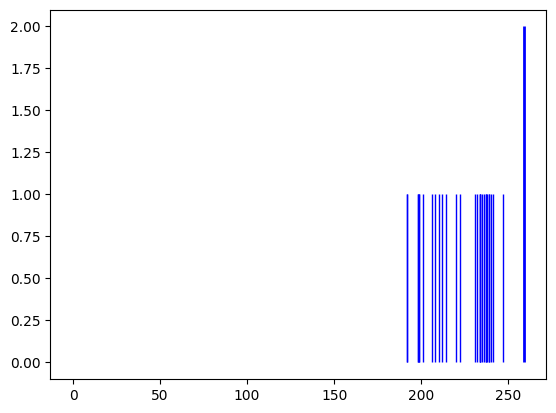

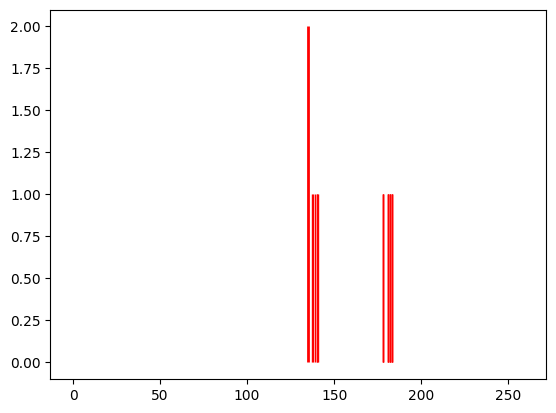

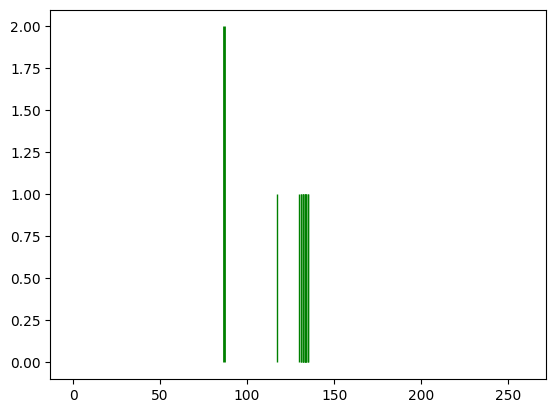

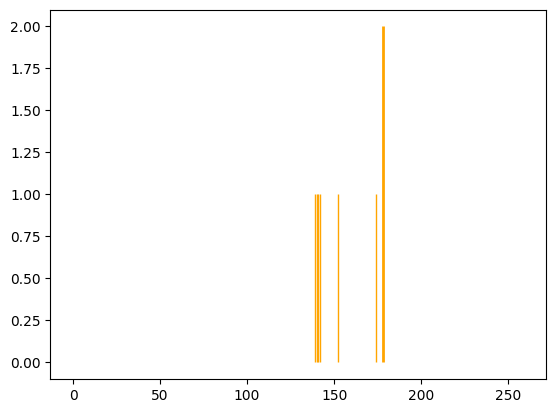

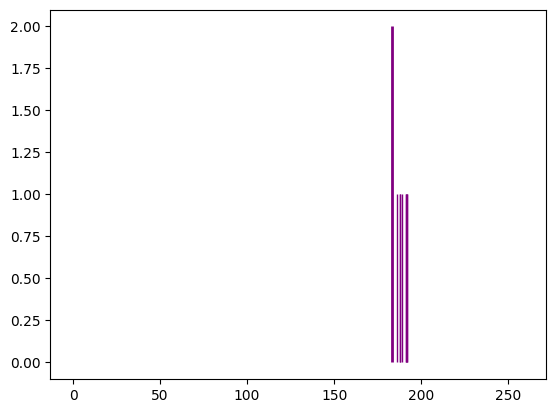

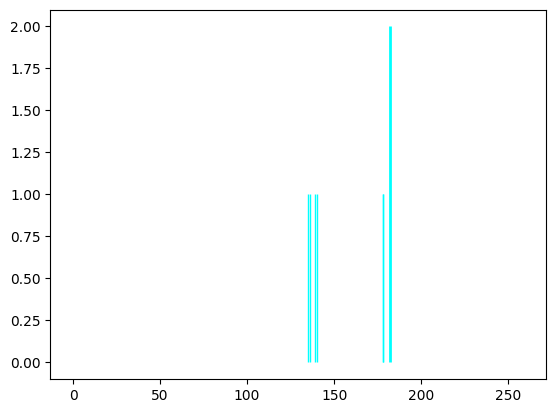

Num: 2437
Spectrum num=2437, size=160, matched=48, frac=0.3
Spectrum num=2437, size=160, matched=39, frac=0.24375


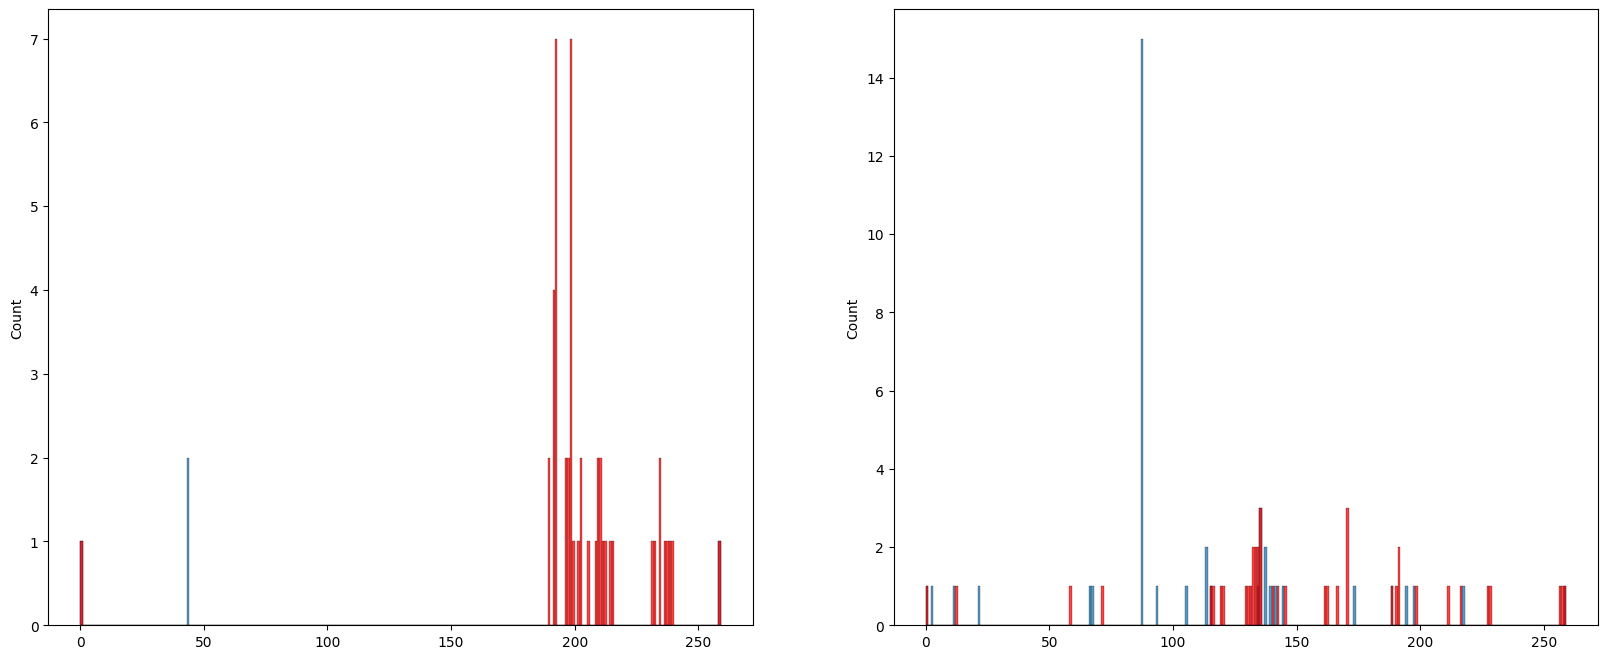

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 1, 2, 3, 5, 7, 9, 10, 137, 12, 15, 18, 19, 20, 21, 24, 25, 35, 36, 42, 54, 55, 60, 62, 64, 66, 69, 72, 80, 83, 84, 86, 94, 95, 101, 104, 112, 125}
{4, 6, 139, 13, 14, 16, 17, 23, 27, 29, 31, 37, 45, 51, 52, 53, 58, 65, 67, 73, 79, 93, 99, 110, 111, 116, 127}
{34, 90, 38, 71, 41, 11, 44, 77, 50, 85, 26, 28}
{68, 138, 109, 78, 117, 152, 154, 155, 157, 126}
Filtering ladders by error


100%|██████████| 20/20 [02:54<00:00,  8.73s/it]

Actual number of ladders: 4 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [24, 18, 8, 6] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


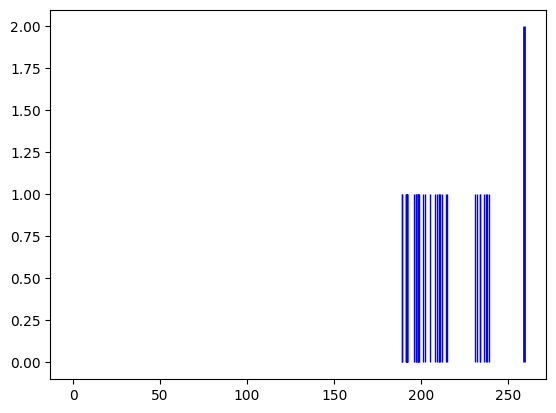

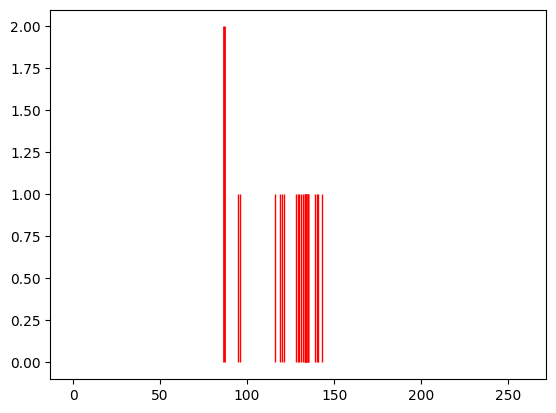

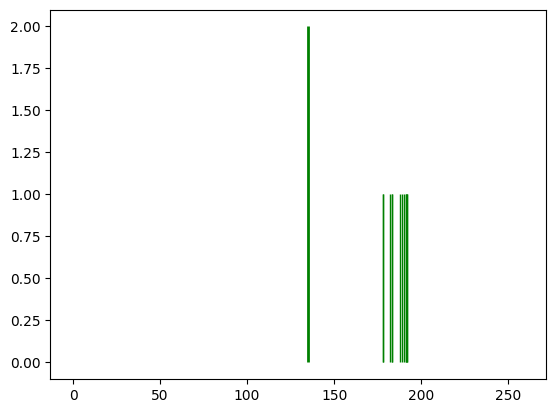

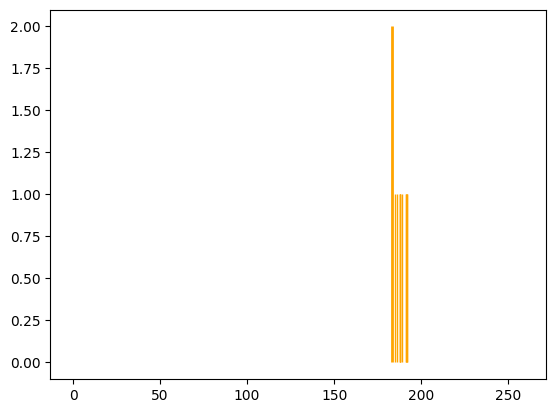

Num: 2450
Spectrum num=2450, size=196, matched=93, frac=0.4744897959183674
Spectrum num=2450, size=196, matched=41, frac=0.20918367346938777


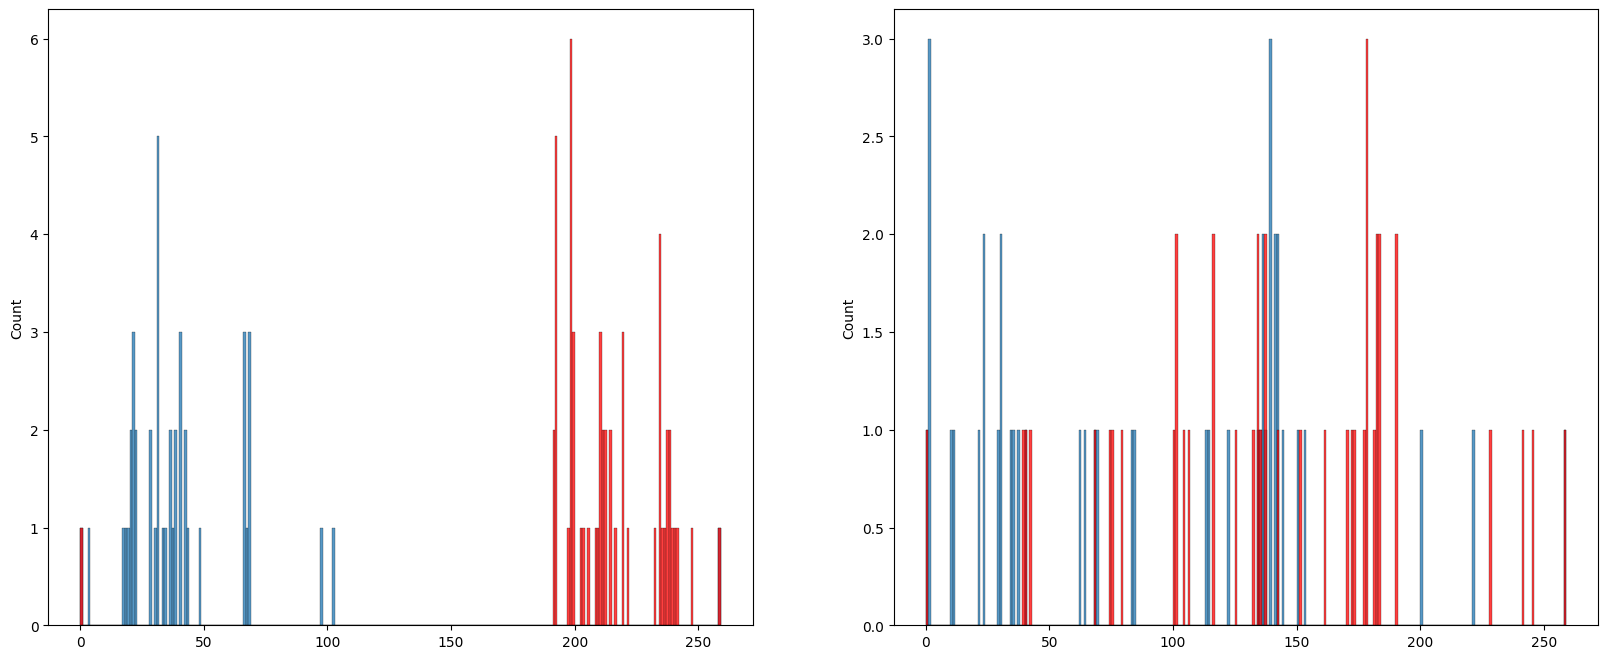

<Figure size 1200x800 with 0 Axes>

Ladders
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 133, 12, 134, 14, 15, 16, 145, 21, 22, 24, 26, 28, 29, 31, 162, 36, 37, 42, 43, 57, 60, 189, 61, 64, 195, 68, 80, 113, 114, 118, 124}
{0, 130, 11, 13, 19, 23, 153, 155, 157, 160, 35, 41, 44, 45, 49, 52, 53, 182, 56, 186, 63, 75, 77, 79, 87, 92, 93, 95, 96, 104, 105, 111, 115, 122}
{128, 97, 33, 163, 100, 167, 74, 51, 181}
{40, 123, 112, 50, 83, 20, 148, 59, 62, 127}
{32, 71, 175, 146, 150, 30}
{70, 72, 47, 88, 25}
{66, 78, 178, 121, 125}
Filtering ladders by error


100%|██████████| 20/20 [04:58<00:00, 14.93s/it]

Actual number of ladders: 5 Distribution: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Actual length of ladders: [25, 20, 6, 6, 5] Distribution: [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]


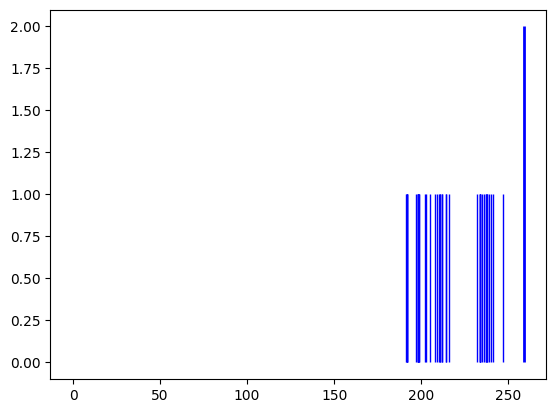

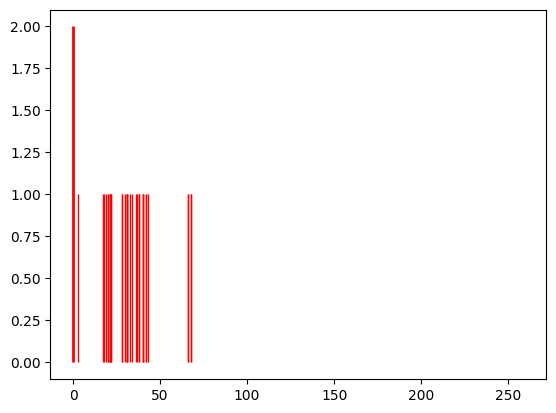

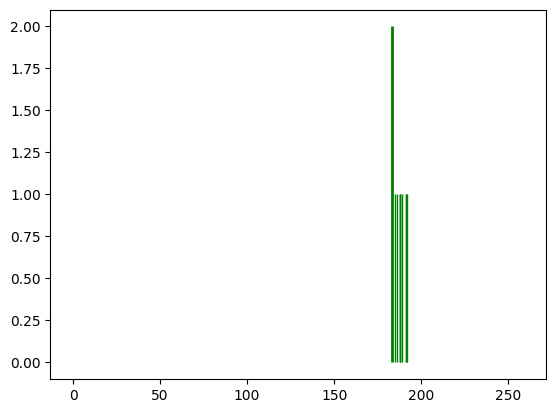

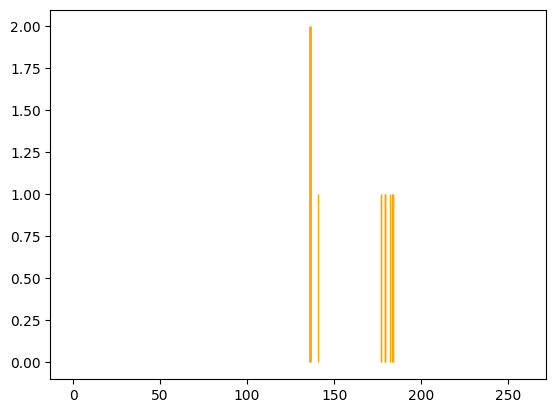

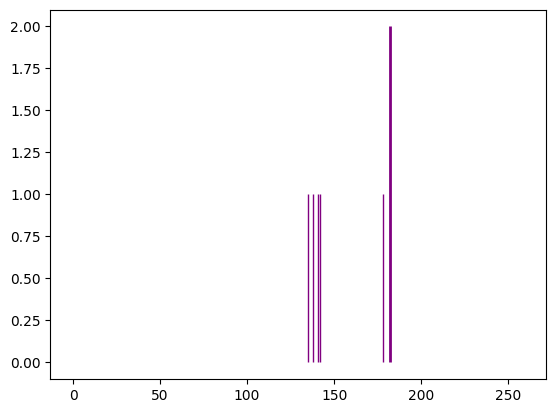

Num: 2462
Spectrum num=2462, size=92, matched=16, frac=0.17391304347826086
Spectrum num=2462, size=92, matched=18, frac=0.1956521739130435


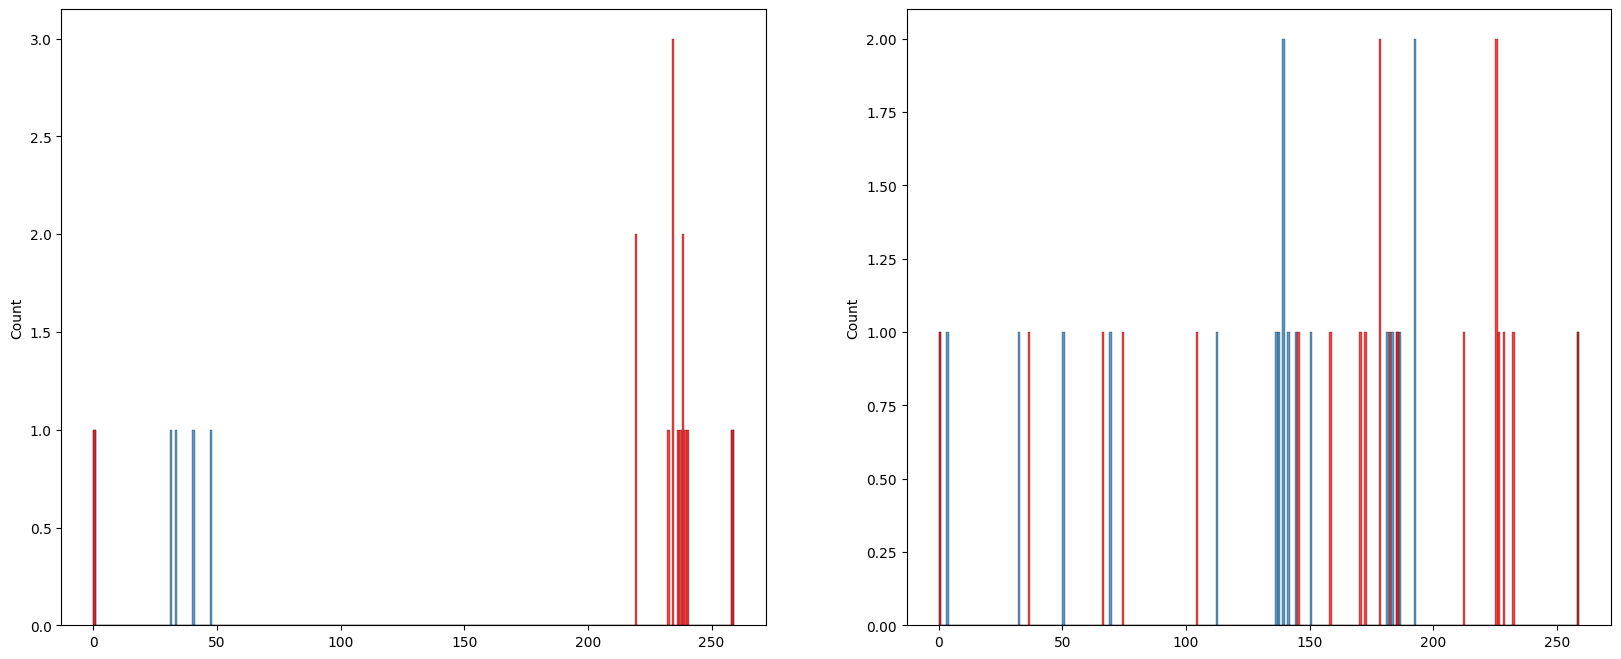

<Figure size 1200x800 with 0 Axes>

Ladders
{33, 6, 8, 41, 10, 78, 15, 81, 51, 85, 22, 23, 88, 56}
{1, 2, 3, 5, 11, 16, 53, 27, 29}
{4, 42, 74, 48, 19, 61}
Filtering ladders by error


100%|██████████| 20/20 [00:51<00:00,  2.60s/it]

Actual number of ladders: 3 Distribution: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [9, 6, 6] Distribution: [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]


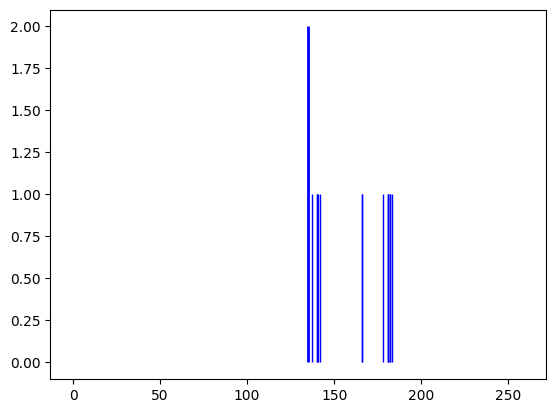

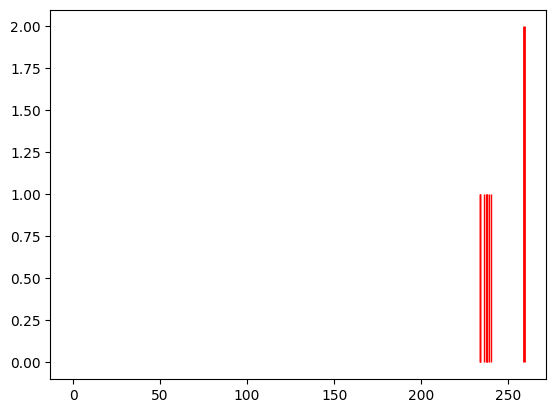

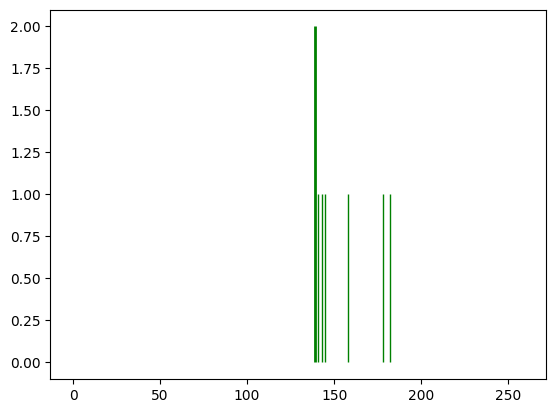

Num: 2466
Spectrum num=2466, size=483, matched=146, frac=0.3022774327122153
Spectrum num=2466, size=483, matched=97, frac=0.20082815734989648


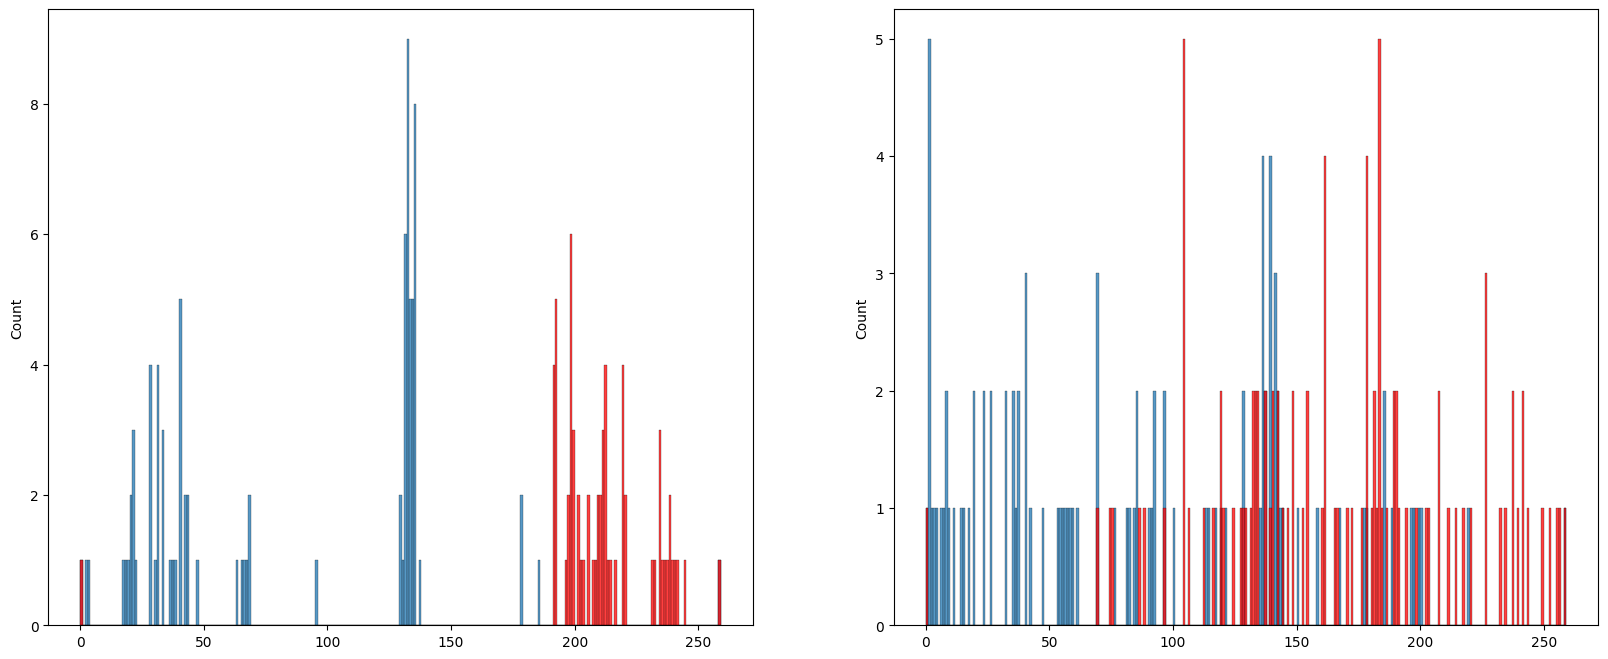

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 1, 130, 3, 4, 5, 6, 8, 9, 137, 11, 15, 144, 22, 23, 24, 27, 28, 156, 33, 36, 164, 38, 42, 299, 430, 46, 177, 53, 54, 448, 70, 74, 330, 80, 81, 92, 98, 372, 124, 255}
{2, 7, 266, 139, 13, 14, 273, 17, 148, 21, 20, 25, 412, 29, 290, 165, 294, 424, 170, 51, 52, 309, 56, 441, 191, 64, 449, 322, 324, 199, 204, 335, 82, 85, 86, 87, 470, 217, 223, 480, 99, 231, 359, 121, 122}
{193, 414, 68, 453, 100, 141, 50, 30, 94}
{230, 200, 41, 234, 105, 140, 145, 275, 116, 219, 220}
{160, 32, 66, 35, 67, 358, 39, 71, 10, 112, 214, 26, 284}
{416, 135, 428, 436, 182, 57}
{232, 43, 302, 344, 58, 316, 126}
{101, 389, 297, 44, 48, 368, 446}
{34, 267, 211, 437, 248, 31}
{258, 356, 271, 151, 408, 60}
{450, 228, 108, 207, 317}
{171, 77, 239, 243, 158}
{298, 399, 276, 315, 444}
{110, 303, 47, 18, 152, 125}
{353, 73, 202, 55, 215, 188, 351}
{355, 229, 203, 339, 310}
{387, 270, 277, 89, 190}
{136, 394, 468, 254, 287}
Filtering ladders by error


100%|██████████| 20/20 [28:54<00:00, 86.73s/it]

Actual number of ladders: 5 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [30, 28, 8, 7, 5] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


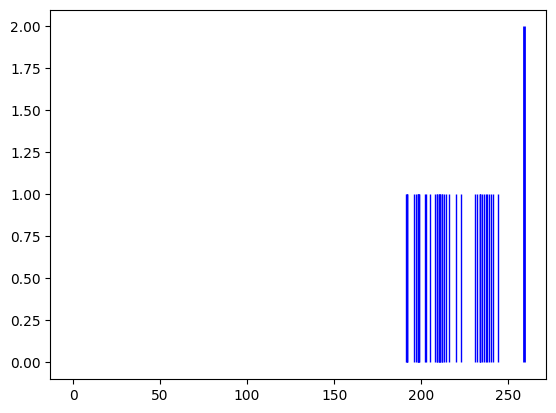

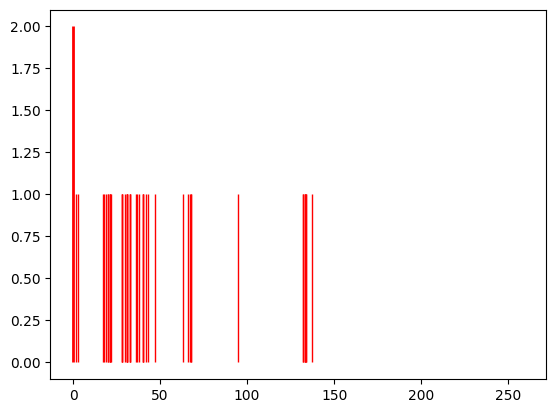

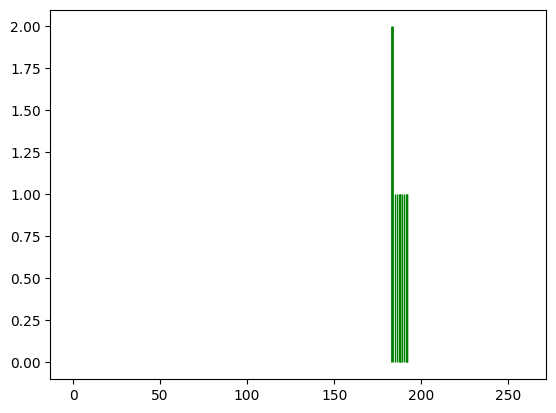

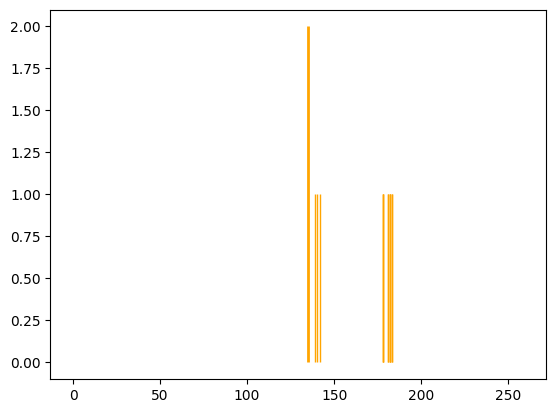

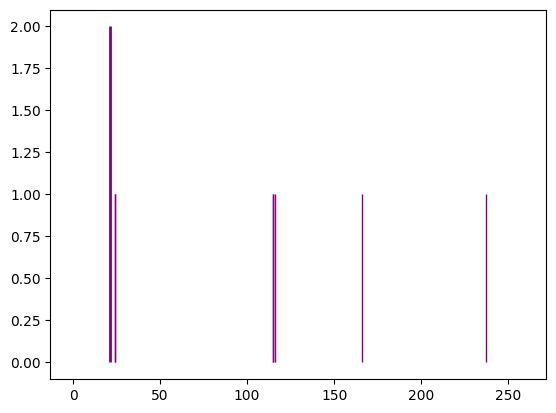

Num: 2468
Spectrum num=2468, size=634, matched=137, frac=0.21608832807570977
Spectrum num=2468, size=634, matched=101, frac=0.15930599369085174


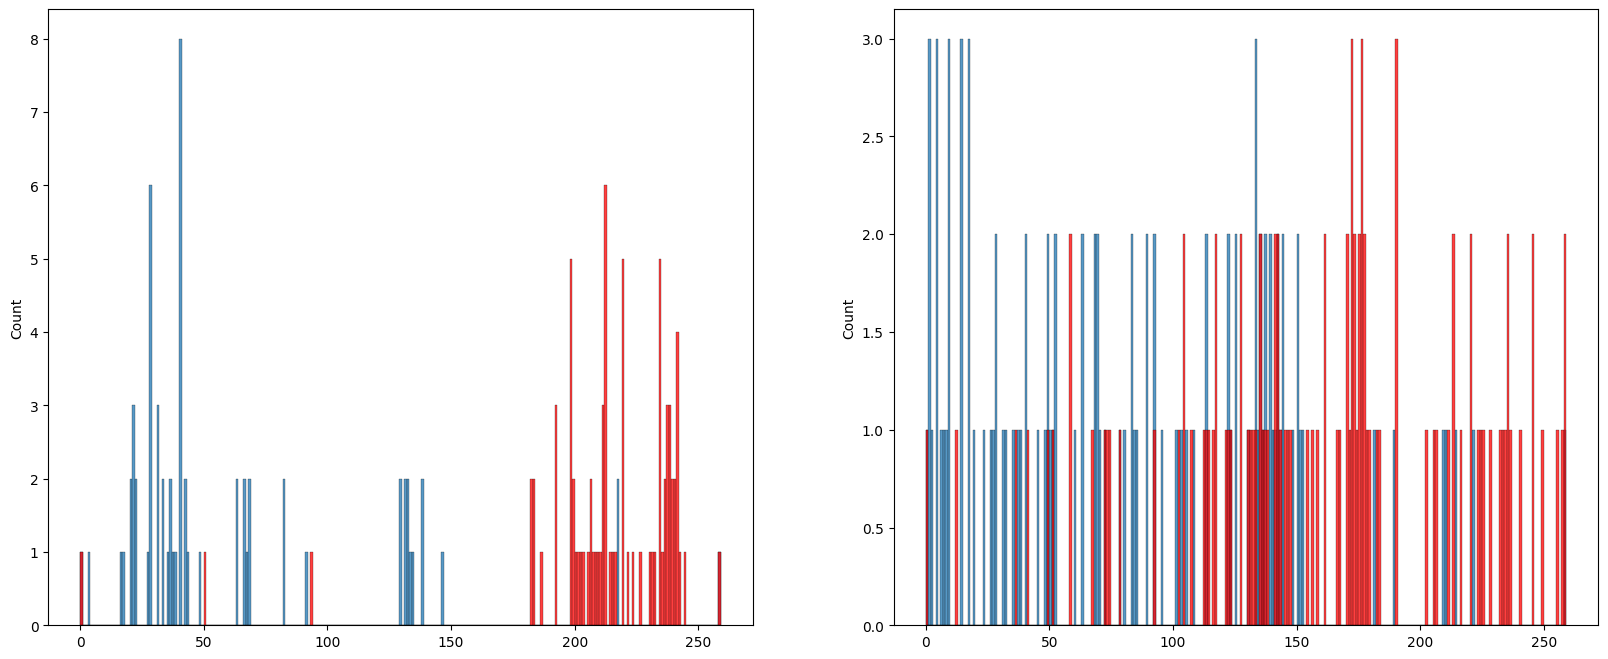

<Figure size 1200x800 with 0 Axes>

Ladders
{128, 1, 2, 3, 4, 5, 6, 7, 133, 9, 10, 139, 11, 12, 398, 16, 17, 22, 23, 25, 410, 28, 30, 295, 41, 42, 53, 570, 59, 58, 61, 192, 324, 74, 332, 81, 88, 90, 226, 116, 120, 377}
{0, 387, 391, 8, 145, 18, 20, 21, 26, 27, 539, 33, 164, 37, 296, 44, 46, 47, 49, 51, 181, 56, 60, 190, 71, 328, 457, 80, 110, 624, 499, 121, 251, 380}
{35, 38, 40, 265, 45, 92, 147, 339, 598, 278, 346, 156}
{97, 484, 230, 167, 134, 137, 390, 43, 82, 469, 186, 187, 29}
{482, 101, 395, 13, 112, 274, 148, 86}
{160, 32, 34, 99, 100, 104, 114, 409}
{521, 587, 175, 401, 529, 340, 153}
{449, 72, 106, 75, 236, 77, 109, 91}
{96, 161, 67, 325, 518, 185, 223}
{260, 200, 397, 402, 284, 509, 415}
{583, 575, 494, 83, 599, 447}
{450, 232, 176, 89, 605, 318}
{616, 554, 619, 396, 474, 218}
{578, 502, 55, 249, 127, 414, 31}
{231, 299, 113, 210, 308, 629}
{481, 485, 268, 301, 505, 604}
{544, 227, 455, 302, 247}
{458, 202, 111, 400, 152, 283}
{297, 558, 336, 600, 444}
{329, 393, 428, 460, 493}
{550, 557, 48, 434, 310, 343}
{5

100%|██████████| 20/20 [58:10<00:00, 174.55s/it]

Actual number of ladders: 7 Distribution: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
Actual length of ladders: [31, 21, 11, 7, 7, 7, 5] Distribution: [0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 5 0 0]


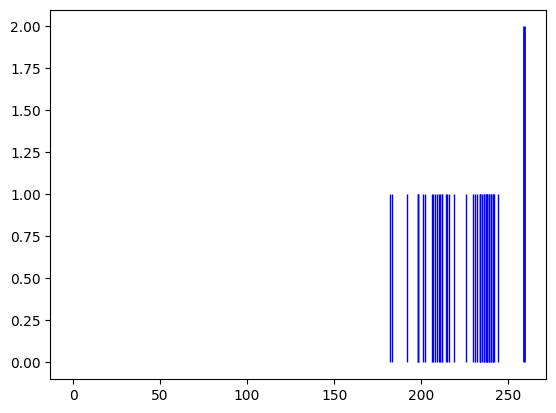

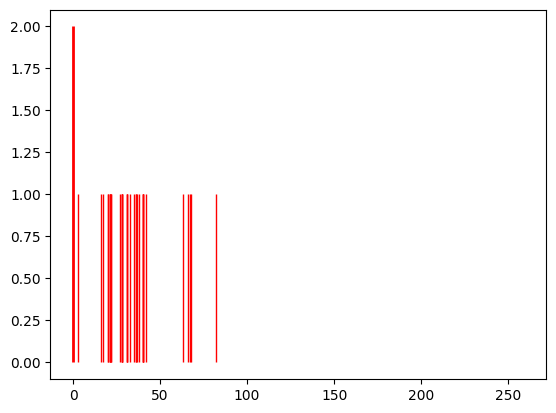

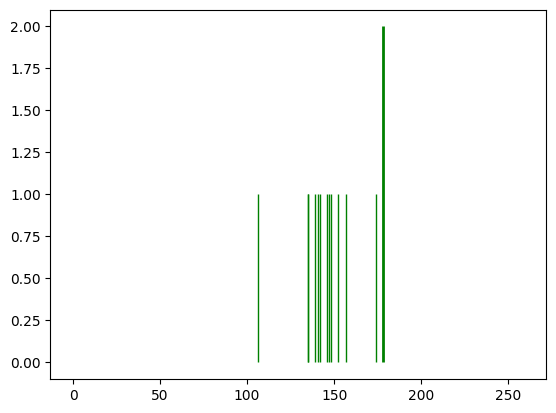

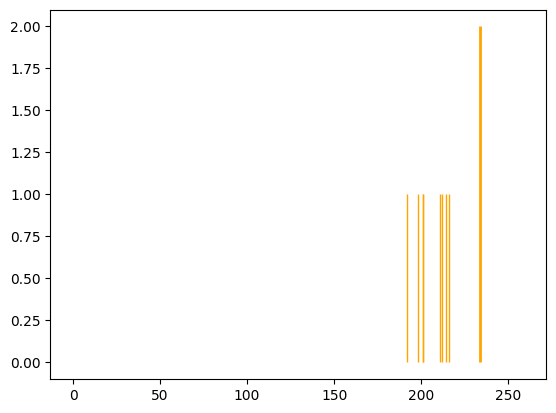

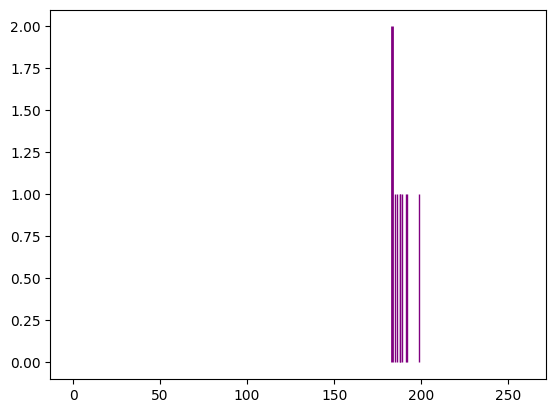

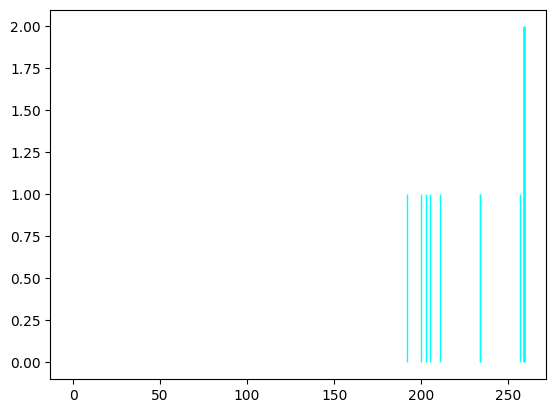

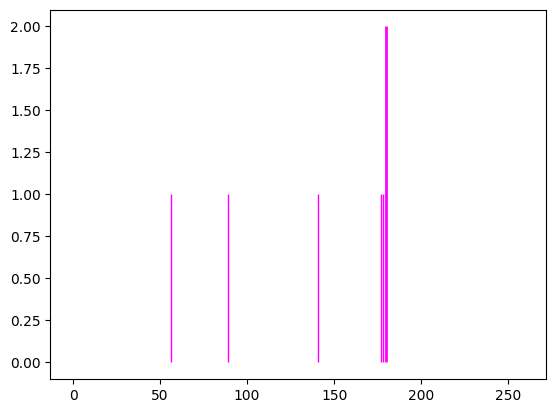

Num: 2479
Spectrum num=2479, size=241, matched=52, frac=0.2157676348547718
Spectrum num=2479, size=241, matched=40, frac=0.16597510373443983


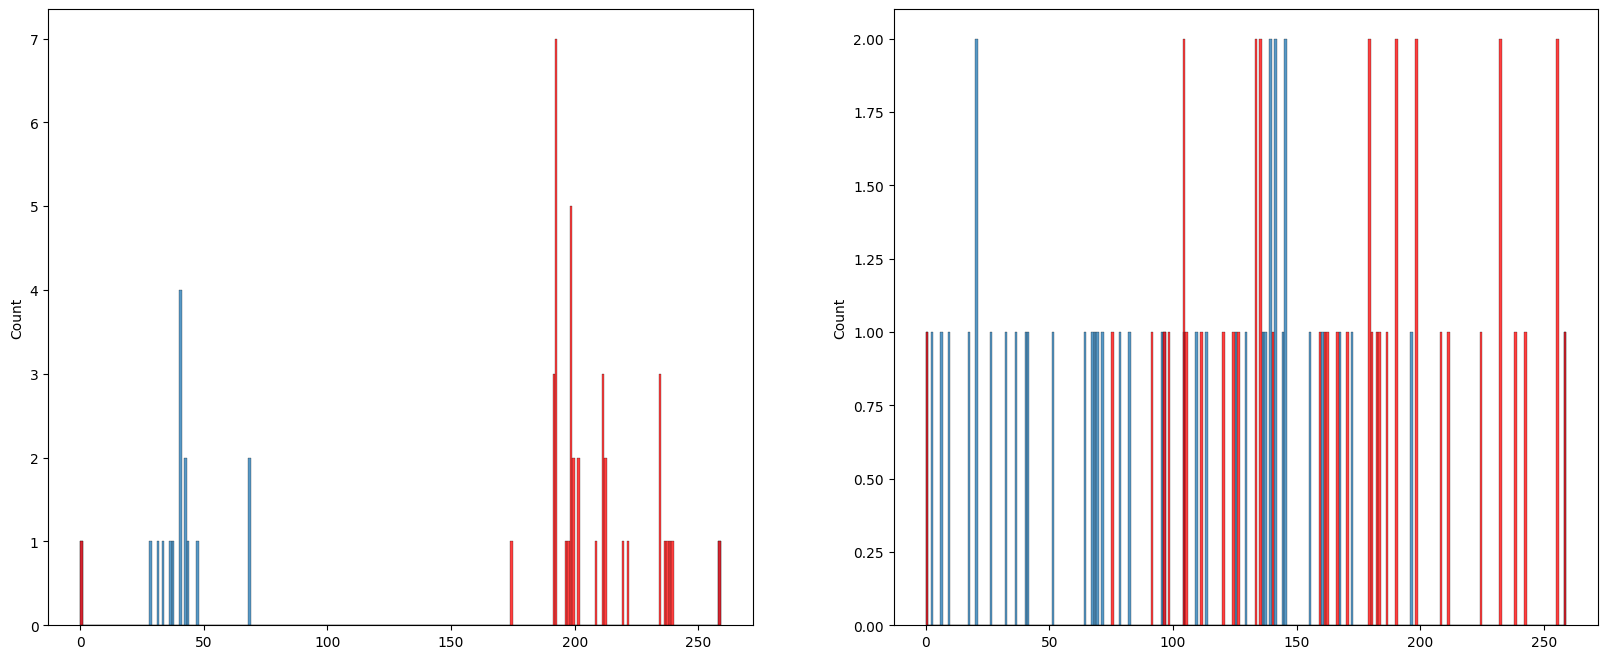

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 1, 2, 4, 5, 6, 11, 13, 14, 16, 17, 18, 21, 22, 24, 31, 32, 35, 41, 51, 56, 61, 70, 79}
{34, 133, 7, 15, 175, 113, 84, 213}
{3, 40, 8, 170, 86, 157}
{68, 12, 46, 48, 117}
{162, 37, 237, 110, 143}
{164, 39, 201, 122, 187}
Filtering ladders by error


100%|██████████| 20/20 [04:51<00:00, 14.58s/it]

Actual number of ladders: 4 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [15, 8, 6, 5] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


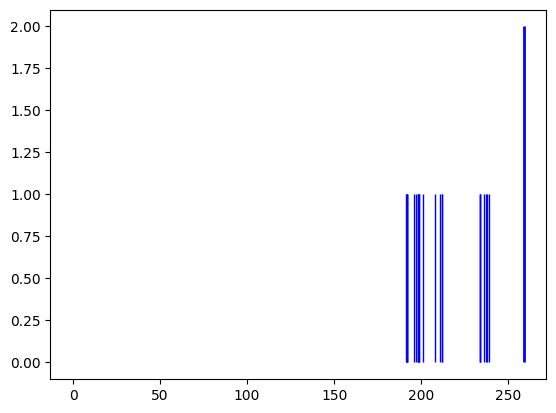

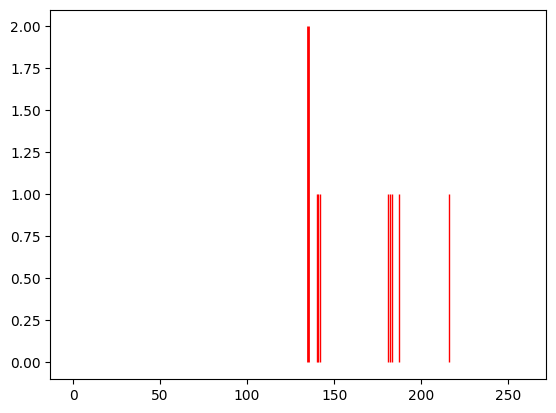

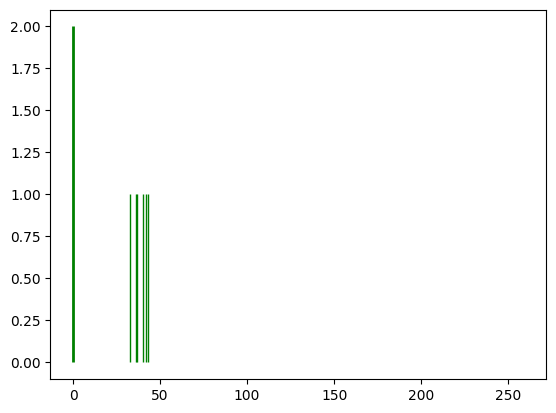

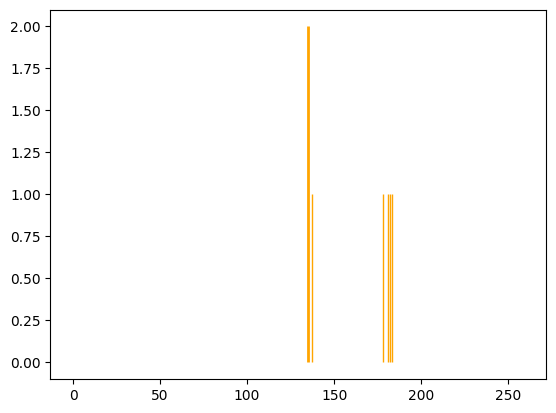

Num: 2490
Spectrum num=2490, size=161, matched=75, frac=0.4658385093167702
Spectrum num=2490, size=161, matched=23, frac=0.14285714285714285


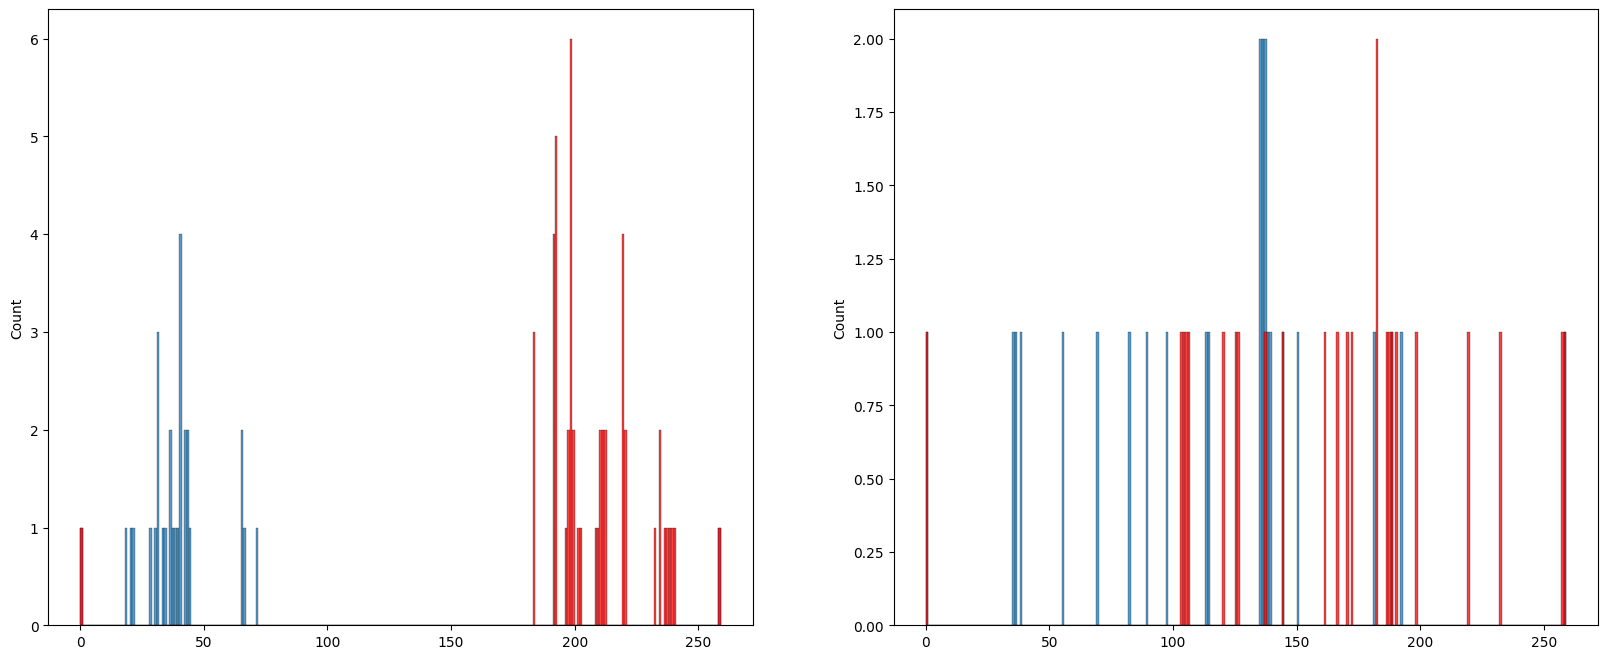

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 1, 2, 4, 5, 134, 7, 9, 12, 14, 15, 17, 18, 20, 22, 24, 25, 26, 30, 31, 32, 35, 38, 43, 45, 48, 50, 51, 57, 58, 63, 75, 90, 105, 107, 118, 121}
{129, 3, 136, 10, 13, 16, 144, 40, 53, 60, 73, 82, 85, 86, 101, 103, 104, 106, 115, 123}
{6, 8, 11, 145, 153, 28, 156, 33, 34, 39, 41, 52, 54, 66, 69, 77, 81, 92, 94, 95, 109}
{132, 88, 155, 119, 87, 152, 151, 27, 157, 158}
{100, 42, 113, 21, 127}
Filtering ladders by error


100%|██████████| 20/20 [02:48<00:00,  8.45s/it]

Actual number of ladders: 4 Distribution: [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Actual length of ladders: [22, 15, 12, 7] Distribution: [0 0 0 5 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]


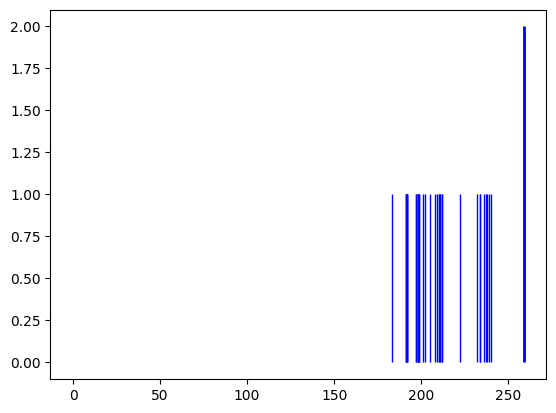

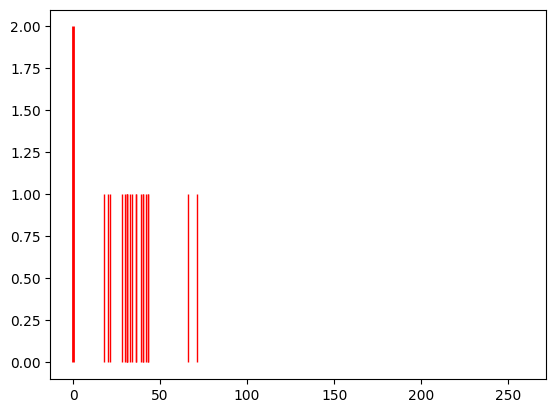

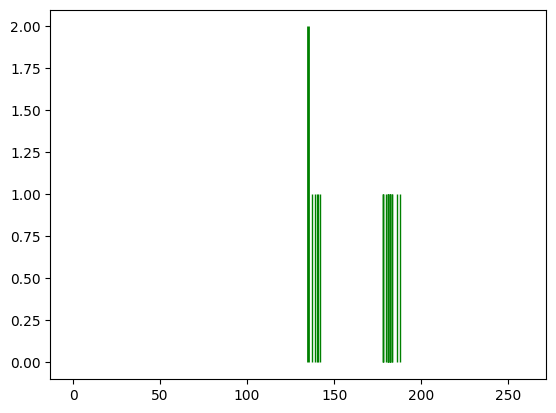

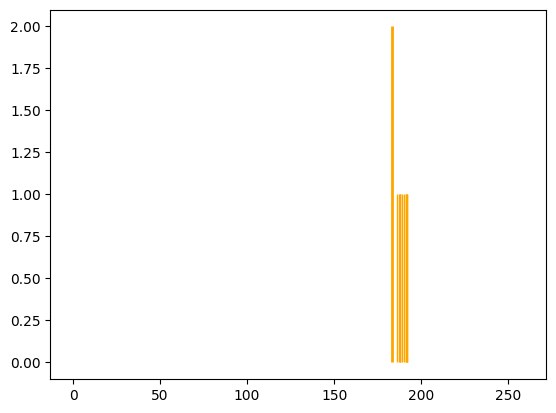

Num: 2505
Spectrum num=2505, size=169, matched=66, frac=0.3905325443786982
Spectrum num=2505, size=169, matched=29, frac=0.17159763313609466


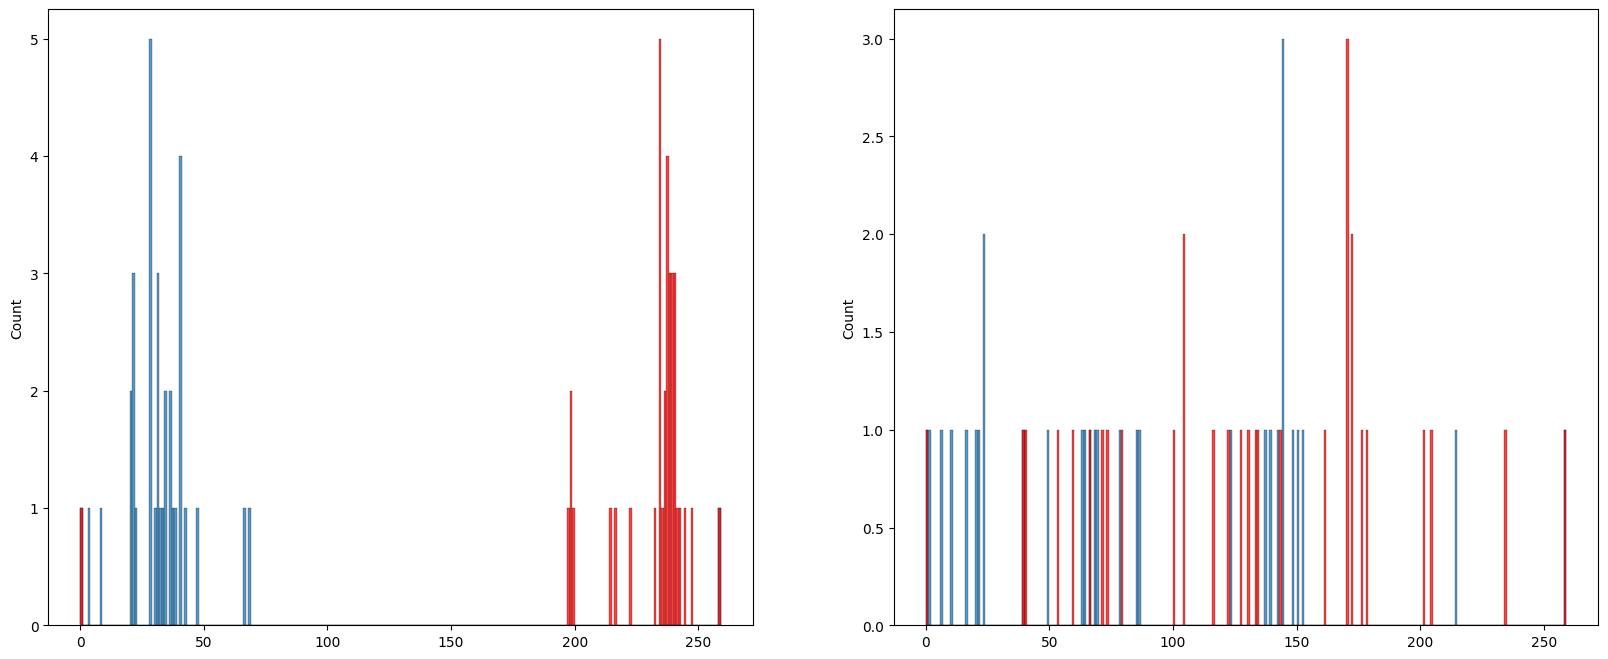

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 1, 2, 3, 4, 5, 6, 8, 13, 14, 16, 19, 152, 33, 34, 40, 45, 47, 50, 51, 56, 72, 77, 82, 95, 103}
{7, 9, 12, 20, 25, 27, 28, 35, 38, 41, 46, 48, 49, 52, 57, 61, 62, 63, 66, 78, 85, 87, 126}
{32, 90, 101, 43, 26}
{70, 10, 17, 18, 116, 89}
{36, 134, 39, 44, 120}
{105, 108, 22, 24, 153, 122}
Filtering ladders by error


100%|██████████| 20/20 [03:17<00:00,  9.85s/it]

Actual number of ladders: 3 Distribution: [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [15, 14, 5] Distribution: [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


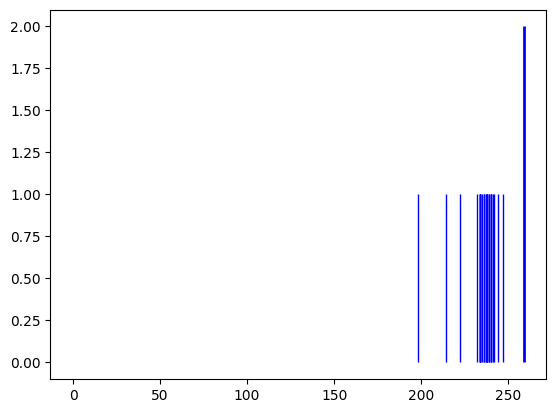

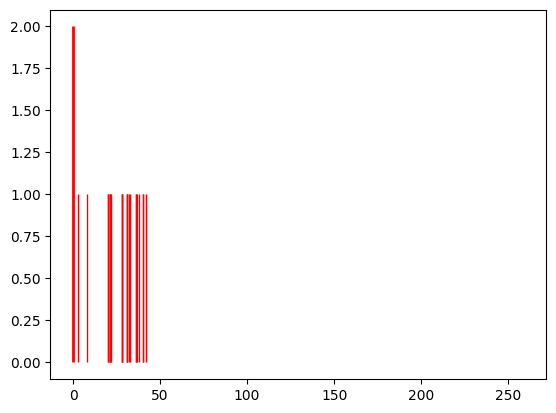

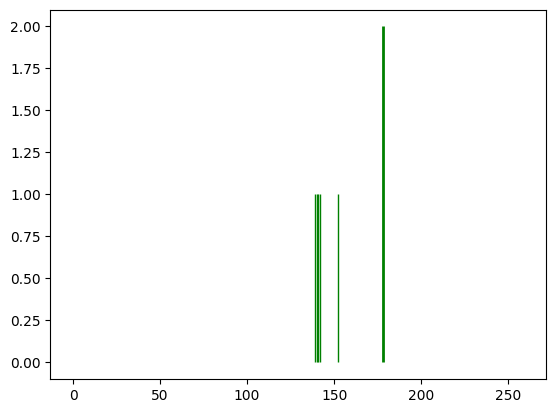

Num: 2515
Spectrum num=2515, size=211, matched=97, frac=0.4597156398104265
Spectrum num=2515, size=211, matched=50, frac=0.23696682464454977


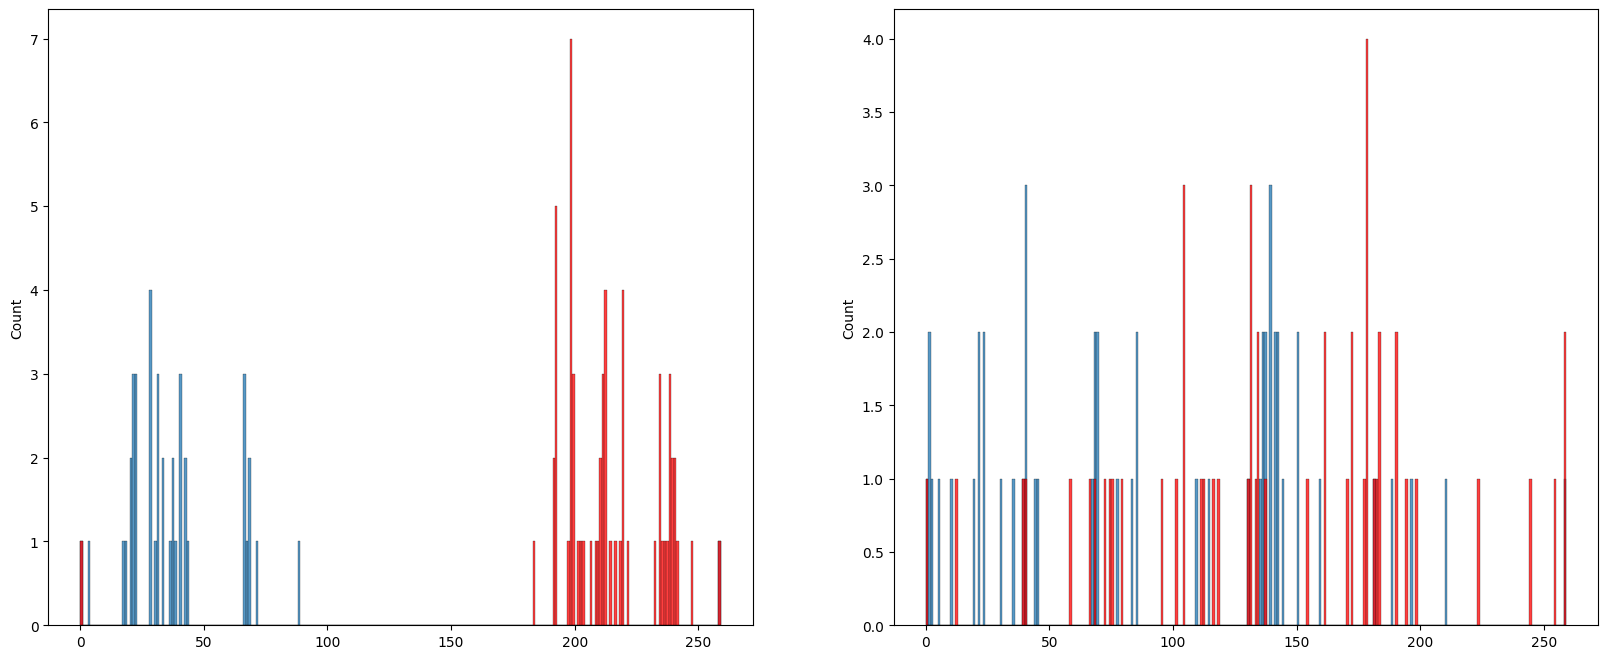

<Figure size 1200x800 with 0 Axes>

Ladders
{1, 2, 3, 4, 5, 133, 7, 8, 9, 138, 10, 12, 13, 142, 15, 14, 17, 18, 143, 21, 24, 154, 28, 157, 163, 37, 40, 50, 54, 61, 66, 68, 75, 80, 208, 83, 84, 92, 96, 115, 117, 123}
{0, 6, 11, 25, 30, 31, 34, 35, 38, 171, 44, 47, 176, 178, 51, 52, 181, 62, 192, 65, 70, 72, 76, 77, 205, 207, 82, 85, 110, 120, 121, 124}
{160, 33, 100, 39, 71, 73, 41, 43, 103, 109, 177, 116, 53, 58, 94, 63}
{200, 137, 104, 16, 144, 180}
{42, 91, 81, 152, 155, 188, 95}
{67, 107, 141, 79, 179, 23, 159}
{161, 145, 119, 187, 60, 191}
Filtering ladders by error


100%|██████████| 20/20 [04:57<00:00, 14.86s/it]

Actual number of ladders: 4 Distribution: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [24, 18, 7, 5] Distribution: [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


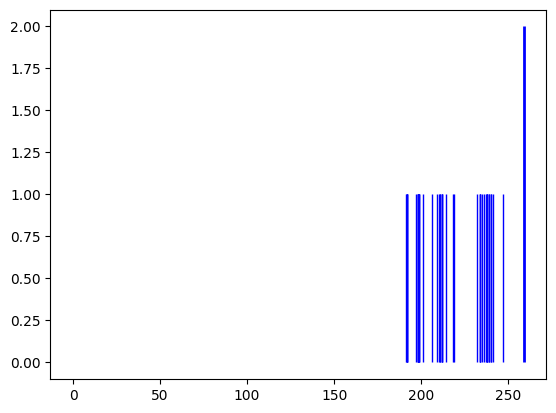

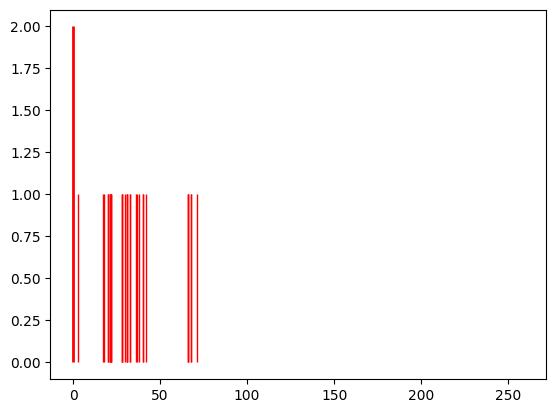

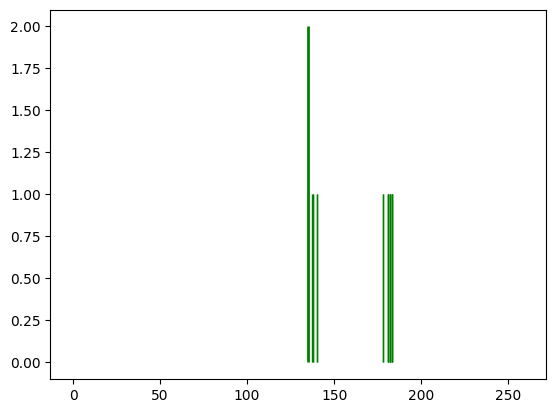

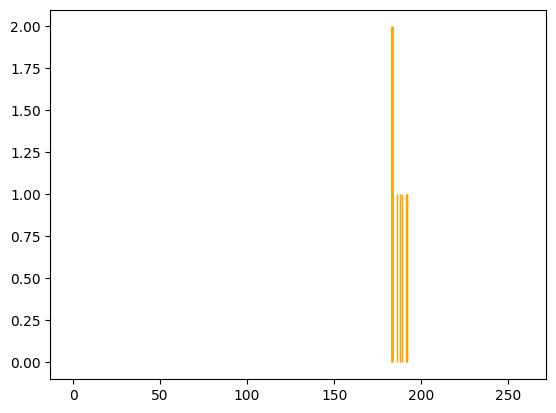

Num: 2535
Spectrum num=2535, size=111, matched=41, frac=0.36936936936936937
Spectrum num=2535, size=111, matched=13, frac=0.11711711711711711


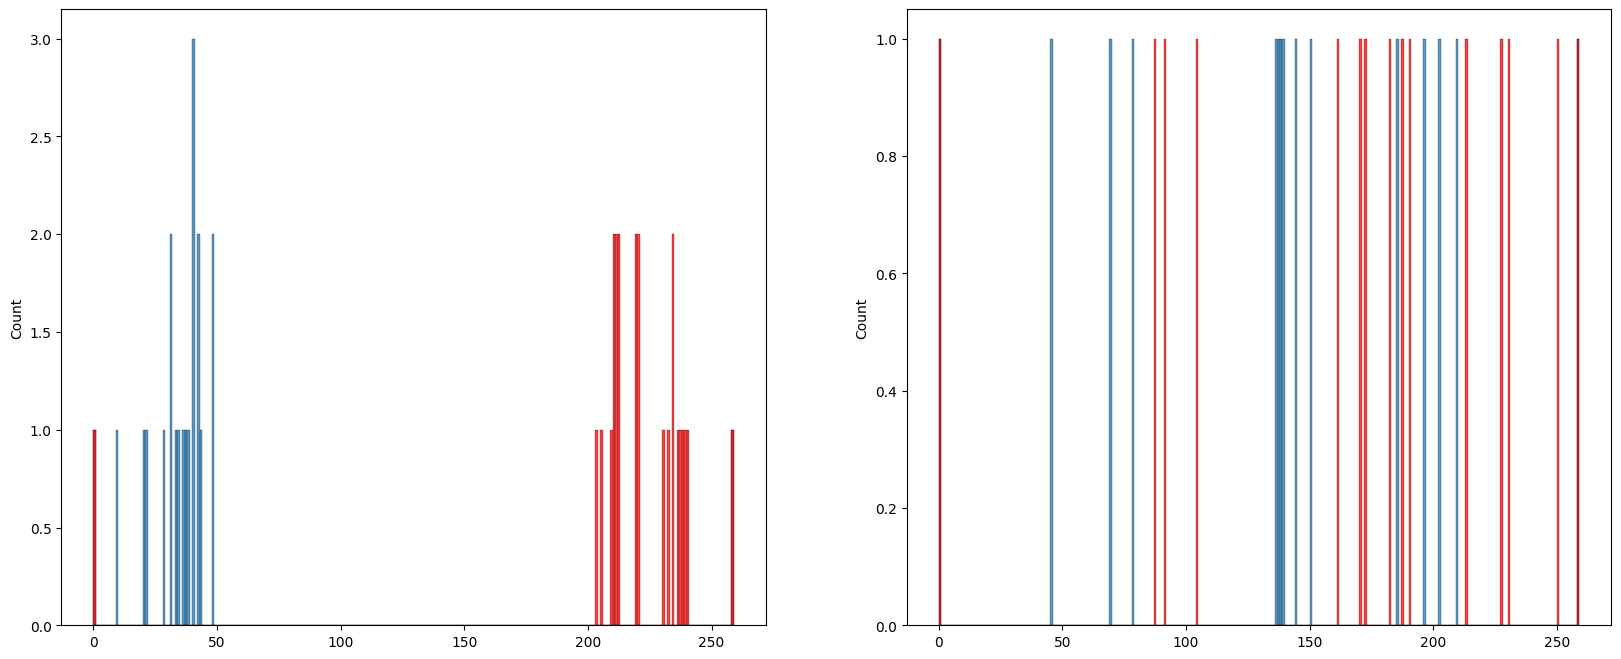

<Figure size 1200x800 with 0 Axes>

Ladders
{64, 1, 33, 39, 9, 13, 15, 81, 18, 19, 84, 20, 22, 23, 27, 28}
{0, 34, 68, 5, 36, 7, 72, 10, 77, 49, 50, 51, 92, 62}
{67, 99, 100, 104, 47, 17, 56}
{73, 42, 24, 25, 95}
Filtering ladders by error


100%|██████████| 20/20 [01:10<00:00,  3.55s/it]

Actual number of ladders: 3 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Actual length of ladders: [13, 11, 5] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]


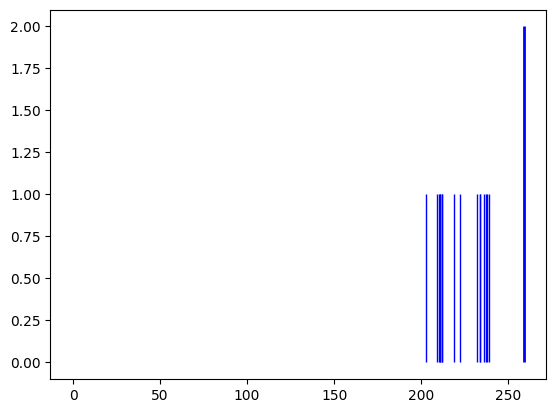

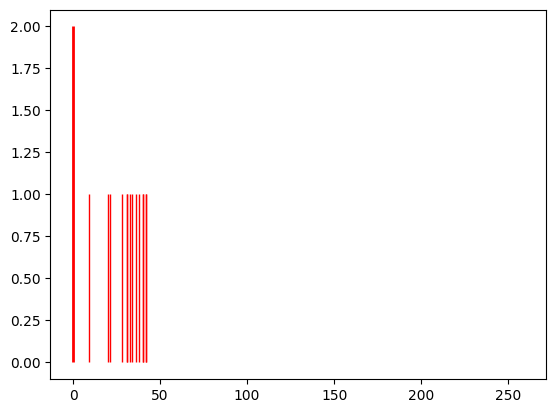

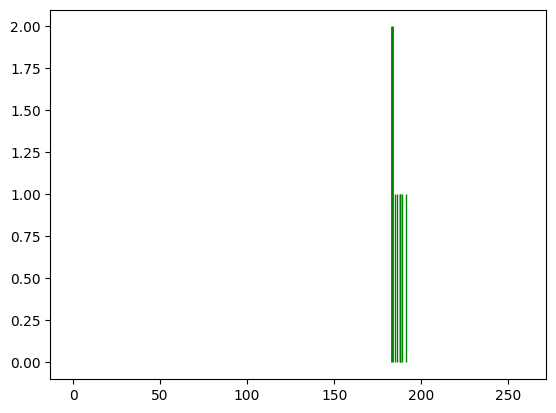

Num: 2575
Spectrum num=2575, size=416, matched=140, frac=0.33653846153846156
Spectrum num=2575, size=416, matched=71, frac=0.17067307692307693


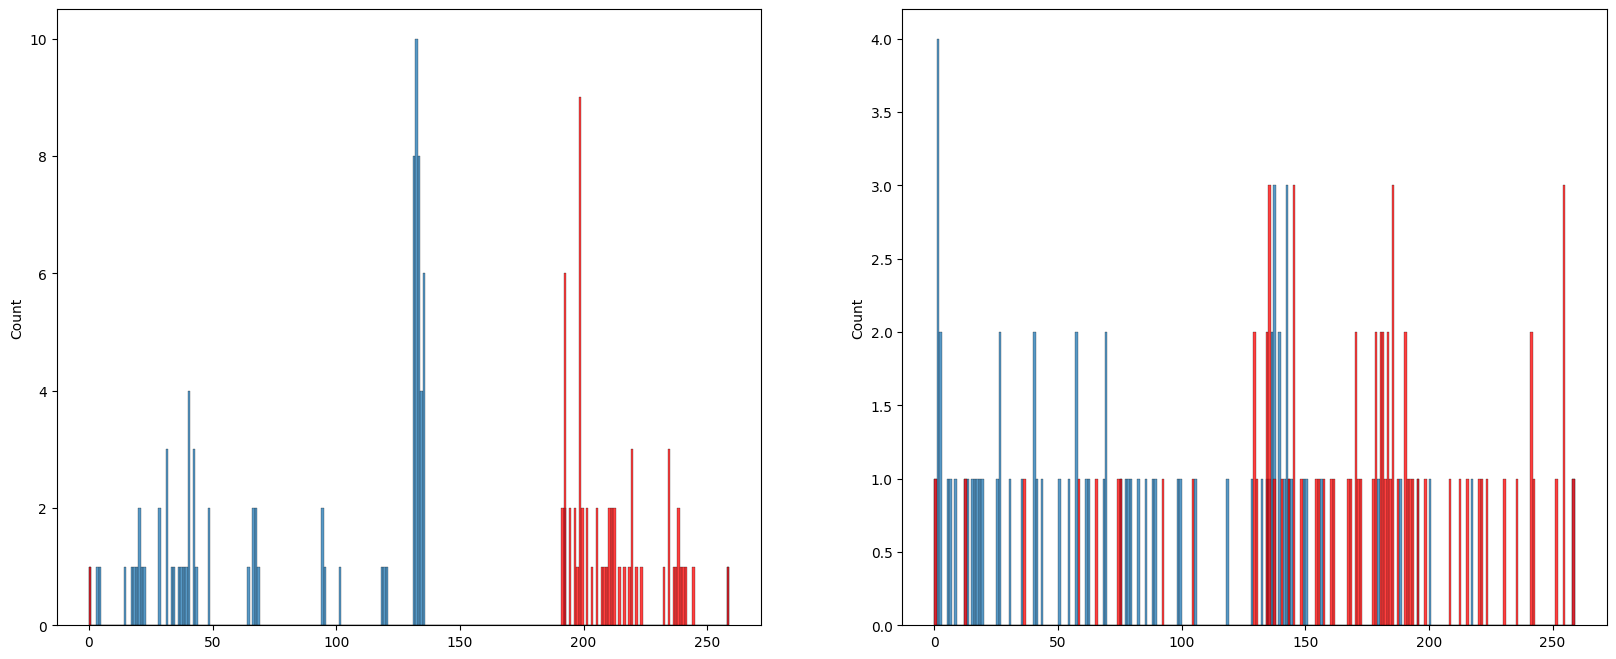

<Figure size 1200x800 with 0 Axes>

Ladders
{1, 258, 131, 134, 6, 136, 10, 11, 144, 17, 22, 29, 30, 159, 415, 297, 299, 301, 175, 50, 182, 59, 63, 69, 71, 201, 206, 336, 81, 94, 229, 357, 362, 110, 239, 241, 250}
{0, 128, 2, 3, 4, 5, 7, 8, 9, 13, 269, 16, 401, 20, 23, 24, 26, 27, 411, 160, 34, 298, 43, 44, 46, 47, 58, 60, 328, 73, 77, 339, 84, 89, 349, 223, 105, 116, 119, 121}
{320, 33, 36, 167, 145, 370, 117, 54, 86, 152, 25, 31}
{64, 32, 193, 35, 323, 395, 14, 403, 62}
{312, 103, 296, 40, 177, 181, 280, 125, 254}
{122, 273, 310, 87, 90, 91}
{353, 98, 42, 45, 114, 190}
{359, 168, 267, 337, 178, 248}
{290, 141, 19, 247, 253}
{203, 302, 207, 278, 55}
{101, 12, 48, 307, 345}
{293, 268, 399, 157, 285}
{38, 142, 238, 340, 277}
{197, 199, 143, 82, 409}
{391, 327, 333, 348, 95}
{385, 194, 264, 170, 191}
{321, 15, 209, 284, 124}
Filtering ladders by error


100%|██████████| 20/20 [20:42<00:00, 62.11s/it]

Actual number of ladders: 6 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Actual length of ladders: [28, 27, 8, 8, 7, 6] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]


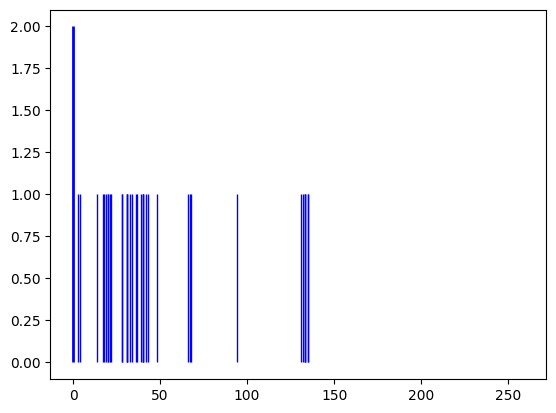

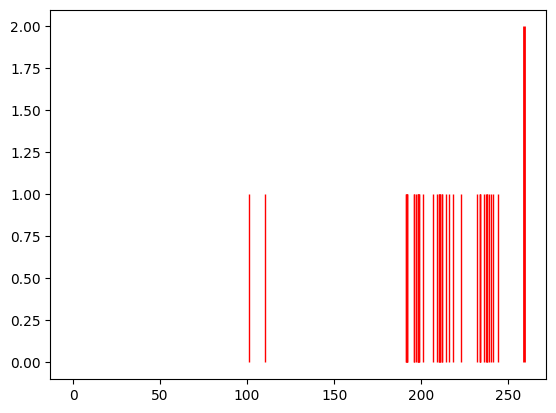

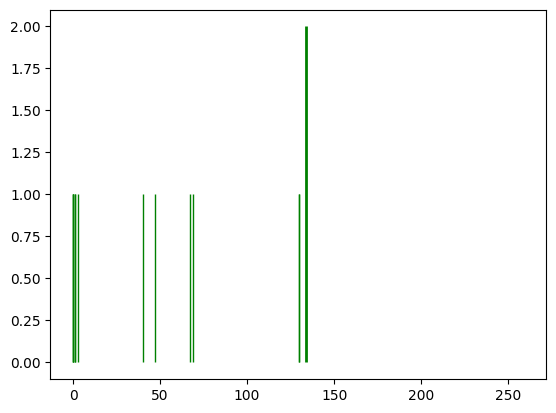

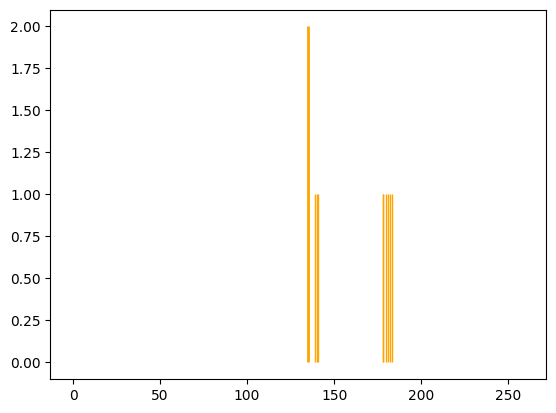

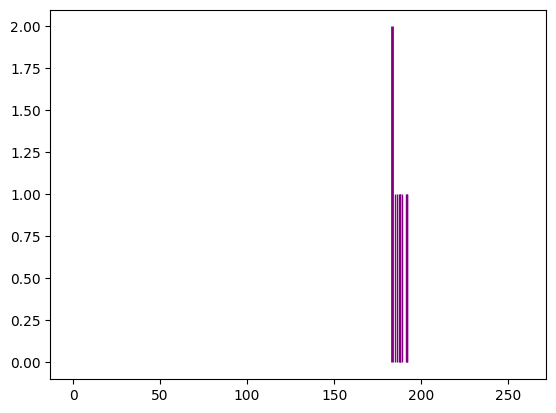

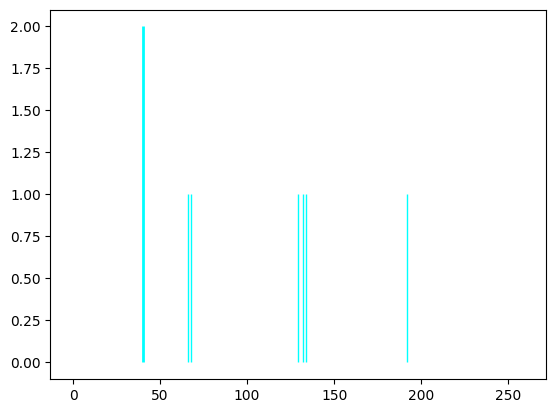

Num: 2603
Spectrum num=2603, size=584, matched=114, frac=0.1952054794520548
Spectrum num=2603, size=584, matched=102, frac=0.17465753424657535


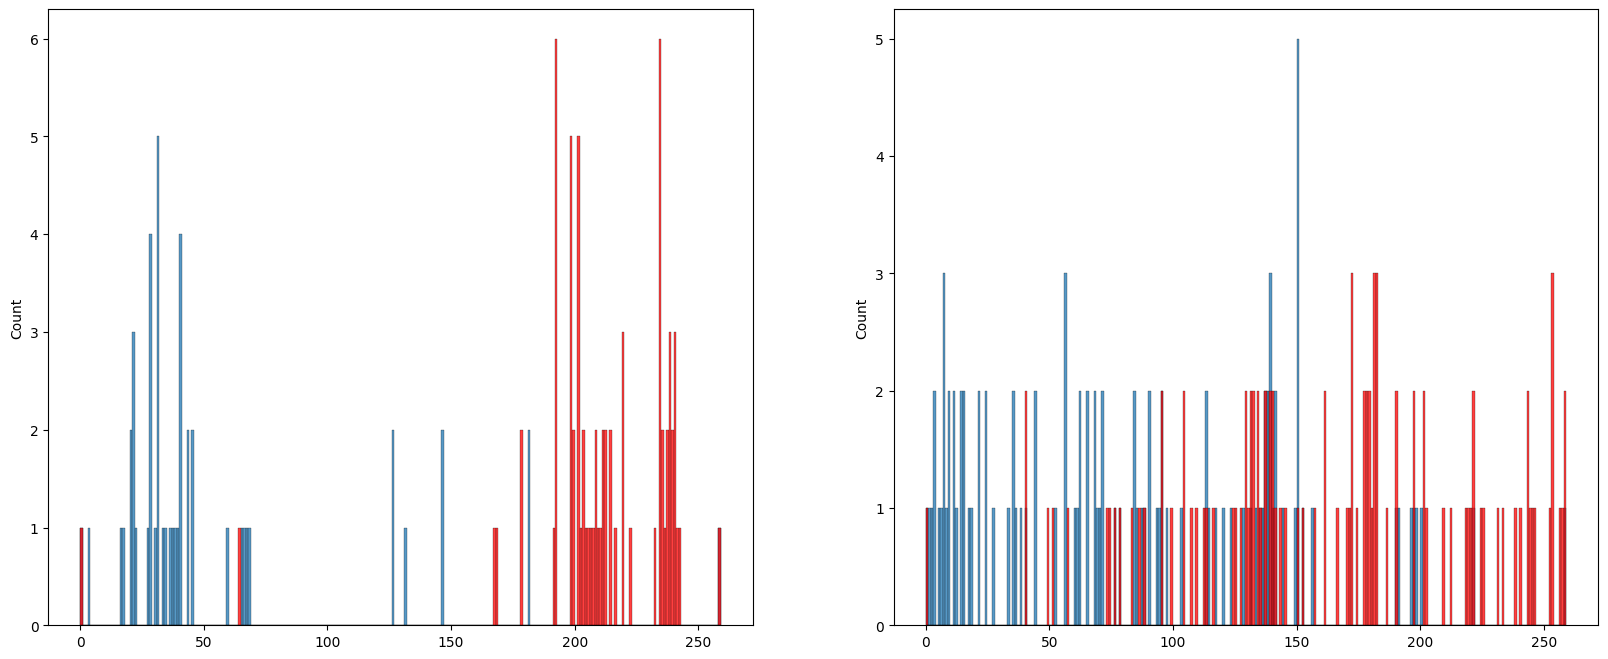

<Figure size 1200x800 with 0 Axes>

Ladders
{1, 2, 3, 4, 5, 390, 7, 8, 9, 10, 6, 12, 13, 15, 18, 530, 149, 21, 24, 281, 27, 29, 30, 157, 33, 163, 548, 295, 40, 430, 46, 174, 569, 67, 198, 70, 203, 76, 207, 209, 470, 87, 107, 109, 382}
{0, 14, 144, 16, 19, 23, 32, 549, 427, 44, 45, 304, 178, 50, 311, 57, 60, 197, 71, 201, 206, 81, 82, 215, 92, 104}
{544, 34, 36, 37, 75, 172, 173, 80, 49, 400, 179, 56, 26, 94}
{420, 134, 424, 232, 208, 244, 148, 350}
{325, 42, 77, 156, 181, 373, 444, 61}
{394, 434, 86, 55, 151, 381}
{334, 111, 367, 241, 404, 437}
{73, 561, 466, 372, 343, 152}
{226, 131, 169, 137, 425, 533}
{193, 168, 41, 330, 83, 475, 348, 255}
{322, 491, 302, 48, 245, 251}
{267, 140, 429, 433, 314, 446}
{384, 422, 521, 22, 507, 124}
{229, 43, 269, 276, 279, 189}
{258, 135, 141, 145, 190, 383}
{545, 165, 143, 567, 93}
{546, 136, 106, 558, 180}
{256, 452, 554, 183, 154}
{480, 261, 435, 280, 155}
{550, 368, 498, 313, 31}
{321, 289, 518, 200, 271}
{291, 327, 526, 219, 318}
{161, 74, 332, 237, 440}
{421, 456, 297, 298, 240}
{3

100%|██████████| 20/20 [2:00:58<00:00, 362.93s/it]  

Actual number of ladders: 4 Distribution: [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [27, 18, 9, 6] Distribution: [0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


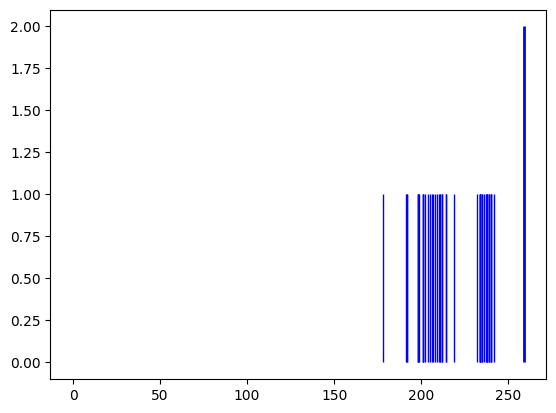

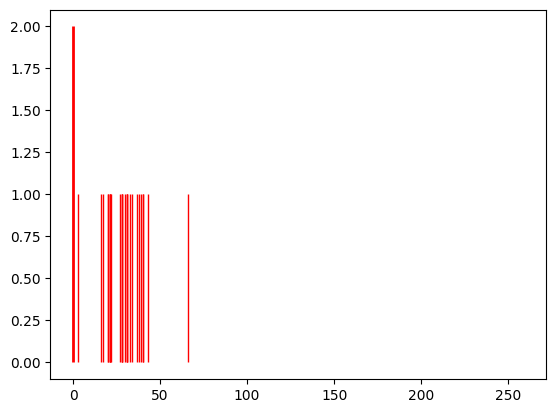

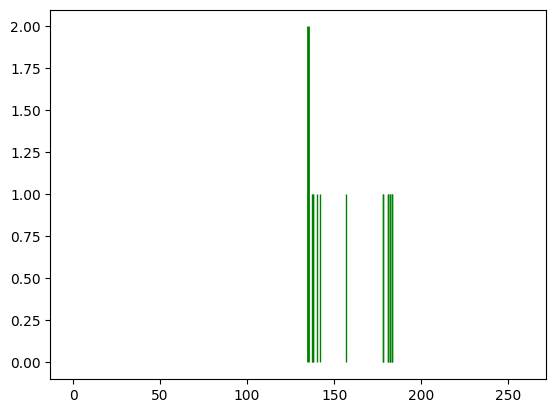

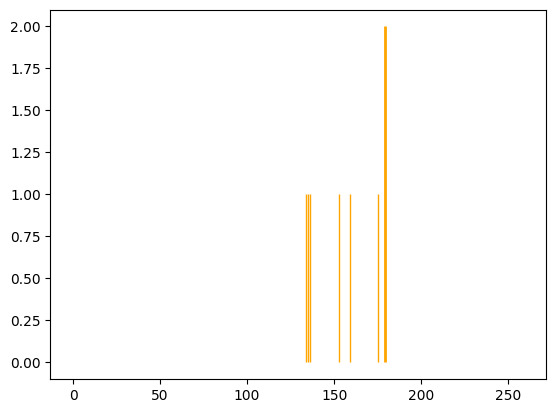

Num: 2614
Spectrum num=2614, size=84, matched=9, frac=0.10714285714285714
Spectrum num=2614, size=84, matched=10, frac=0.11904761904761904


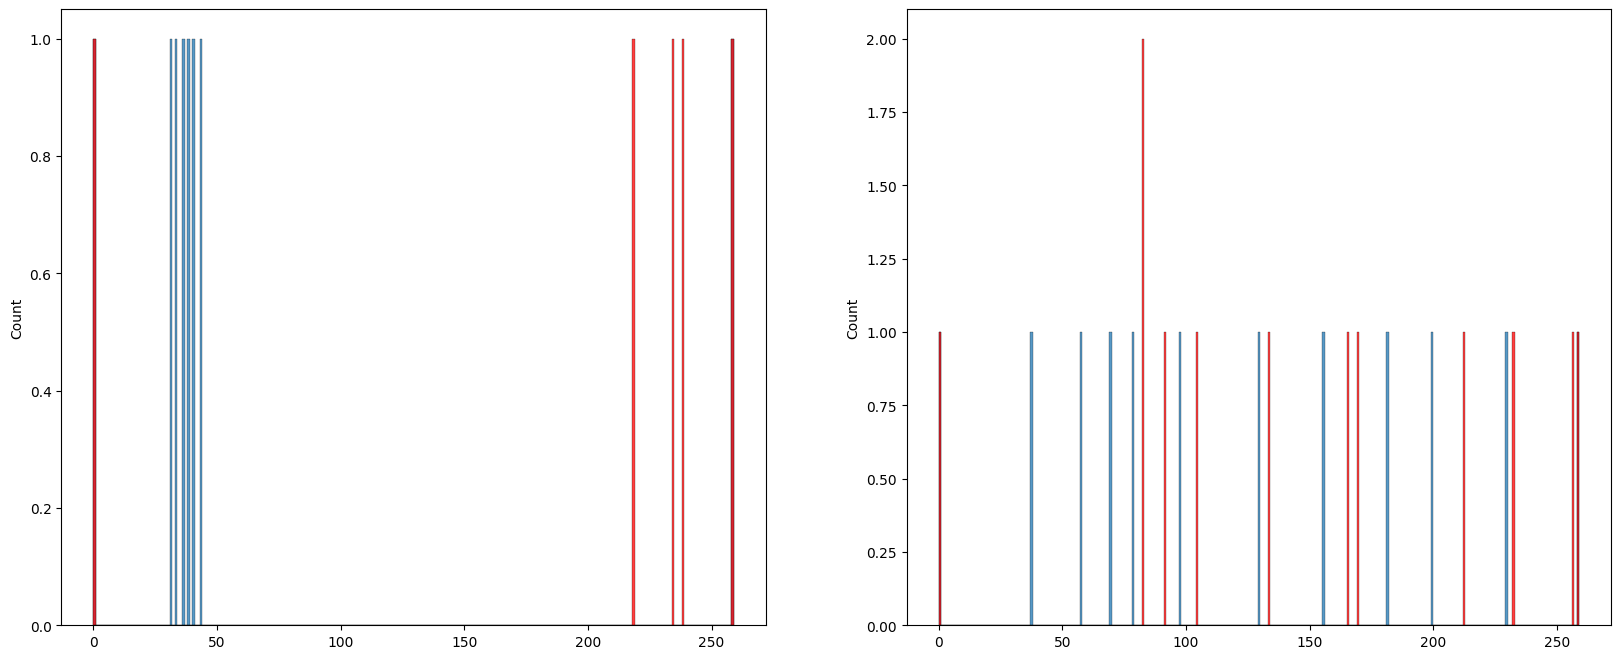

<Figure size 1200x800 with 0 Axes>

Ladders
Filtering ladders by error


100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Actual number of ladders: 0 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Num: 2682
Spectrum num=2682, size=243, matched=65, frac=0.2674897119341564
Spectrum num=2682, size=243, matched=51, frac=0.20987654320987653


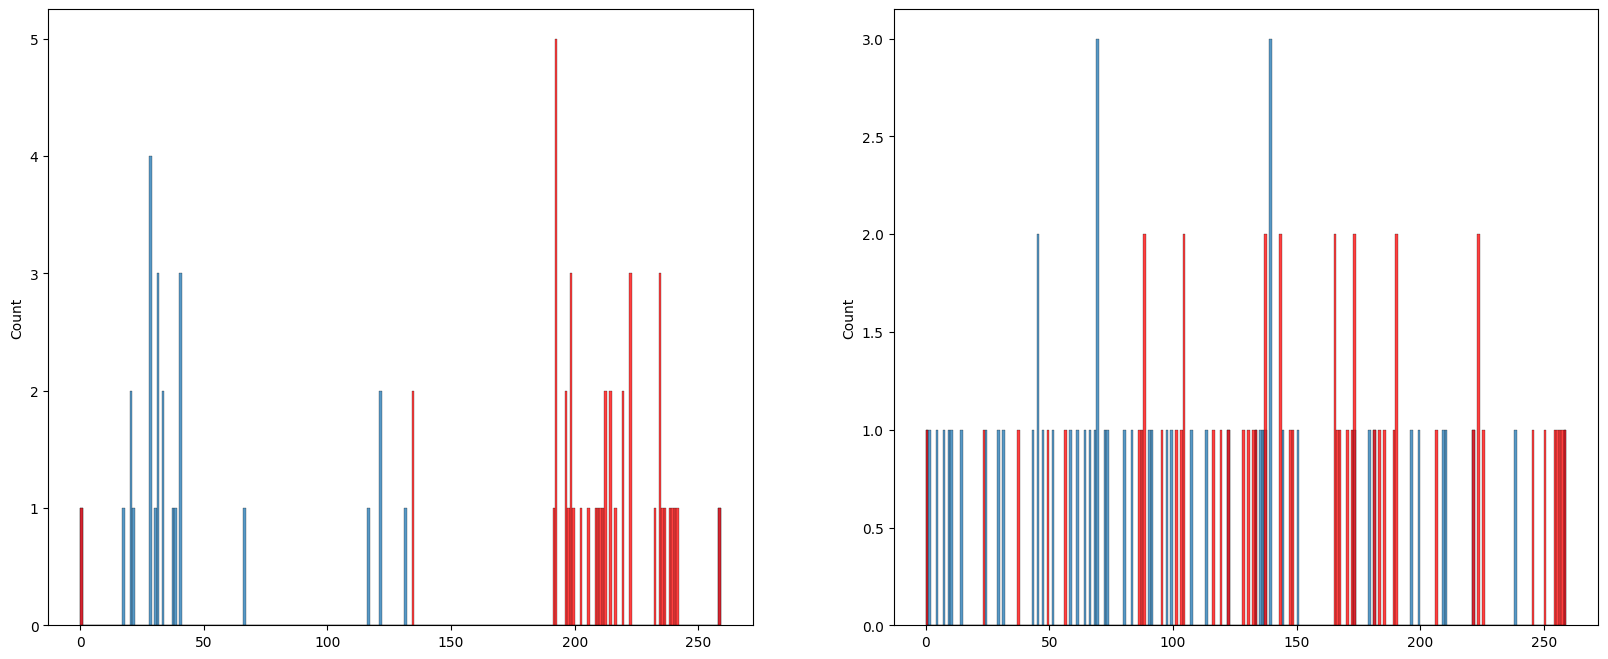

<Figure size 1200x800 with 0 Axes>

Ladders
{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 137, 13, 18, 21, 22, 27, 31, 32, 168, 41, 48, 54, 78, 89, 91, 118}
{97, 162, 194, 1, 69, 42, 11, 12, 19, 86, 23, 92, 94}
{164, 75, 14, 47, 17, 126}
{130, 50, 88, 29, 159}
{68, 167, 232, 114, 95}
{225, 39, 15, 211, 181}
Filtering ladders by error


100%|██████████| 20/20 [04:46<00:00, 14.32s/it]

Actual number of ladders: 2 Distribution: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]
Actual length of ladders: [20, 8] Distribution: [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 5 0 0 0]


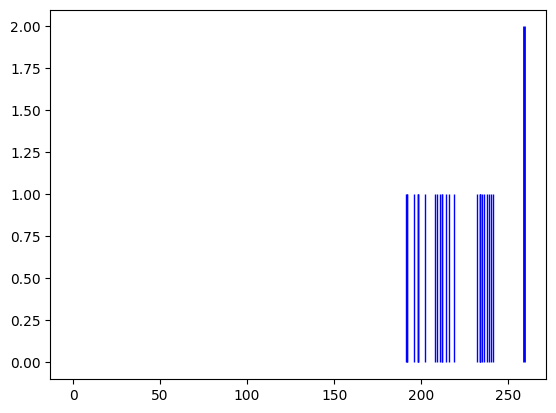

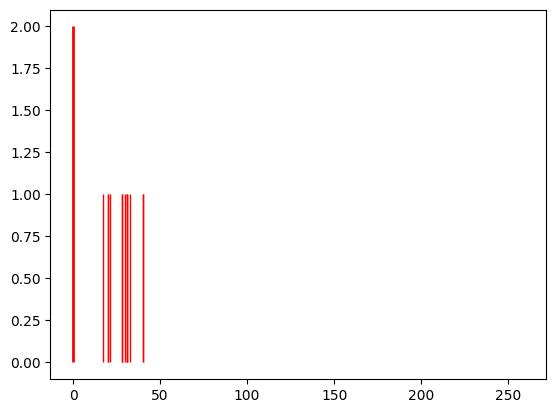

Num: 2848
Spectrum num=2848, size=162, matched=4, frac=0.024691358024691357
Spectrum num=2848, size=162, matched=43, frac=0.2654320987654321


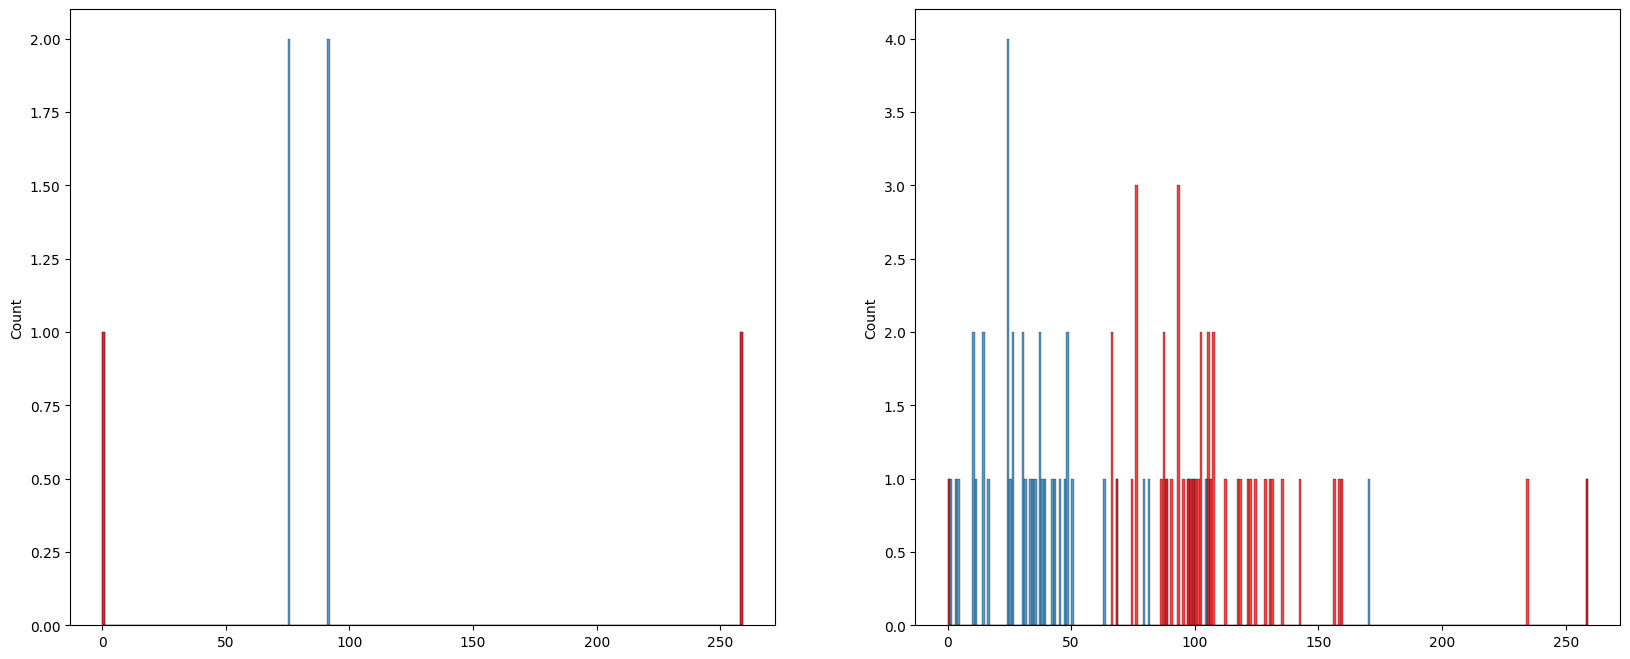

<Figure size 1200x800 with 0 Axes>

Ladders
{99, 68, 17, 119, 59, 125, 62}
{161, 76, 12, 19, 84, 149, 27, 60}
{7, 8, 20, 22, 151, 28, 30}
{114, 52, 23, 89, 58}
{69, 103, 41, 48, 115, 120}
{32, 6, 11, 79, 51}
{74, 142, 83, 29, 63}
Filtering ladders by error


100%|██████████| 20/20 [03:28<00:00, 10.41s/it]


Actual number of ladders: 0 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Actual length of ladders: [] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]
Num: 2851
Spectrum num=2851, size=104, matched=3, frac=0.028846153846153848
Spectrum num=2851, size=104, matched=28, frac=0.2692307692307692


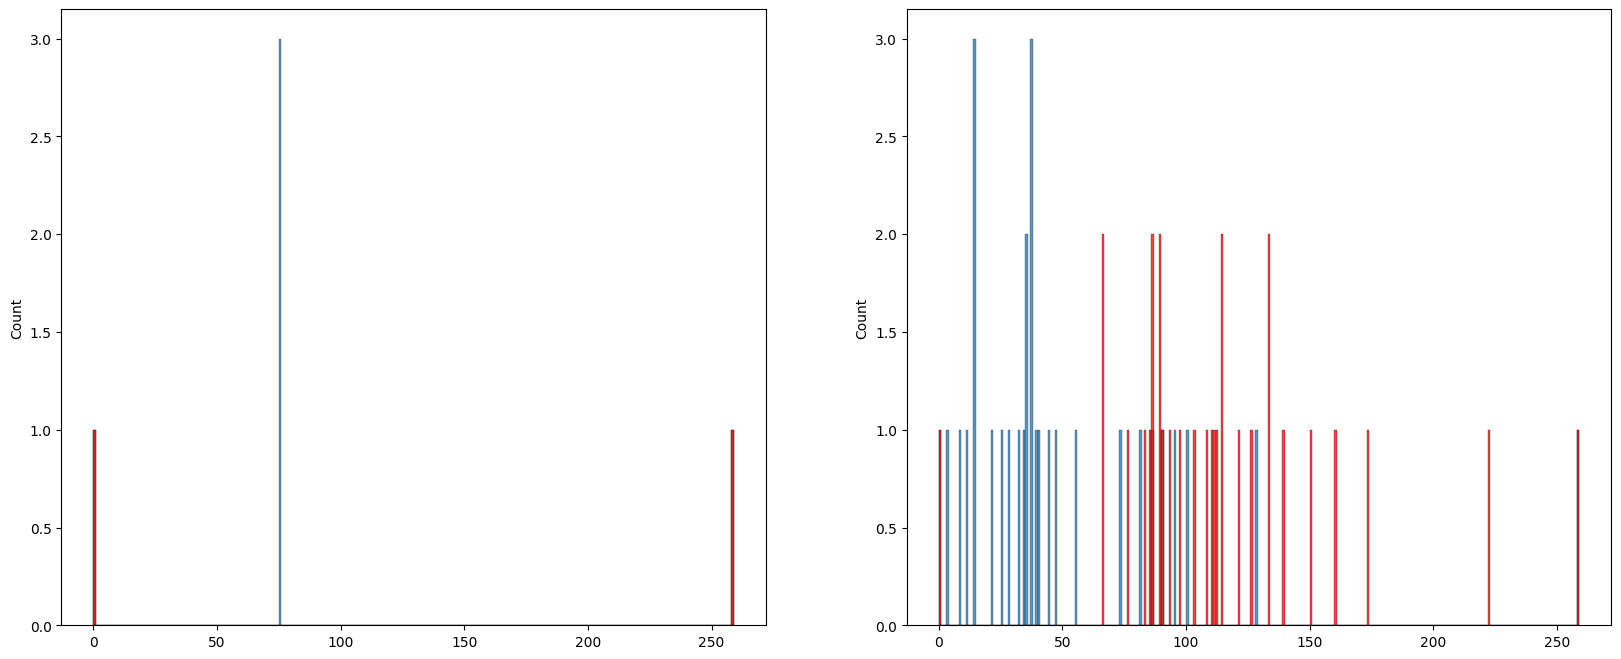

<Figure size 1200x800 with 0 Axes>

Ladders
{72, 85, 54, 90, 60, 94}
{0, 3, 4, 7, 77, 20}
Filtering ladders by error


100%|██████████| 20/20 [00:52<00:00,  2.62s/it]

Actual number of ladders: 0 Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual length of ladders: [] Distribution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [24]:
import pickle

filter_small_ladders = False
filter_ladders_by_error = True

ions_pr_su = get_ions(
    sequence,
    prefix=True,
    suffix=True,
    middle=False,
    min_length=1,
    include_loose_molecules=True,
    max_deconv_err=2,
    loose_molecules_params={'remove_molecule': True, 'add_molecule': False}
)

ions_middle = get_ions(
    sequence,
    prefix=False,
    suffix=False,
    middle=True,
    min_length=10,
    include_loose_molecules=True,
    max_deconv_err=0,
    loose_molecules_params={'remove_molecule': True, 'add_molecule': False}
)

archive = []

# for num in sorted(interesting_nums, key=lambda num: len(get_msalign_spec(msalign_specs=msalign_specs, num=num)['m_array']), reverse=True):
for num in interesting_nums[0::2]:
    print('Num:', num)
    archive_item = {'num': num}

    item = get_msalign_spec(msalign_specs=msalign_specs, num=num)
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    
    matched = match_items(ions_pr_su, 'mass_0', item['m_array'], None, err=5)
    archive_item['matched_pr_su'] = copy.deepcopy(matched)
    print(f'Spectrum num={num}, size={len(item["m_array"])}, matched={len(matched)}, frac={len(matched) / len(item["m_array"])}')

    b_pos = [x['item1']['len'] for x in matched if x['item1']['type'] == 'b']
    y_pos = [len(sequence) - x['item1']['len'] for x in matched if x['item1']['type'] == 'y']
          
    plt.figure(figsize=(12, 8))
    sns.histplot(b_pos + [0, len(sequence)], bins=len(sequence), ax=axs[0])
    sns.histplot(y_pos + [0, len(sequence)], bins=len(sequence), color='r', ax=axs[0])

    matched = match_items(ions_middle, 'mass_0', item['m_array'], None, err=5)
    archive_item['matched_middle_unfiltered'] = copy.deepcopy(matched)
    matched = filter_repeating_matches(matched)
    archive_item['matched_middle'] = copy.deepcopy(matched)
    print(f'Spectrum num={num}, size={len(item["m_array"])}, matched={len(matched)}, frac={len(matched) / len(item["m_array"])}')

    l_pos = []
    r_pos = []
    for match in matched:
        if match['item1']['type'] == 'm':
            gr = re.match(r'''^m(\d+)_(\d+)\D*''', match['item1']['name'], re.DOTALL)
            l = int(gr.group(1)); r = int(gr.group(2))
            l_pos.append(l)
            r_pos.append(r)
              
    sns.histplot(l_pos + [0, len(sequence)], bins=len(sequence), ax=axs[1])
    sns.histplot(r_pos + [0, len(sequence)], bins=len(sequence), color='r', ax=axs[1])
    plt.show()


    print('Ladders')
    m_array = add_ids_to_masses(item['m_array'])
    all_segments = generate_all_ladders(m_array, ions, debug=True)
    archive_item['all_segments_unfiltered'] = copy.deepcopy(all_segments)

    if filter_small_ladders:
        print('Filtering small ladders')
        biggest_ladder_dist = gen_distribution_of_biggest_ladder(m_array, T=20)
        archive_item['biggest_ladder_dist'] = copy.deepcopy(biggest_ladder_dist)
        ladder_size_threshold = np.percentile(biggest_ladder_dist, 90)
        archive_item['ladder_size_threshold'] = ladder_size_threshold
        print('Threshold:', ladder_size_threshold)

        all_segments = [item for item in all_segments if get_cnt_diff_ions(item) >= ladder_size_threshold]
    
    if filter_ladders_by_error:
        print('Filtering ladders by error')
        all_segments = select_ladders_with_specific_error(all_segments)

        cnt_ladders_with_specific_error_dist, len_ladders_with_specific_error_dist = gen_distribution_of_select_ladders_with_specific_error(m_array, T=20)
        print('Actual number of ladders:', len(all_segments), 'Distribution:', cnt_ladders_with_specific_error_dist)
        print('Actual length of ladders:', [get_cnt_diff_ions(item) for item in all_segments], 'Distribution:', len_ladders_with_specific_error_dist)
        archive_item['cnt_ladders_with_specific_error_dist'] = copy.deepcopy(cnt_ladders_with_specific_error_dist)
        archive_item['len_ladders_with_specific_error_dist'] = copy.deepcopy(len_ladders_with_specific_error_dist)
    
    archive_item['all_segments'] = copy.deepcopy(all_segments)

    draw_all_ladders(all_segments)

    archive.append(archive_item)

    with open('archive_error_final_part_1.pickle', 'wb') as f:
        pickle.dump(archive, f)

In [24]:
# all_archive = []

# for fileName in ['archive_error_final_part_1.pickle', 'archive_error_final_part_2.pickle', 'archive_error_final_part_3.pickle']:
#     with open(fileName, 'rb') as f:
#         all_archive += pickle.load(f)

In [25]:
# all_archive.sort(key=lambda x: x['num'])

In [26]:
# with open('archive_error_final_all.pickle', 'wb') as f:
#     pickle.dump(all_archive, f)

In [41]:
import pickle
with open('archive_error_final_all.pickle', 'rb') as f:
    archive = pickle.load(f)

In [42]:
len(archive)

646

In [43]:
for archive_item in archive:
    if len(archive_item['all_segments_unfiltered']) == 0:
        continue
    print(archive_item['num'], len(archive_item['all_segments']))
    threshold = np.quantile(archive_item['len_ladders_with_specific_error_dist'], 0.95)
    print(archive_item['num'], sum([1 if get_cnt_diff_ions(item) <= threshold else 0 for item in archive_item['all_segments']]))
    threshold = np.max(archive_item['len_ladders_with_specific_error_dist'])
    # print(archive_item['num'], sum([1 if get_cnt_diff_ions(item) <= threshold else 0 for item in archive_item['all_segments']]))
    # print()
    archive_item['all_segments'] = [item for item in archive_item['all_segments'] if get_cnt_diff_ions(item) > threshold]

794 0
794 0
795 2
795 0
796 0
796 0
797 0
797 0
821 1
821 0
822 2
822 0
823 2
823 0
838 0
838 0
839 3
839 0
844 2
844 0
868 2
868 0
874 1
874 0
875 2
875 0
877 0
877 0
879 2
879 0
905 1
905 0
911 2
911 0
915 2
915 0
943 0
943 0
948 2
948 0
951 1
951 0
993 1
993 0
995 3
995 0
1037 1
1037 0
1041 2
1041 0
1042 2
1042 0
1066 2
1066 0
1068 0
1068 0
1069 2
1069 0
1074 3
1074 0
1076 3
1076 0
1078 2
1078 0
1103 3
1103 0
1152 0
1152 0
1183 0
1183 0
1193 0
1193 0
1220 0
1220 0
1231 0
1231 0
1236 2
1236 0
1256 1
1256 0
1263 0
1263 0
1275 4
1275 0
1288 4
1288 0
1293 2
1293 0
1294 2
1294 0
1299 1
1299 0
1300 0
1300 0
1316 2
1316 0
1319 3
1319 0
1327 2
1327 0
1343 1
1343 0
1344 2
1344 0
1346 2
1346 0
1351 2
1351 0
1357 3
1357 0
1437 0
1437 0
1443 0
1443 0
1554 1
1554 0
1575 1
1575 0
1599 0
1599 0
1602 0
1602 0
1604 0
1604 0
1613 2
1613 0
1616 1
1616 0
1617 1
1617 0
1625 0
1625 0
1633 0
1633 0
1634 0
1634 0
1647 0
1647 0
1657 0
1657 0
1663 4
1663 2
1667 0
1667 0
1668 1
1668 0
1670 1
1670 0
1687 1
168

In [44]:
2508 in interesting_nums

True

In [67]:
# # save archive to file archive_error_filt_v1.pickle
# with open('archive_error_filt_v1.pickle', 'wb') as f:
#     pickle.dump(archive, f)

In [119]:
def draw_all_ladders_2_by_2(ladders, shape, fileName=None):
    
    colors = itertools.cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow'])
            
    fig, axs = plt.subplots(*shape, figsize=(12, 8))  # creates a 2x2 grid of Axes objects
    axs = axs.ravel()  # flattens the grid to easily iterate over it
    
    for idx, (ladder, color) in enumerate(zip(ladders, colors)):
        ax = axs[idx]  # select the subplot to draw on
        
        ax.vlines([0, len(sequence)], 0, [0, 0], colors='black', linewidth=1, alpha=1)
    
        located_ladder = locate_ladder(ladder)

        ax.vlines([located_ladder['fixed_end']], 0, [2], colors=color, linewidth=2, alpha=1)
        ax.vlines(located_ladder['ends'], 0, 1, colors=color, linewidth=1, alpha=1)

        ax.set_xlabel("Позиция в последовательности аминокислот")  # Set the x-axis label for each subplot
        ax.set_yticklabels([])  # Remove the y-axis tick labels

    plt.tight_layout()  # adjusts subplot params so that subplots fit into the figure area
    if fileName is not None:
        plt.savefig(fileName)
    plt.show()  # Show the figure


In [217]:
def display_ladders_text(ladders, left=None, right=None, only_interior=False, num=None):
    printed_num = False
    for ladder in ladders:
        located_ladder = locate_ladder(ladder, precursor_left=left, precursor_right=right)

        if only_interior and located_ladder['ladder_type'] != 'interior':
            continue

        if num is not None and not printed_num:
            print(num)
            printed_num = True

        # Sort fragments by length in descending order
        fragments = sorted(set(located_ladder['pairs']), key=lambda x: x[1] - x[0], reverse=True)

        print(sequence)
        if left is not None and right is not None:
            print(' ' * left + sequence[left: right])
        print('-' * len(sequence))

        # Depending on the type of ladder, print fragments aligned by their shared end
        if located_ladder['type'] == 'left':
            # Print each fragment, padded with spaces to align with the left end of the sequence
            for fragment in fragments:
                print(' ' * fragment[0] + sequence[fragment[0]: fragment[1]])
                
        elif located_ladder['type'] == 'right':
            # Print each fragment, padded with spaces to align with the right end of the sequence
            for fragment in fragments:
                print(' ' * fragment[0] + sequence[fragment[0]: fragment[1]])
        print()

In [214]:
archive[3]['precursor']

(0, 26)

In [213]:
locate_ladder(archive[3]['all_segments'][0])

{'pairs': [(14, 26),
  (13, 26),
  (8, 26),
  (19, 26),
  (19, 26),
  (17, 26),
  (16, 26),
  (15, 26),
  (18, 26),
  (2, 26),
  (16, 26),
  (8, 26),
  (9, 26),
  (10, 26),
  (4, 26),
  (2, 26),
  (3, 26),
  (0, 26),
  (0, 26),
  (1, 26)],
 'fixed_end': 26,
 'ends': [14,
  13,
  8,
  19,
  19,
  17,
  16,
  15,
  18,
  2,
  16,
  8,
  9,
  10,
  4,
  2,
  3,
  0,
  0,
  1],
 'type': 'right',
 'ladder_type': 'unknown',
 'error': 18.008788927643764}

In [220]:
for archive_item in archive:
    # if archive_item['num'] == 2603:
    if True:
        if archive_item['precursor'] is None:
            continue
        left, right = archive_item['precursor']
        # print(archive_item['num'])
        ladders = archive_item['all_segments']
        display_ladders_text(ladders, left=left, right=right, only_interior=True, num=archive_item['num'])
        # print()

995
EHHWGYGKHNGPEHWHKDFPIANGERQSPVDIDTKAVVQDPALKPLALVYGEATSRRMVNNGHSFNVEYDDSQDKAVLKDGPLTGTYRLVQFHFHWGSSDDQGSEHTVDRKKYAAELHLVHWNTKYGDFGTAAQQPDGLAVVGVFLKVGDANPALQKVLDALDSIKTKGKSTDFPNFDPGSLLPNVLDYWTYPGSLTTPPLLESVTWIVLKEPISVSSQQMLKFRTLNFNAEGEPELLMLANWRPAQPLKNRQVRGFPK
                                                  GEATSRRMVNNGHSFNVEYDDSQDKAVLKDGPLTGTY
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                         MVNNGHSFNVEYDDSQDKAVLKDGPLTG
                                                         MVNNGHSFNVEYDDSQDKAVLKDGPLT
                                                         MVNNGHSFNVEYDDSQDKAVLKD
                                                         MVNNGHSFNVEYDDSQDKAVLK
                                                        

In [121]:
sequence

'EHHWGYGKHNGPEHWHKDFPIANGERQSPVDIDTKAVVQDPALKPLALVYGEATSRRMVNNGHSFNVEYDDSQDKAVLKDGPLTGTYRLVQFHFHWGSSDDQGSEHTVDRKKYAAELHLVHWNTKYGDFGTAAQQPDGLAVVGVFLKVGDANPALQKVLDALDSIKTKGKSTDFPNFDPGSLLPNVLDYWTYPGSLTTPPLLESVTWIVLKEPISVSSQQMLKFRTLNFNAEGEPELLMLANWRPAQPLKNRQVRGFPK'

1327


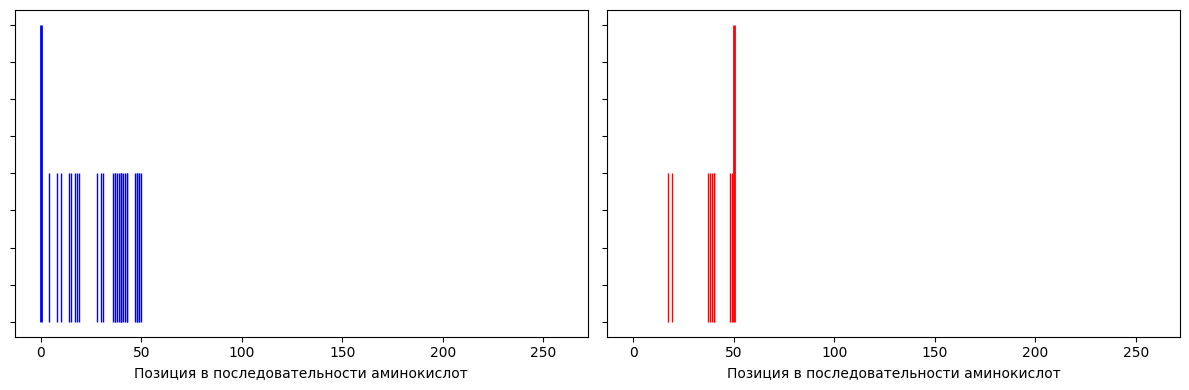

In [120]:
for archive_item in archive:
    # if len(archive_item['all_segments']) == 4:
    if archive_item['num'] == 1327:
        print(archive_item['num'])
        ladders = archive_item['all_segments']
        draw_all_ladders_2_by_2(ladders, (1, 2), fileName='ladders_1327.png')

2329


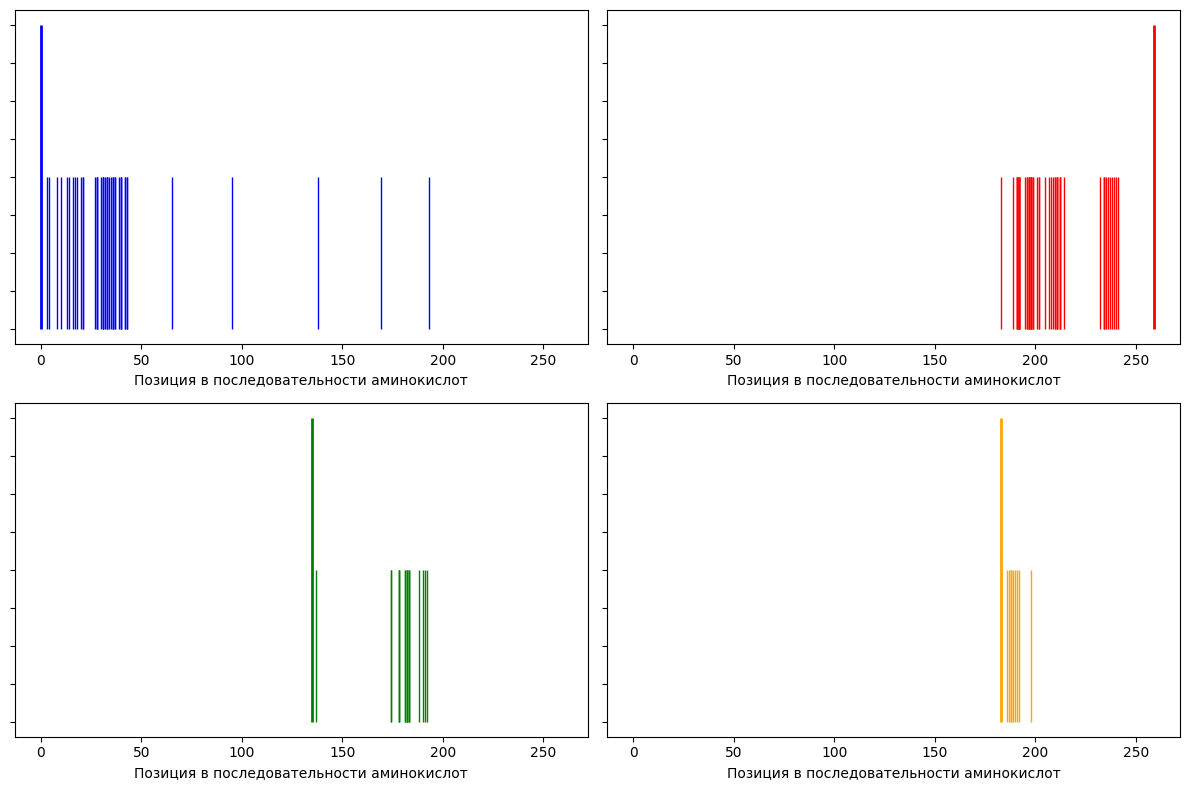

In [111]:
for archive_item in archive:
    # if len(archive_item['all_segments']) == 4:
    if archive_item['num'] == 2329:
        print(archive_item['num'])
        ladders = archive_item['all_segments']
        draw_all_ladders_2_by_2([ladders[0], ladders[1], ladders[2], ladders[3]], (2, 2))

In [100]:
len(archive)

646

In [21]:
# import pickle
# # save archive using pickle
# with open('archive.pickle', 'wb') as f:
#     pickle.dump(archive, f)

In [22]:
# import pickle

# archive_files = ['archive.pickle', 'archive_2.pickle', 'archive_3.pickle']

# archive = []
# for archive_file in archive_files:
#     with open(archive_file, 'rb') as f:
#         archive += pickle.load(f)

In [25]:
# archive.sort(key=lambda x: x['num'])

In [27]:
# import pickle

# # save archive using pickle to archive_all.pickle
# with open('archive_all.pickle', 'wb') as f:
#     pickle.dump(archive, f)

In [68]:
# import pickle
# # load archive_2 using pickle
# with open('archive_all_v2.pickle', 'rb') as f:
#     archive = pickle.load(f)

In [30]:
len(archive)

646

In [70]:
for item in archive:
    if item['precursor'] == (0, 259):
        print(item['num'])

2309
2310
2311
2313
2314
2316
2318
2322
2323
2324
2326
2327
2329
2331
2332
2340
2345
2385
2431
2450
2458
2464
2466
2467
2468
2475
2482
2490
2505
2508
2515
2527
2535
2544
2575
2577
2603
2608
2682


In [22]:
# filter_small_ladders = True

# for archive_item in archive:
#     print('Num:', archive_item['num'])

#     print('Unfiltered Ladders')
#     for ladder in archive_item['all_segments_unfiltered']:
#         print(sorted((x['ion']['name'] for x in ladder), key=lambda x: int(x[1:])))

#     if filter_small_ladders:
#         print('Filtering small ladders')
#         print('Threshold:', archive_item['ladder_size_threshold'])

#         print('Filtered Ladders')
#         for ladder in archive_item['all_segments']:
#             print(sorted((x['ion']['name'] for x in ladder), key=lambda x: int(x[1:])))
    
#     draw_all_ladders(archive_item['all_segments'])

In [30]:
len(archive)

646

In [39]:
mass.calculate_mass(sequence[:40], ion_type='y', charge=0)

4630.1915042030405

In [44]:
archive[0]

{'num': 732,
 'matched_pr_su': [],
 'matched_middle_unfiltered': [],
 'matched_middle': [],
 'all_segments_unfiltered': [],
 'biggest_ladder_dist': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'ladder_size_threshold': 0.0,
 'all_segments': []}

In [46]:
for archive_item in archive:
    archive_item['precursor'] = None

In [48]:
print_unfiltered_ladders = True
print_filtered_ladders = True
draw_ladders = True
ask_human_about_precursor = True

fixed_ends = Counter()

def get_potential_precursor(located_ladders):
    left, right = None, None
    for located_ladder in located_ladders:
        if located_ladder['type'] == 'left':
            pos = located_ladder['fixed_end']
            if left is None or pos < left:
                left = pos
        elif located_ladder['type'] == 'right':
            pos = located_ladder['fixed_end']
            if right is None or pos > right:
                right = pos
    return left, right


def get_potential_precursor_2(located_ladders):
    left, right = None, None
    for located_ladder in located_ladders:
        if located_ladder['type'] == 'left':
            pos = located_ladder['fixed_end']
            if left is None or pos < left:
                left = pos
            
            pos = max(located_ladder['ends'])
            if right is None or pos > right:
                right = pos
        elif located_ladder['type'] == 'right':
            pos = located_ladder['fixed_end']
            if right is None or pos > right:
                right = pos

            pos = min(located_ladder['ends'])
            if left is None or pos < left:
                left = pos
    return left, right


for archive_item in archive:
    if len(archive_item['all_segments']) == 0:
        if ask_human_about_precursor:
            if archive_item['precursor'] is None:
                archive_item['precursor'] = (None, None)
        continue

    print('Num:', archive_item['num'])
    spec = get_msalign_spec(msalign_specs=msalign_specs, num=archive_item['num'])

    if print_unfiltered_ladders:
        print()
        print('Unfiltered Ladders')
        for ladder in archive_item['all_segments_unfiltered']:
            print(sorted((x['ion']['name'] for x in ladder), key=lambda x: int(x[1:])))

    print()
    print('Actual precursor mass:', spec['precursor_m'])

    ladders = archive_item['all_segments']
    located_ladders = [locate_ladder(ladder) for ladder in ladders]

    left, right = get_potential_precursor(located_ladders)
    left2, right2 = get_potential_precursor_2(located_ladders)

    print()
    print('Potential precursor:', left, right)
    if left is not None and right is not None:
        print('Potential precursor mass:', mass.calculate_mass(sequence[left:right], ion_type='y', charge=0))
    
    print('Potential precursor 2:', left2, right2)
    if left2 is not None and right2 is not None:
        print('Potential precursor mass 2:', mass.calculate_mass(sequence[left2:right2], ion_type='y', charge=0))

    if print_filtered_ladders:
        print()
        # print('Threshold:', archive_item['ladder_size_threshold'])
        for ladder, located_ladder in zip(archive_item['all_segments'], located_ladders):
            print()
            print(sorted((x['ion']['name'] for x in ladder), key=lambda x: int(x[1:])))
            print(located_ladder['error'])
            for x in located_ladder['pairs']:
                print(x)
            fixed_ends[located_ladder['fixed_end']] += 1
    
    if draw_ladders:
        draw_all_ladders(ladders)
    

    if ask_human_about_precursor and archive_item['precursor'] is None:
        while True:
            infer_left = left2
            infer_right = right2

            human_input = input('Enter potential precursor (inferred: {} {}): '.format(infer_left, infer_right))
            if human_input.startswith('skip'[0]):
                break
            elif human_input.startswith('none'[0]):
                archive_item['precursor'] = (None, None)
                break
            elif human_input.startswith('infer'[0]):
                archive_item['precursor'] = (infer_left, infer_right)
                break
            else:
                try:
                    left, right = map(int, human_input.split())
                    if left == -1:
                        left = None
                    if right == -1:
                        right = None
                    if not (left is None or 0 <= left <= len(sequence)):
                        print('Invalid input')
                        continue
                    if not (right is None or 0 <= right <= len(sequence)):
                        print('Invalid input')
                        continue
                    if not (left is None or right is None or left < right):
                        print('Invalid input')
                        continue
                    archive_item['precursor'] = (left, right)
                    break
                except:
                    print('Invalid input')
                    continue
    
    clear_output()


In [185]:
# # save archive to file archive_final_095_with_precursor.pickle
# with open('archive_final_095_with_precursor.pickle', 'wb') as f:
#     pickle.dump(archive, f)

In [184]:
# filter ladders from all_segments that lie outside of the precursor range
for archive_item in archive:
    if archive_item['precursor'] is None:
        continue
    left, right = archive_item['precursor']
    if left is None:
        left = 0
    if right is None:
        right = len(sequence)
    
    fixed_all_segments = []
    for ladder in archive_item['all_segments']:
        located_ladder = locate_ladder(ladder)
        if located_ladder['type'] == 'left':
            if not (left <= located_ladder['fixed_end'] <= max(located_ladder['ends']) <= right):
                print(archive_item['num'])
            else:
                fixed_all_segments.append(ladder)
        elif located_ladder['type'] == 'right':
            if not (left <= min(located_ladder['ends']) <= located_ladder['fixed_end'] <= right):
                print(archive_item['num'])
            else:
                fixed_all_segments.append(ladder)
    archive_item['all_segments'] = fixed_all_segments

In [57]:
ion_break_info = Counter()

for archive_item in archive:
    if archive_item['precursor'] is None:
        continue
    precursor_start, precursor_end = archive_item['precursor']
    if precursor_start is None and precursor_end is None:
        continue
    is_full_molecule = ((precursor_start == 0) and (precursor_end == len(sequence)))
    for ladder in archive_item['all_segments']:
        located_ladder = locate_ladder(ladder)
        if located_ladder['type'] == 'left':
            if precursor_start is not None:
                if precursor_start < located_ladder['fixed_end']:
                    ion_break_info[(located_ladder['fixed_end'], 'left', 'interior')] += 1
                elif precursor_start == located_ladder['fixed_end']:
                    ion_break_info[(located_ladder['fixed_end'], 'left', 'prefix')] += 1
        elif located_ladder['type'] == 'right':
            if precursor_end is not None:
                if precursor_end > located_ladder['fixed_end']:
                    ion_break_info[(located_ladder['fixed_end'], 'right', 'interior')] += 1
                elif precursor_end == located_ladder['fixed_end']:
                    ion_break_info[(located_ladder['fixed_end'], 'right', 'suffix')] += 1

In [151]:
from collections import defaultdict

def group_by_pos_and_sort_by_total_count(ion_break_info):
    # a dict with default values equal to []
    grouped_ion_break_info = defaultdict(list)
    for (pos, direction, type), count in ion_break_info.items():
        grouped_ion_break_info[pos].append((direction, type, count))
    
    return sorted(grouped_ion_break_info.items(), key=lambda x: sum(y[2] for y in x[1]), reverse=True)

def group_by_direction_and_type_and_first_letter_and_sort_by_total_count(ion_break_info):
    # a dict with default values equal to []
    grouped_ion_break_info = defaultdict(int)
    for (pos, direction, type), count in ion_break_info.items():
        if direction == 'left':
            grouped_ion_break_info[(direction, type, sequence[pos])] += count
        elif direction == 'right':
            grouped_ion_break_info[(direction, type, sequence[pos - 1])] += count    
    return sorted(grouped_ion_break_info.items(), key=lambda x: x[1], reverse=True)

In [161]:
sequence.count('P')

19

In [150]:
semi_block_size = 5

for pos, variants in group_by_pos_and_sort_by_total_count(ion_break_info):
    print('Pos =', pos)
    print(sequence[max(0, pos-semi_block_size):pos] + '|' + sequence[pos:min(pos+semi_block_size, len(sequence))])

    for direction, type, count in variants:
        print(direction, type, count)
    print()

Pos = 0
|EHHWG
left prefix 71

Pos = 259
RGFPK|
right suffix 60

Pos = 135
TAAQQ|PDGLA
left interior 28
left prefix 2

Pos = 183
PGSLL|PNVLD
left interior 20
right interior 1

Pos = 192
DYWTY|PGSLT
left interior 11
left prefix 4

Pos = 87
LTGTY|RLVQF
right suffix 4
left prefix 6

Pos = 40
AVVQD|PALKP
right suffix 3
right interior 3
left interior 3

Pos = 178
FPNFD|PGSLL
right suffix 1
right interior 6

Pos = 35
DIDTK|AVVQD
right suffix 3
right interior 1
left prefix 1

Pos = 50
LALVY|GEATS
left prefix 3
right suffix 2

Pos = 85
GPLTG|TYRLV
right suffix 4

Pos = 57
ATSRR|MVNNG
left interior 1
left prefix 1
right suffix 2

Pos = 46
ALKPL|ALVYG
left prefix 1
right suffix 3

Pos = 47
LKPLA|LVYGE
right suffix 2
right interior 1

Pos = 80
AVLKD|GPLTG
right suffix 3

Pos = 26
ANGER|QSPVD
right suffix 1
left prefix 1

Pos = 2
EH|HWGYG
left prefix 2

Pos = 118
AAELH|LVHWN
right suffix 2

Pos = 136
AAQQP|DGLAV
left interior 2

Pos = 173
GKSTD|FPNFD
right interior 1
left prefix 1

Pos = 36
IDTKA|

In [166]:
# needed_type = 'prefix'
# needed_type = 'suffix'
needed_type = 'interior'

most_common_left_ladder_start = []
most_common_right_ladder_end = []

for (direction, type, letter), total_count in group_by_direction_and_type_and_first_letter_and_sort_by_total_count(ion_break_info):
    # print(direction, type, letter, total_count)
    if type == needed_type:
        if direction == 'left':
            most_common_left_ladder_start.append((letter, total_count))
            print(total_count)
            print(f'{letter}___')
            print(f'{letter}__')
            print(f'{letter}_')
            print(f'{letter}')
            print()
        elif direction == 'right':
            most_common_right_ladder_end.append((letter, total_count))
            print(total_count)
            print(f'___{letter}')
            print(f' __{letter}')
            print(f'  _{letter}')
            print(f'   {letter}')
            print()
    # print()

63
P___
P__
P_
P

10
___D
 __D
  _D
   D

2
D___
D__
D_
D

2
A___
A__
A_
A

2
___L
 __L
  _L
   L

1
___K
 __K
  _K
   K

1
M___
M__
M_
M

1
K___
K__
K_
K

1
___A
 __A
  _A
   A

1
___G
 __G
  _G
   G

1
H___
H__
H_
H

1
___N
 __N
  _N
   N

1
Q___
Q__
Q_
Q

1
___E
 __E
  _E
   E

1
V___
V__
V_
V

1
___Q
 __Q
  _Q
   Q

